In [1]:
from rllab.algos.trpo import TRPO
from rllab.baselines.linear_feature_baseline import LinearFeatureBaseline
from rllab.envs.gym_env import GymEnv
from rllab.envs.normalized_env import normalize
from rllab.policies.gaussian_mlp_policy import GaussianMLPPolicy
from rllab.policies.constant_control_policy import ConstantControlPolicy
import rllab.misc.logger as logger
from rllab.sampler import parallel_sampler
from test import test_const_adv, test_rand_adv, test_learnt_adv, test_rand_step_adv, test_step_adv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import gym
import random
import pickle
import scipy
import argparse

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


### Default Parameters

In [2]:
env_name = None                     #Name of adversarial environment
path_length = 1000                  #Maximum episode length
layer_size = tuple([100,100,100])   #Layer definition
ifRender = False                    #Should we render?
afterRender = 100                   #After how many to animate
n_exps = 1                          #Number of training instances to run
n_itr = 25                          #Number of iterations of the alternating optimization
n_pro_itr = 1                       #Number of iterations for the protaginist
n_adv_itr = 1                       #Number of interations for the adversary
batch_size = 4000                   #Number of training samples for each iteration
save_every = 100                    #Save checkpoint every save_every iterations
n_process = 1                       #Number of parallel threads for sampling environment
adv_fraction = 0.25                 #Fraction of maximum adversarial force to be applied
step_size = 0.01                    #kl step size for TRPO
gae_lambda = 0.97                   #gae_lambda for learner
save_dir = './results'              #folder to save result in

### Variables for Experiment

In [3]:
env_name = 'HopperAdv-v1'

layer_size = tuple([64,64])
step_size = 0.01
gae_lambda = 1.0
batch_size = 25000

n_itr = 500
save_every = 20
n_process = 4

adv_fraction = 3.0

In [7]:
adv_strengths = [x * 0.5 for x in range(0, 6)]
adv_strengths.append(3.0)
print(adv_strengths)

[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]


In [8]:
args = [env_name, path_length, layer_size, ifRender, afterRender, n_exps, n_itr, n_pro_itr, n_adv_itr, 
        batch_size, save_every, n_process, adv_fraction, step_size, gae_lambda, save_dir]

### Adv Policy

In [9]:
filepath = 'results/Hopper/env-HopperAdv-v1_Exp1_Itr500_BS25000_Adv0.25_stp0.01_lam1.0_369983.p'

res_D = pickle.load(open(filepath,'rb'))
pretrained_adv_policy = res_D['adv_policy']

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
[2018-01-25 11:13:01,379] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


### Train Loop

In [10]:
## Initializing summaries for the tests ##
const_test_rew_summary = []
rand_test_rew_summary = []
step_test_rew_summary = []
rand_step_test_rew_summary = []
adv_test_rew_summary = []

## Preparing file to save results in ##
save_prefix = 'adv_env-{}_Exp{}_Itr{}_BS{}_Adv{}_stp{}_lam{}_{}'.format(env_name, n_exps, n_itr, batch_size, adv_fraction, step_size, gae_lambda, random.randint(0,1000000))
save_name = save_dir+'/'+save_prefix

## Looping over experiments to carry out ##
for ne in range(n_exps):
    ## Environment definition ##
    ## The second argument in GymEnv defines the relative magnitude of adversary. For testing we set this to 1.0.
    env = normalize(GymEnv(env_name, adv_fraction))
    env_orig = normalize(GymEnv(env_name, 1.0))

    ## Protagonist policy definition ##
    pro_policy = GaussianMLPPolicy(
        env_spec=env.spec,
        hidden_sizes=layer_size,
        is_protagonist=True
    )
    pro_baseline = LinearFeatureBaseline(env_spec=env.spec)

    ## Zero Adversary for the protagonist training ##
    zero_adv_policy = ConstantControlPolicy(
        env_spec=env.spec,
        is_protagonist=False,
        constant_val = 0.0
    )

    ## Adversary policy definition ##
    adv_policy = pretrained_adv_policy
    adv_baseline = LinearFeatureBaseline(env_spec=env.spec)

    ## Initializing the parallel sampler ##
    parallel_sampler.initialize(n_process)    

    ## Setting up summaries for testing for a specific training instance ##
    pro_rews = []
    adv_rews = []
    all_rews = []
    const_testing_rews = []
    const_testing_rews.append(test_const_adv(env_orig, pro_policy, path_length=path_length))
    rand_testing_rews = []
    rand_testing_rews.append(test_rand_adv(env_orig, pro_policy, path_length=path_length))
    step_testing_rews = []
    step_testing_rews.append(test_step_adv(env_orig, pro_policy, path_length=path_length))
    rand_step_testing_rews = []
    rand_step_testing_rews.append(test_rand_step_adv(env_orig, pro_policy, path_length=path_length))
    adv_testing_rews = []
    adv_testing_rews.append(test_learnt_adv(env, pro_policy, adv_policy, path_length=path_length))

    ## Loops through adversary strength levels
    n_loopsize = int(n_itr/len(adv_strengths))
    for adv_index, adv_strength in enumerate(adv_strengths):
        
        env = normalize(GymEnv(env_name, adv_strength))
        
        ## Optimizer for the Protagonist ##
        pro_algo = TRPO(
            env=env,
            pro_policy=pro_policy,
            adv_policy=adv_policy,
            pro_baseline=pro_baseline,
            adv_baseline=adv_baseline,
            batch_size=batch_size,
            max_path_length=path_length,
            n_itr=n_pro_itr,
            discount=0.995,
            gae_lambda=gae_lambda,
            step_size=step_size,
            is_protagonist=True
        )
        
        logger.log('\n\nAdversarial Level: {} Adversarial Strength: {}\n'.format(adv_index, adv_strength))
        
        ## Beginning alternating optimization ##
        for ni in range(n_loopsize):
            logger.log('\n\nExperiment: {} Iteration: {}\n'.format(ne,ni+n_loopsize*adv_index,))

            ## Train Protagonist
            pro_algo.train()
            pro_rews += pro_algo.rews; all_rews += pro_algo.rews;
            logger.log('Protag Reward: {}'.format(np.array(pro_algo.rews).mean()))

            ## Test the learnt policies
            const_testing_rews.append(test_const_adv(env, pro_policy, path_length=path_length))
            rand_testing_rews.append(test_rand_adv(env, pro_policy, path_length=path_length))
            step_testing_rews.append(test_step_adv(env, pro_policy, path_length=path_length))
            rand_step_testing_rews.append(test_rand_step_adv(env, pro_policy, path_length=path_length))
            adv_testing_rews.append(test_learnt_adv(env, pro_policy, adv_policy, path_length=path_length))

            if ni%afterRender==0 and ifRender==True:
                test_const_adv(env, pro_policy, path_length=path_length, n_traj=1, render=True);

            if ni!=0 and ni%save_every==0:
                ## SAVING CHECKPOINT INFO ##
                pickle.dump({'args': args,
                             'pro_policy': pro_policy,
                             'adv_policy': adv_policy,
                             'zero_test': [const_testing_rews],
                             'rand_test': [rand_testing_rews],
                             'step_test': [step_testing_rews],
                             'rand_step_test': [rand_step_testing_rews],
                             'iter_save': ni,
                             'exp_save': ne,
                             'adv_test': [adv_testing_rews]}, open(save_name+'_'+str(ni+n_loopsize*adv_index)+'.p','wb'))

    ## Shutting down the optimizer ##
    pro_algo.shutdown_worker()

    ## Updating the test summaries over all training instances
    const_test_rew_summary.append(const_testing_rews)
    rand_test_rew_summary.append(rand_testing_rews)
    step_test_rew_summary.append(step_testing_rews)
    rand_step_test_rew_summary.append(rand_step_testing_rews)
    adv_test_rew_summary.append(adv_testing_rews)

2018-01-25 11:13:09.641765 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 11:13:09,645] Making new env: HopperAdv-v1


2018-01-25 11:13:10.172986 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 11:13:10,174] Making new env: HopperAdv-v1


2018-01-25 11:13:11.031107 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 11:13:11,032] Making new env: HopperAdv-v1


2018-01-25 11:13:11.041506 EST | Populating workers...
2018-01-25 11:13:11.045956 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 11:13:11.049740 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 11:13:11,047] Making new env: HopperAdv-v1
[2018-01-25 11:13:11,051] Making new env: HopperAdv-v1
[2018-01-25 11:13:11,057] Making new env: HopperAdv-v1


2018-01-25 11:13:11.055575 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 11:13:11.053275 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 11:13:11,079] Making new env: HopperAdv-v1


2018-01-25 11:13:11.597242 EST | Populated
2018-01-25 11:13:11.906229 EST | 

Adversarial Level: 0 Adversarial Strength: 0.0

2018-01-25 11:13:11.907317 EST | 

Experiment: 0 Iteration: 0

2018-01-25 11:13:11.908342 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 11:13:22.838700 EST | fitting baseline...
2018-01-25 11:13:22.927906 EST | fitted
=: Compiling function f_loss
done in 0.246 seconds
=: Compiling function constraint
done in 0.256 seconds
2018-01-25 11:13:23.781995 EST | computing loss before
2018-01-25 11:13:23.939580 EST | performing update
2018-01-25 11:13:23.946927 EST | computing descent direction
=: Compiling function f_grad
done in 0.732 seconds
=: Compiling function f_Hx_plain
done in 4.298 seconds
2018-01-25 11:13:37.471848 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 0.318 seconds
2018-01-25 11:13:37.998223 EST | backtrack iters: 0
2018-01-25 11:13:38.008104 EST | computing loss after
2018-01-25 11:13:38.017532 EST | optimization finished
2018-01-25 11:13:38.770406 EST | Protag Reward: 8.13508767952288
2018-01-25 11:13:39.433678 EST | 

Experiment: 0 Iteration: 1

2018-01-25 11:13:39.436969 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:21


2018-01-25 11:14:02.033162 EST | fitting baseline...
2018-01-25 11:14:02.121540 EST | fitted
2018-01-25 11:14:02.591308 EST | computing loss before
2018-01-25 11:14:02.784928 EST | performing update
2018-01-25 11:14:02.788451 EST | computing descent direction
2018-01-25 11:14:09.681906 EST | descent direction computed
2018-01-25 11:14:10.153303 EST | backtrack iters: 0
2018-01-25 11:14:10.156197 EST | computing loss after
2018-01-25 11:14:10.159059 EST | optimization finished
2018-01-25 11:14:10.963426 EST | Protag Reward: 10.917087281993178
2018-01-25 11:14:11.313057 EST | 

Experiment: 0 Iteration: 2

2018-01-25 11:14:11.314140 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 11:14:22.786019 EST | fitting baseline...
2018-01-25 11:14:22.841258 EST | fitted
2018-01-25 11:14:23.185330 EST | computing loss before
2018-01-25 11:14:23.355729 EST | performing update
2018-01-25 11:14:23.370724 EST | computing descent direction
2018-01-25 11:14:29.029757 EST | descent direction computed
2018-01-25 11:14:30.025790 EST | backtrack iters: 1
2018-01-25 11:14:30.027270 EST | computing loss after
2018-01-25 11:14:30.028580 EST | optimization finished
2018-01-25 11:14:30.585634 EST | Protag Reward: 18.684091289307
2018-01-25 11:14:31.327076 EST | 

Experiment: 0 Iteration: 3

2018-01-25 11:14:31.328398 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 11:14:43.331373 EST | fitting baseline...
2018-01-25 11:14:43.408478 EST | fitted
2018-01-25 11:14:43.826291 EST | computing loss before
2018-01-25 11:14:44.104609 EST | performing update
2018-01-25 11:14:44.105868 EST | computing descent direction
2018-01-25 11:14:50.237494 EST | descent direction computed
2018-01-25 11:14:50.640187 EST | backtrack iters: 1
2018-01-25 11:14:50.642430 EST | computing loss after
2018-01-25 11:14:50.647407 EST | optimization finished
2018-01-25 11:14:51.050137 EST | Protag Reward: 26.671782173029225
2018-01-25 11:14:51.684243 EST | 

Experiment: 0 Iteration: 4

2018-01-25 11:14:51.685742 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:15:01.099080 EST | fitting baseline...
2018-01-25 11:15:01.134649 EST | fitted
2018-01-25 11:15:01.697228 EST | computing loss before
2018-01-25 11:15:01.978481 EST | performing update
2018-01-25 11:15:01.979612 EST | computing descent direction
2018-01-25 11:15:06.576984 EST | descent direction computed
2018-01-25 11:15:06.994043 EST | backtrack iters: 1
2018-01-25 11:15:06.996392 EST | computing loss after
2018-01-25 11:15:06.998278 EST | optimization finished
2018-01-25 11:15:07.445292 EST | Protag Reward: 44.63127252618412
2018-01-25 11:15:09.294304 EST | 

Experiment: 0 Iteration: 5

2018-01-25 11:15:09.296056 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 11:15:19.492076 EST | fitting baseline...
2018-01-25 11:15:19.570264 EST | fitted
2018-01-25 11:15:20.125311 EST | computing loss before
2018-01-25 11:15:20.447779 EST | performing update
2018-01-25 11:15:20.448931 EST | computing descent direction
2018-01-25 11:15:27.064243 EST | descent direction computed
2018-01-25 11:15:27.470278 EST | backtrack iters: 1
2018-01-25 11:15:27.471309 EST | computing loss after
2018-01-25 11:15:27.472412 EST | optimization finished
2018-01-25 11:15:28.076665 EST | Protag Reward: 66.51548692167822
2018-01-25 11:15:30.419837 EST | 

Experiment: 0 Iteration: 6

2018-01-25 11:15:30.420855 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 11:15:38.290475 EST | fitting baseline...
2018-01-25 11:15:38.330340 EST | fitted



Total time elapsed: 00:00:07


2018-01-25 11:15:38.805700 EST | computing loss before
2018-01-25 11:15:39.096658 EST | performing update
2018-01-25 11:15:39.101558 EST | computing descent direction
2018-01-25 11:15:45.806061 EST | descent direction computed
2018-01-25 11:15:46.254273 EST | backtrack iters: 1
2018-01-25 11:15:46.261332 EST | computing loss after
2018-01-25 11:15:46.270708 EST | optimization finished
2018-01-25 11:15:46.763965 EST | Protag Reward: 83.98491101296634
2018-01-25 11:15:48.147951 EST | 

Experiment: 0 Iteration: 7

2018-01-25 11:15:48.149341 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-25 11:16:01.639790 EST | fitting baseline...
2018-01-25 11:16:01.716287 EST | fitted
2018-01-25 11:16:02.428757 EST | computing loss before
2018-01-25 11:16:02.737278 EST | performing update
2018-01-25 11:16:02.752769 EST | computing descent direction
2018-01-25 11:16:11.757595 EST | descent direction computed
2018-01-25 11:16:12.360320 EST | backtrack iters: 1
2018-01-25 11:16:12.361454 EST | computing loss after
2018-01-25 11:16:12.362295 EST | optimization finished
2018-01-25 11:16:13.059561 EST | Protag Reward: 102.77050864879143
2018-01-25 11:16:14.930918 EST | 

Experiment: 0 Iteration: 8

2018-01-25 11:16:14.932062 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:16:23.627475 EST | fitting baseline...
2018-01-25 11:16:23.671750 EST | fitted
2018-01-25 11:16:24.349831 EST | computing loss before
2018-01-25 11:16:24.642519 EST | performing update
2018-01-25 11:16:24.643943 EST | computing descent direction
2018-01-25 11:16:32.366325 EST | descent direction computed
2018-01-25 11:16:32.920406 EST | backtrack iters: 1
2018-01-25 11:16:32.921513 EST | computing loss after
2018-01-25 11:16:32.922616 EST | optimization finished
2018-01-25 11:16:33.451433 EST | Protag Reward: 143.31346556477274
2018-01-25 11:16:36.614264 EST | 

Experiment: 0 Iteration: 9

2018-01-25 11:16:36.617609 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 11:16:49.266702 EST | fitting baseline...



Total time elapsed: 00:00:12


2018-01-25 11:16:49.336604 EST | fitted
2018-01-25 11:16:50.136071 EST | computing loss before
2018-01-25 11:16:50.497389 EST | performing update
2018-01-25 11:16:50.499059 EST | computing descent direction
2018-01-25 11:16:57.398319 EST | descent direction computed
2018-01-25 11:16:57.977225 EST | backtrack iters: 1
2018-01-25 11:16:57.978230 EST | computing loss after
2018-01-25 11:16:57.979086 EST | optimization finished
2018-01-25 11:16:58.365510 EST | Protag Reward: 166.65891653884387
2018-01-25 11:17:00.531838 EST | 

Experiment: 0 Iteration: 10

2018-01-25 11:17:00.533170 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 11:17:08.915640 EST | fitting baseline...
2018-01-25 11:17:08.944085 EST | fitted



Total time elapsed: 00:00:08


2018-01-25 11:17:09.496586 EST | computing loss before
2018-01-25 11:17:09.753362 EST | performing update
2018-01-25 11:17:09.754705 EST | computing descent direction
2018-01-25 11:17:18.106106 EST | descent direction computed
2018-01-25 11:17:18.727935 EST | backtrack iters: 1
2018-01-25 11:17:18.731685 EST | computing loss after
2018-01-25 11:17:18.735200 EST | optimization finished
2018-01-25 11:17:19.138123 EST | Protag Reward: 187.78692290858493
2018-01-25 11:17:22.247057 EST | 

Experiment: 0 Iteration: 11

2018-01-25 11:17:22.249020 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 11:17:32.899505 EST | fitting baseline...
2018-01-25 11:17:32.943767 EST | fitted
2018-01-25 11:17:33.623204 EST | computing loss before
2018-01-25 11:17:33.934829 EST | performing update
2018-01-25 11:17:33.936565 EST | computing descent direction
2018-01-25 11:17:40.290925 EST | descent direction computed
2018-01-25 11:17:40.787455 EST | backtrack iters: 1
2018-01-25 11:17:40.789049 EST | computing loss after
2018-01-25 11:17:40.790417 EST | optimization finished
2018-01-25 11:17:41.266843 EST | Protag Reward: 216.97754760307228
2018-01-25 11:17:43.501036 EST | 

Experiment: 0 Iteration: 12

2018-01-25 11:17:43.502353 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 11:17:50.713902 EST | fitting baseline...
2018-01-25 11:17:50.782574 EST | fitted



Total time elapsed: 00:00:07


2018-01-25 11:17:51.482978 EST | computing loss before
2018-01-25 11:17:51.834169 EST | performing update
2018-01-25 11:17:51.835995 EST | computing descent direction
2018-01-25 11:18:03.965533 EST | descent direction computed
2018-01-25 11:18:04.702757 EST | backtrack iters: 1
2018-01-25 11:18:04.706842 EST | computing loss after
2018-01-25 11:18:04.708314 EST | optimization finished
2018-01-25 11:18:05.261451 EST | Protag Reward: 241.72910588171064
2018-01-25 11:18:09.232076 EST | 

Experiment: 0 Iteration: 13

2018-01-25 11:18:09.234473 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 11:18:17.706062 EST | fitting baseline...
2018-01-25 11:18:17.763335 EST | fitted



Total time elapsed: 00:00:08


2018-01-25 11:18:18.312709 EST | computing loss before
2018-01-25 11:18:18.597744 EST | performing update
2018-01-25 11:18:18.602404 EST | computing descent direction
2018-01-25 11:18:23.630767 EST | descent direction computed
2018-01-25 11:18:24.037418 EST | backtrack iters: 1
2018-01-25 11:18:24.039404 EST | computing loss after
2018-01-25 11:18:24.041073 EST | optimization finished
2018-01-25 11:18:24.539192 EST | Protag Reward: 256.391435573323
2018-01-25 11:18:26.958559 EST | 

Experiment: 0 Iteration: 14

2018-01-25 11:18:26.959833 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 11:18:36.474865 EST | fitting baseline...



Total time elapsed: 00:00:09


2018-01-25 11:18:36.539504 EST | fitted
2018-01-25 11:18:37.330794 EST | computing loss before
2018-01-25 11:18:37.710889 EST | performing update
2018-01-25 11:18:37.714586 EST | computing descent direction
2018-01-25 11:18:47.899343 EST | descent direction computed
2018-01-25 11:18:48.193868 EST | backtrack iters: 0
2018-01-25 11:18:48.199421 EST | computing loss after
2018-01-25 11:18:48.202345 EST | optimization finished
2018-01-25 11:18:48.681789 EST | Protag Reward: 272.8538095874169
2018-01-25 11:18:52.411020 EST | 

Experiment: 0 Iteration: 15

2018-01-25 11:18:52.413233 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 11:19:00.573828 EST | fitting baseline...
2018-01-25 11:19:00.618369 EST | fitted



Total time elapsed: 00:00:08


2018-01-25 11:19:01.196552 EST | computing loss before
2018-01-25 11:19:01.404911 EST | performing update
2018-01-25 11:19:01.407875 EST | computing descent direction
2018-01-25 11:19:06.790262 EST | descent direction computed
2018-01-25 11:19:07.430364 EST | backtrack iters: 1
2018-01-25 11:19:07.432127 EST | computing loss after
2018-01-25 11:19:07.433763 EST | optimization finished
2018-01-25 11:19:07.879467 EST | Protag Reward: 269.98648879032396
2018-01-25 11:19:10.896780 EST | 

Experiment: 0 Iteration: 16

2018-01-25 11:19:10.901747 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 11:19:21.874598 EST | fitting baseline...
2018-01-25 11:19:21.940809 EST | fitted
2018-01-25 11:19:22.630121 EST | computing loss before
2018-01-25 11:19:23.038518 EST | performing update
2018-01-25 11:19:23.040181 EST | computing descent direction
2018-01-25 11:19:31.177834 EST | descent direction computed
2018-01-25 11:19:31.743614 EST | backtrack iters: 1
2018-01-25 11:19:31.747548 EST | computing loss after
2018-01-25 11:19:31.749421 EST | optimization finished
2018-01-25 11:19:32.302074 EST | Protag Reward: 281.4971285472996
2018-01-25 11:19:35.199968 EST | 

Experiment: 0 Iteration: 17

2018-01-25 11:19:35.201712 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 11:19:42.881728 EST | fitting baseline...
2018-01-25 11:19:42.908908 EST | fitted



Total time elapsed: 00:00:07


2018-01-25 11:19:43.356883 EST | computing loss before
2018-01-25 11:19:43.570058 EST | performing update
2018-01-25 11:19:43.572334 EST | computing descent direction
2018-01-25 11:19:49.389360 EST | descent direction computed
2018-01-25 11:19:49.705894 EST | backtrack iters: 0
2018-01-25 11:19:49.707660 EST | computing loss after
2018-01-25 11:19:49.709351 EST | optimization finished
2018-01-25 11:19:50.139483 EST | Protag Reward: 288.9397382684607
2018-01-25 11:19:52.619946 EST | 

Experiment: 0 Iteration: 18

2018-01-25 11:19:52.621523 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 11:20:03.884053 EST | fitting baseline...
2018-01-25 11:20:03.928767 EST | fitted
2018-01-25 11:20:04.648169 EST | computing loss before
2018-01-25 11:20:04.991745 EST | performing update
2018-01-25 11:20:04.994019 EST | computing descent direction
2018-01-25 11:20:12.473571 EST | descent direction computed
2018-01-25 11:20:12.738938 EST | backtrack iters: 0
2018-01-25 11:20:12.740337 EST | computing loss after
2018-01-25 11:20:12.741419 EST | optimization finished
2018-01-25 11:20:13.309241 EST | Protag Reward: 303.966716930121
2018-01-25 11:20:16.506793 EST | 

Experiment: 0 Iteration: 19

2018-01-25 11:20:16.508158 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 11:20:23.736049 EST | fitting baseline...
2018-01-25 11:20:23.763111 EST | fitted



Total time elapsed: 00:00:07


2018-01-25 11:20:24.212758 EST | computing loss before
2018-01-25 11:20:24.467328 EST | performing update
2018-01-25 11:20:24.468690 EST | computing descent direction
2018-01-25 11:20:32.914702 EST | descent direction computed
2018-01-25 11:20:33.661516 EST | backtrack iters: 1
2018-01-25 11:20:33.663738 EST | computing loss after
2018-01-25 11:20:33.666097 EST | optimization finished
2018-01-25 11:20:34.505320 EST | Protag Reward: 308.9217095775549
2018-01-25 11:20:43.372924 EST | 

Experiment: 0 Iteration: 20

2018-01-25 11:20:43.374506 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:20:51.331316 EST | fitting baseline...
2018-01-25 11:20:51.351082 EST | fitted
2018-01-25 11:20:51.903469 EST | computing loss before
2018-01-25 11:20:52.190784 EST | performing update
2018-01-25 11:20:52.192342 EST | computing descent direction
2018-01-25 11:20:56.545883 EST | descent direction computed
2018-01-25 11:20:56.988234 EST | backtrack iters: 1
2018-01-25 11:20:56.989515 EST | computing loss after
2018-01-25 11:20:56.990616 EST | optimization finished
2018-01-25 11:20:57.401946 EST | Protag Reward: 326.3054624464689
2018-01-25 11:21:03.203973 EST | 

Experiment: 0 Iteration: 21

2018-01-25 11:21:03.205379 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 11:21:13.234982 EST | fitting baseline...
2018-01-25 11:21:13.275037 EST | fitted
2018-01-25 11:21:14.091171 EST | computing loss before
2018-01-25 11:21:14.497383 EST | performing update
2018-01-25 11:21:14.499026 EST | computing descent direction
2018-01-25 11:21:23.569638 EST | descent direction computed
2018-01-25 11:21:23.800254 EST | backtrack iters: 0
2018-01-25 11:21:23.804764 EST | computing loss after
2018-01-25 11:21:23.806195 EST | optimization finished
2018-01-25 11:21:24.380879 EST | Protag Reward: 338.0767746574329
2018-01-25 11:21:29.235935 EST | 

Experiment: 0 Iteration: 22

2018-01-25 11:21:29.237343 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 11:21:36.241839 EST | fitting baseline...
2018-01-25 11:21:36.273150 EST | fitted



Total time elapsed: 00:00:06


2018-01-25 11:21:36.727280 EST | computing loss before
2018-01-25 11:21:36.991612 EST | performing update
2018-01-25 11:21:36.992683 EST | computing descent direction
2018-01-25 11:21:45.219254 EST | descent direction computed
2018-01-25 11:21:45.540173 EST | backtrack iters: 0
2018-01-25 11:21:45.541363 EST | computing loss after
2018-01-25 11:21:45.542473 EST | optimization finished
2018-01-25 11:21:46.134899 EST | Protag Reward: 423.8080146555165
2018-01-25 11:21:51.228625 EST | 

Experiment: 0 Iteration: 23

2018-01-25 11:21:51.231593 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 11:22:01.751672 EST | fitting baseline...
2018-01-25 11:22:01.816561 EST | fitted
2018-01-25 11:22:02.458951 EST | computing loss before
2018-01-25 11:22:02.753024 EST | performing update
2018-01-25 11:22:02.754341 EST | computing descent direction
2018-01-25 11:22:09.354660 EST | descent direction computed
2018-01-25 11:22:09.584688 EST | backtrack iters: 0
2018-01-25 11:22:09.586611 EST | computing loss after
2018-01-25 11:22:09.588004 EST | optimization finished
2018-01-25 11:22:10.040668 EST | Protag Reward: 445.3140513923357
2018-01-25 11:22:15.210526 EST | 

Experiment: 0 Iteration: 24

2018-01-25 11:22:15.211864 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 11:22:23.785639 EST | fitting baseline...
2018-01-25 11:22:23.807763 EST | fitted



Total time elapsed: 00:00:08


2018-01-25 11:22:24.481443 EST | computing loss before
2018-01-25 11:22:24.788091 EST | performing update
2018-01-25 11:22:24.789436 EST | computing descent direction
2018-01-25 11:22:35.095423 EST | descent direction computed
2018-01-25 11:22:35.503569 EST | backtrack iters: 0
2018-01-25 11:22:35.506367 EST | computing loss after
2018-01-25 11:22:35.509959 EST | optimization finished
2018-01-25 11:22:36.266546 EST | Protag Reward: 481.22181814327405
2018-01-25 11:22:42.457297 EST | 

Experiment: 0 Iteration: 25

2018-01-25 11:22:42.462038 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:22:50.225770 EST | fitting baseline...
2018-01-25 11:22:50.250777 EST | fitted
2018-01-25 11:22:50.821618 EST | computing loss before
2018-01-25 11:22:51.022184 EST | performing update
2018-01-25 11:22:51.026620 EST | computing descent direction
2018-01-25 11:22:58.704242 EST | descent direction computed
2018-01-25 11:22:59.317356 EST | backtrack iters: 1
2018-01-25 11:22:59.319307 EST | computing loss after
2018-01-25 11:22:59.321003 EST | optimization finished
2018-01-25 11:22:59.915925 EST | Protag Reward: 522.5586629277997
2018-01-25 11:23:07.689611 EST | 

Experiment: 0 Iteration: 26

2018-01-25 11:23:07.695323 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 11:23:17.681472 EST | fitting baseline...
2018-01-25 11:23:17.740798 EST | fitted
2018-01-25 11:23:18.414307 EST | computing loss before
2018-01-25 11:23:18.785599 EST | performing update
2018-01-25 11:23:18.787475 EST | computing descent direction
2018-01-25 11:23:25.129225 EST | descent direction computed
2018-01-25 11:23:25.620989 EST | backtrack iters: 1
2018-01-25 11:23:25.626599 EST | computing loss after
2018-01-25 11:23:25.630530 EST | optimization finished
2018-01-25 11:23:26.037116 EST | Protag Reward: 592.9430437236905
2018-01-25 11:23:44.877818 EST | 

Experiment: 0 Iteration: 27

2018-01-25 11:23:44.879736 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:23:53.731730 EST | fitting baseline...
2018-01-25 11:23:53.759474 EST | fitted
2018-01-25 11:23:54.382475 EST | computing loss before
2018-01-25 11:23:54.715758 EST | performing update
2018-01-25 11:23:54.717760 EST | computing descent direction
2018-01-25 11:24:00.857744 EST | descent direction computed
2018-01-25 11:24:01.281257 EST | backtrack iters: 1
2018-01-25 11:24:01.284762 EST | computing loss after
2018-01-25 11:24:01.285825 EST | optimization finished
2018-01-25 11:24:01.727337 EST | Protag Reward: 715.8718925047108
2018-01-25 11:24:22.527035 EST | 

Experiment: 0 Iteration: 28

2018-01-25 11:24:22.528662 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 11:24:33.618158 EST | fitting baseline...
2018-01-25 11:24:33.668825 EST | fitted
2018-01-25 11:24:34.422281 EST | computing loss before
2018-01-25 11:24:34.704323 EST | performing update
2018-01-25 11:24:34.706620 EST | computing descent direction
2018-01-25 11:24:42.205738 EST | descent direction computed
2018-01-25 11:24:42.554125 EST | backtrack iters: 0
2018-01-25 11:24:42.555000 EST | computing loss after
2018-01-25 11:24:42.555786 EST | optimization finished
2018-01-25 11:24:43.016656 EST | Protag Reward: 952.2776024660805
2018-01-25 11:25:08.937222 EST | 

Experiment: 0 Iteration: 29

2018-01-25 11:25:08.938905 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:25:17.694682 EST | fitting baseline...
2018-01-25 11:25:17.722613 EST | fitted
2018-01-25 11:25:18.312689 EST | computing loss before
2018-01-25 11:25:18.605499 EST | performing update
2018-01-25 11:25:18.607048 EST | computing descent direction
2018-01-25 11:25:24.973145 EST | descent direction computed
2018-01-25 11:25:25.304692 EST | backtrack iters: 0
2018-01-25 11:25:25.305762 EST | computing loss after
2018-01-25 11:25:25.307322 EST | optimization finished
2018-01-25 11:25:25.921798 EST | Protag Reward: 895.2347303525163
2018-01-25 11:25:44.732903 EST | 

Experiment: 0 Iteration: 30

2018-01-25 11:25:44.734327 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:25:53.448608 EST | fitting baseline...
2018-01-25 11:25:53.471194 EST | fitted
2018-01-25 11:25:54.020272 EST | computing loss before
2018-01-25 11:25:54.335841 EST | performing update
2018-01-25 11:25:54.337751 EST | computing descent direction
2018-01-25 11:26:02.920321 EST | descent direction computed
2018-01-25 11:26:03.126915 EST | backtrack iters: 0
2018-01-25 11:26:03.128402 EST | computing loss after
2018-01-25 11:26:03.129673 EST | optimization finished
2018-01-25 11:26:03.630884 EST | Protag Reward: 913.4817033677642
2018-01-25 11:26:24.057455 EST | 

Experiment: 0 Iteration: 31

2018-01-25 11:26:24.063109 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 11:26:33.981637 EST | fitting baseline...
2018-01-25 11:26:34.006564 EST | fitted
2018-01-25 11:26:34.696690 EST | computing loss before
2018-01-25 11:26:35.025745 EST | performing update
2018-01-25 11:26:35.027175 EST | computing descent direction
2018-01-25 11:26:41.944755 EST | descent direction computed
2018-01-25 11:26:42.418206 EST | backtrack iters: 1
2018-01-25 11:26:42.420202 EST | computing loss after
2018-01-25 11:26:42.422073 EST | optimization finished
2018-01-25 11:26:42.874541 EST | Protag Reward: 965.3798252368341
2018-01-25 11:27:01.208165 EST | 

Experiment: 0 Iteration: 32

2018-01-25 11:27:01.210145 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:27:10.806844 EST | fitting baseline...
2018-01-25 11:27:10.836750 EST | fitted
2018-01-25 11:27:11.569139 EST | computing loss before
2018-01-25 11:27:11.958936 EST | performing update
2018-01-25 11:27:11.962000 EST | computing descent direction
2018-01-25 11:27:16.865384 EST | descent direction computed
2018-01-25 11:27:17.116972 EST | backtrack iters: 0
2018-01-25 11:27:17.118819 EST | computing loss after
2018-01-25 11:27:17.120525 EST | optimization finished
2018-01-25 11:27:17.732153 EST | Protag Reward: 1094.5757207887593
2018-01-25 11:27:38.310743 EST | 

Experiment: 0 Iteration: 33

2018-01-25 11:27:38.315212 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 11:27:47.897048 EST | fitting baseline...
2018-01-25 11:27:47.920297 EST | fitted
2018-01-25 11:27:48.547944 EST | computing loss before
2018-01-25 11:27:48.763720 EST | performing update
2018-01-25 11:27:48.764808 EST | computing descent direction
2018-01-25 11:27:53.516675 EST | descent direction computed
2018-01-25 11:27:53.781267 EST | backtrack iters: 0
2018-01-25 11:27:53.782690 EST | computing loss after
2018-01-25 11:27:53.784154 EST | optimization finished
2018-01-25 11:27:54.198994 EST | Protag Reward: 1153.5232318538076
2018-01-25 11:28:15.586980 EST | 

Experiment: 0 Iteration: 34

2018-01-25 11:28:15.589611 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:28:23.915356 EST | fitting baseline...
2018-01-25 11:28:23.936136 EST | fitted
2018-01-25 11:28:24.434532 EST | computing loss before
2018-01-25 11:28:24.661441 EST | performing update
2018-01-25 11:28:24.662492 EST | computing descent direction
2018-01-25 11:28:29.870856 EST | descent direction computed
2018-01-25 11:28:30.319915 EST | backtrack iters: 1
2018-01-25 11:28:30.321876 EST | computing loss after
2018-01-25 11:28:30.323624 EST | optimization finished
2018-01-25 11:28:30.792412 EST | Protag Reward: 1216.6628753450113
2018-01-25 11:28:53.186675 EST | 

Experiment: 0 Iteration: 35

2018-01-25 11:28:53.188334 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:29:01.086136 EST | fitting baseline...
2018-01-25 11:29:01.108020 EST | fitted
2018-01-25 11:29:01.630469 EST | computing loss before
2018-01-25 11:29:01.887521 EST | performing update
2018-01-25 11:29:01.889022 EST | computing descent direction
2018-01-25 11:29:08.183359 EST | descent direction computed
2018-01-25 11:29:08.782010 EST | backtrack iters: 1
2018-01-25 11:29:08.783077 EST | computing loss after
2018-01-25 11:29:08.787459 EST | optimization finished
2018-01-25 11:29:09.364679 EST | Protag Reward: 1255.4081495405135
2018-01-25 11:29:31.197269 EST | 

Experiment: 0 Iteration: 36

2018-01-25 11:29:31.198496 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:29:38.603791 EST | fitting baseline...
2018-01-25 11:29:38.625104 EST | fitted
2018-01-25 11:29:39.147496 EST | computing loss before
2018-01-25 11:29:39.504373 EST | performing update
2018-01-25 11:29:39.506075 EST | computing descent direction
2018-01-25 11:29:49.032964 EST | descent direction computed
2018-01-25 11:29:49.787340 EST | backtrack iters: 1
2018-01-25 11:29:49.792223 EST | computing loss after
2018-01-25 11:29:49.797138 EST | optimization finished
2018-01-25 11:29:50.549779 EST | Protag Reward: 1229.1713401432748
2018-01-25 11:30:09.460659 EST | 

Experiment: 0 Iteration: 37

2018-01-25 11:30:09.461839 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:30:18.942621 EST | fitting baseline...
2018-01-25 11:30:18.968684 EST | fitted
2018-01-25 11:30:19.599460 EST | computing loss before
2018-01-25 11:30:19.948346 EST | performing update
2018-01-25 11:30:19.953169 EST | computing descent direction
2018-01-25 11:30:30.247957 EST | descent direction computed
2018-01-25 11:30:30.647890 EST | backtrack iters: 0
2018-01-25 11:30:30.649392 EST | computing loss after
2018-01-25 11:30:30.650934 EST | optimization finished
2018-01-25 11:30:31.327171 EST | Protag Reward: 1376.0521292076774
2018-01-25 11:30:50.715429 EST | 

Experiment: 0 Iteration: 38

2018-01-25 11:30:50.717746 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 11:31:01.041493 EST | fitting baseline...
2018-01-25 11:31:01.108806 EST | fitted
2018-01-25 11:31:01.788990 EST | computing loss before
2018-01-25 11:31:02.167244 EST | performing update
2018-01-25 11:31:02.174395 EST | computing descent direction
2018-01-25 11:31:10.298010 EST | descent direction computed
2018-01-25 11:31:10.949886 EST | backtrack iters: 1
2018-01-25 11:31:10.951450 EST | computing loss after
2018-01-25 11:31:10.952768 EST | optimization finished
2018-01-25 11:31:11.659940 EST | Protag Reward: 1571.281363770938
2018-01-25 11:31:27.935646 EST | 

Experiment: 0 Iteration: 39

2018-01-25 11:31:27.937304 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 11:31:39.913178 EST | fitting baseline...
2018-01-25 11:31:39.936913 EST | fitted
2018-01-25 11:31:40.877759 EST | computing loss before
2018-01-25 11:31:41.275486 EST | performing update
2018-01-25 11:31:41.278234 EST | computing descent direction
2018-01-25 11:31:48.621531 EST | descent direction computed
2018-01-25 11:31:48.848611 EST | backtrack iters: 0
2018-01-25 11:31:48.849819 EST | computing loss after
2018-01-25 11:31:48.851431 EST | optimization finished
2018-01-25 11:31:49.353859 EST | Protag Reward: 1387.235207479174
2018-01-25 11:32:06.770958 EST | 

Experiment: 0 Iteration: 40

2018-01-25 11:32:06.775157 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 11:32:18.031516 EST | fitting baseline...
2018-01-25 11:32:18.085200 EST | fitted
2018-01-25 11:32:18.841006 EST | computing loss before
2018-01-25 11:32:19.205160 EST | performing update
2018-01-25 11:32:19.213940 EST | computing descent direction
2018-01-25 11:32:24.874721 EST | descent direction computed
2018-01-25 11:32:25.344893 EST | backtrack iters: 1
2018-01-25 11:32:25.346019 EST | computing loss after
2018-01-25 11:32:25.347363 EST | optimization finished
2018-01-25 11:32:25.868749 EST | Protag Reward: 1480.9446291884851
2018-01-25 11:32:46.312159 EST | 

Experiment: 0 Iteration: 41

2018-01-25 11:32:46.313612 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:32:55.566604 EST | fitting baseline...
2018-01-25 11:32:55.587051 EST | fitted
2018-01-25 11:32:56.256485 EST | computing loss before
2018-01-25 11:32:56.629702 EST | performing update
2018-01-25 11:32:56.630903 EST | computing descent direction
2018-01-25 11:33:01.960002 EST | descent direction computed
2018-01-25 11:33:02.236110 EST | backtrack iters: 0
2018-01-25 11:33:02.237692 EST | computing loss after
2018-01-25 11:33:02.238951 EST | optimization finished
2018-01-25 11:33:02.785984 EST | Protag Reward: 1716.3458544413916
2018-01-25 11:33:23.223569 EST | 

Experiment: 0 Iteration: 42

2018-01-25 11:33:23.225142 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:33:31.790422 EST | fitting baseline...
2018-01-25 11:33:31.863915 EST | fitted
2018-01-25 11:33:32.457686 EST | computing loss before
2018-01-25 11:33:32.784183 EST | performing update
2018-01-25 11:33:32.788516 EST | computing descent direction
2018-01-25 11:33:37.797205 EST | descent direction computed
2018-01-25 11:33:38.372409 EST | backtrack iters: 1
2018-01-25 11:33:38.373540 EST | computing loss after
2018-01-25 11:33:38.374986 EST | optimization finished
2018-01-25 11:33:38.941704 EST | Protag Reward: 1621.2681197558363
2018-01-25 11:33:58.540567 EST | 

Experiment: 0 Iteration: 43

2018-01-25 11:33:58.542087 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:34:07.591600 EST | fitting baseline...
2018-01-25 11:34:07.622903 EST | fitted
2018-01-25 11:34:08.320715 EST | computing loss before
2018-01-25 11:34:08.736621 EST | performing update
2018-01-25 11:34:08.737892 EST | computing descent direction
2018-01-25 11:34:14.510805 EST | descent direction computed
2018-01-25 11:34:15.064007 EST | backtrack iters: 1
2018-01-25 11:34:15.065326 EST | computing loss after
2018-01-25 11:34:15.066527 EST | optimization finished
2018-01-25 11:34:15.577857 EST | Protag Reward: 1774.7970256659105
2018-01-25 11:34:35.321540 EST | 

Experiment: 0 Iteration: 44

2018-01-25 11:34:35.326327 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:34:44.562914 EST | fitting baseline...
2018-01-25 11:34:44.590863 EST | fitted
2018-01-25 11:34:45.270213 EST | computing loss before
2018-01-25 11:34:45.486898 EST | performing update
2018-01-25 11:34:45.488410 EST | computing descent direction
2018-01-25 11:34:53.803922 EST | descent direction computed
2018-01-25 11:34:54.327190 EST | backtrack iters: 1
2018-01-25 11:34:54.331734 EST | computing loss after
2018-01-25 11:34:54.335545 EST | optimization finished
2018-01-25 11:34:54.830985 EST | Protag Reward: 1740.4670769852787
2018-01-25 11:35:13.881822 EST | 

Experiment: 0 Iteration: 45

2018-01-25 11:35:13.883734 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 11:35:25.012736 EST | fitting baseline...
2018-01-25 11:35:25.039259 EST | fitted
2018-01-25 11:35:25.755814 EST | computing loss before
2018-01-25 11:35:26.017224 EST | performing update
2018-01-25 11:35:26.018472 EST | computing descent direction
2018-01-25 11:35:32.239309 EST | descent direction computed
2018-01-25 11:35:32.795154 EST | backtrack iters: 1
2018-01-25 11:35:32.797005 EST | computing loss after
2018-01-25 11:35:32.798694 EST | optimization finished
2018-01-25 11:35:33.752124 EST | Protag Reward: 1719.3782819316366
2018-01-25 11:35:52.349658 EST | 

Experiment: 0 Iteration: 46

2018-01-25 11:35:52.351553 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 11:36:02.787530 EST | fitting baseline...
2018-01-25 11:36:02.816525 EST | fitted
2018-01-25 11:36:03.488746 EST | computing loss before
2018-01-25 11:36:03.763066 EST | performing update
2018-01-25 11:36:03.768524 EST | computing descent direction
2018-01-25 11:36:09.969640 EST | descent direction computed
2018-01-25 11:36:10.546972 EST | backtrack iters: 1
2018-01-25 11:36:10.548281 EST | computing loss after
2018-01-25 11:36:10.549501 EST | optimization finished
2018-01-25 11:36:11.048306 EST | Protag Reward: 1733.6576592039553
2018-01-25 11:36:31.085463 EST | 

Experiment: 0 Iteration: 47

2018-01-25 11:36:31.087142 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 11:36:40.695933 EST | fitting baseline...
2018-01-25 11:36:40.717975 EST | fitted
2018-01-25 11:36:41.276296 EST | computing loss before
2018-01-25 11:36:41.515605 EST | performing update
2018-01-25 11:36:41.516869 EST | computing descent direction
2018-01-25 11:36:46.768846 EST | descent direction computed
2018-01-25 11:36:47.306940 EST | backtrack iters: 1
2018-01-25 11:36:47.308418 EST | computing loss after
2018-01-25 11:36:47.309877 EST | optimization finished
2018-01-25 11:36:47.764123 EST | Protag Reward: 2039.9798011982532
2018-01-25 11:37:09.564876 EST | 

Experiment: 0 Iteration: 48

2018-01-25 11:37:09.567193 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:37:18.168829 EST | fitting baseline...
2018-01-25 11:37:18.191711 EST | fitted
2018-01-25 11:37:18.774964 EST | computing loss before
2018-01-25 11:37:19.019542 EST | performing update
2018-01-25 11:37:19.020706 EST | computing descent direction
2018-01-25 11:37:24.755409 EST | descent direction computed
2018-01-25 11:37:25.300737 EST | backtrack iters: 1
2018-01-25 11:37:25.301909 EST | computing loss after
2018-01-25 11:37:25.303156 EST | optimization finished
2018-01-25 11:37:25.813660 EST | Protag Reward: 1862.264494709557
2018-01-25 11:37:48.350808 EST | 

Experiment: 0 Iteration: 49

2018-01-25 11:37:48.352083 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:37:56.494055 EST | fitting baseline...
2018-01-25 11:37:56.523130 EST | fitted
2018-01-25 11:37:57.041949 EST | computing loss before
2018-01-25 11:37:57.309792 EST | performing update
2018-01-25 11:37:57.311106 EST | computing descent direction
2018-01-25 11:38:05.804411 EST | descent direction computed
2018-01-25 11:38:06.483035 EST | backtrack iters: 1
2018-01-25 11:38:06.484390 EST | computing loss after
2018-01-25 11:38:06.488480 EST | optimization finished
2018-01-25 11:38:07.206237 EST | Protag Reward: 1876.5553748575178
2018-01-25 11:38:28.028143 EST | 

Experiment: 0 Iteration: 50

2018-01-25 11:38:28.029496 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:38:37.515617 EST | fitting baseline...
2018-01-25 11:38:37.545998 EST | fitted
2018-01-25 11:38:38.191731 EST | computing loss before
2018-01-25 11:38:38.486498 EST | performing update
2018-01-25 11:38:38.487729 EST | computing descent direction
2018-01-25 11:38:48.439902 EST | descent direction computed
2018-01-25 11:38:48.837335 EST | backtrack iters: 0
2018-01-25 11:38:48.839001 EST | computing loss after
2018-01-25 11:38:48.844930 EST | optimization finished
2018-01-25 11:38:49.570705 EST | Protag Reward: 2242.9114122242095
2018-01-25 11:39:07.675246 EST | 

Experiment: 0 Iteration: 51

2018-01-25 11:39:07.676939 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 11:39:19.307269 EST | fitting baseline...
2018-01-25 11:39:19.377272 EST | fitted
2018-01-25 11:39:20.241416 EST | computing loss before
2018-01-25 11:39:20.647121 EST | performing update
2018-01-25 11:39:20.650263 EST | computing descent direction
2018-01-25 11:39:29.173737 EST | descent direction computed
2018-01-25 11:39:29.976501 EST | backtrack iters: 1
2018-01-25 11:39:29.977653 EST | computing loss after
2018-01-25 11:39:29.978913 EST | optimization finished
2018-01-25 11:39:30.623415 EST | Protag Reward: 2048.566928751536
2018-01-25 11:39:48.206061 EST | 

Experiment: 0 Iteration: 52

2018-01-25 11:39:48.207678 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 11:40:00.569215 EST | fitting baseline...
2018-01-25 11:40:00.622816 EST | fitted
2018-01-25 11:40:01.378821 EST | computing loss before
2018-01-25 11:40:01.781864 EST | performing update
2018-01-25 11:40:01.783722 EST | computing descent direction
2018-01-25 11:40:09.176637 EST | descent direction computed
2018-01-25 11:40:09.720666 EST | backtrack iters: 1
2018-01-25 11:40:09.721804 EST | computing loss after
2018-01-25 11:40:09.724431 EST | optimization finished
2018-01-25 11:40:10.253214 EST | Protag Reward: 2061.889362452072
2018-01-25 11:40:30.563304 EST | 

Experiment: 0 Iteration: 53

2018-01-25 11:40:30.571604 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 11:40:41.081073 EST | fitting baseline...
2018-01-25 11:40:41.103065 EST | fitted
2018-01-25 11:40:41.851248 EST | computing loss before
2018-01-25 11:40:42.195095 EST | performing update
2018-01-25 11:40:42.196445 EST | computing descent direction
2018-01-25 11:40:48.180695 EST | descent direction computed
2018-01-25 11:40:48.654983 EST | backtrack iters: 1
2018-01-25 11:40:48.656464 EST | computing loss after
2018-01-25 11:40:48.657716 EST | optimization finished
2018-01-25 11:40:49.125083 EST | Protag Reward: 2167.2033662553713
2018-01-25 11:41:09.369067 EST | 

Experiment: 0 Iteration: 54

2018-01-25 11:41:09.370736 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:41:18.667232 EST | fitting baseline...
2018-01-25 11:41:18.692141 EST | fitted
2018-01-25 11:41:19.378130 EST | computing loss before
2018-01-25 11:41:19.620853 EST | performing update
2018-01-25 11:41:19.622022 EST | computing descent direction
2018-01-25 11:41:25.071680 EST | descent direction computed
2018-01-25 11:41:25.515386 EST | backtrack iters: 1
2018-01-25 11:41:25.519170 EST | computing loss after
2018-01-25 11:41:25.522695 EST | optimization finished
2018-01-25 11:41:26.064301 EST | Protag Reward: 2271.949177094881
2018-01-25 11:41:46.556065 EST | 

Experiment: 0 Iteration: 55

2018-01-25 11:41:46.557790 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:41:55.245197 EST | fitting baseline...
2018-01-25 11:41:55.273644 EST | fitted
2018-01-25 11:41:55.727956 EST | computing loss before
2018-01-25 11:41:55.974023 EST | performing update
2018-01-25 11:41:55.977714 EST | computing descent direction
2018-01-25 11:42:01.113013 EST | descent direction computed
2018-01-25 11:42:01.734671 EST | backtrack iters: 1
2018-01-25 11:42:01.736466 EST | computing loss after
2018-01-25 11:42:01.741155 EST | optimization finished
2018-01-25 11:42:02.514009 EST | Protag Reward: 2205.72332261167
2018-01-25 11:42:23.777774 EST | 

Experiment: 0 Iteration: 56

2018-01-25 11:42:23.779511 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:42:32.402637 EST | fitting baseline...
2018-01-25 11:42:32.430537 EST | fitted
2018-01-25 11:42:33.285954 EST | computing loss before
2018-01-25 11:42:33.604510 EST | performing update
2018-01-25 11:42:33.606133 EST | computing descent direction
2018-01-25 11:42:41.535127 EST | descent direction computed
2018-01-25 11:42:42.089366 EST | backtrack iters: 1
2018-01-25 11:42:42.090478 EST | computing loss after
2018-01-25 11:42:42.091448 EST | optimization finished
2018-01-25 11:42:42.760746 EST | Protag Reward: 2344.14879101795
2018-01-25 11:43:03.404631 EST | 

Experiment: 0 Iteration: 57

2018-01-25 11:43:03.405797 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:43:12.345046 EST | fitting baseline...
2018-01-25 11:43:12.369952 EST | fitted
2018-01-25 11:43:13.005028 EST | computing loss before
2018-01-25 11:43:13.363410 EST | performing update
2018-01-25 11:43:13.365277 EST | computing descent direction
2018-01-25 11:43:21.027148 EST | descent direction computed
2018-01-25 11:43:21.816331 EST | backtrack iters: 1
2018-01-25 11:43:21.820779 EST | computing loss after
2018-01-25 11:43:21.822948 EST | optimization finished
2018-01-25 11:43:22.568510 EST | Protag Reward: 2247.3708003848174
2018-01-25 11:43:41.840900 EST | 

Experiment: 0 Iteration: 58

2018-01-25 11:43:41.843182 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:43:51.421869 EST | fitting baseline...
2018-01-25 11:43:51.483580 EST | fitted
2018-01-25 11:43:52.194121 EST | computing loss before
2018-01-25 11:43:52.516941 EST | performing update
2018-01-25 11:43:52.519019 EST | computing descent direction
2018-01-25 11:44:01.653658 EST | descent direction computed
2018-01-25 11:44:02.245103 EST | backtrack iters: 1
2018-01-25 11:44:02.249124 EST | computing loss after
2018-01-25 11:44:02.253034 EST | optimization finished
2018-01-25 11:44:02.847370 EST | Protag Reward: 2096.5440684207692
2018-01-25 11:44:22.689867 EST | 

Experiment: 0 Iteration: 59

2018-01-25 11:44:22.691099 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 11:44:33.936593 EST | fitting baseline...
2018-01-25 11:44:34.035022 EST | fitted
2018-01-25 11:44:34.926211 EST | computing loss before
2018-01-25 11:44:35.316774 EST | performing update
2018-01-25 11:44:35.320947 EST | computing descent direction
2018-01-25 11:44:42.353532 EST | descent direction computed
2018-01-25 11:44:42.998755 EST | backtrack iters: 1
2018-01-25 11:44:43.000862 EST | computing loss after
2018-01-25 11:44:43.002507 EST | optimization finished
2018-01-25 11:44:43.589987 EST | Protag Reward: 2502.7542940370918
2018-01-25 11:45:03.059650 EST | 

Experiment: 0 Iteration: 60

2018-01-25 11:45:03.061256 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 11:45:14.247245 EST | fitting baseline...
2018-01-25 11:45:14.272665 EST | fitted
2018-01-25 11:45:15.114210 EST | computing loss before
2018-01-25 11:45:15.433994 EST | performing update
2018-01-25 11:45:15.439171 EST | computing descent direction
2018-01-25 11:45:22.411768 EST | descent direction computed
2018-01-25 11:45:22.908159 EST | backtrack iters: 1
2018-01-25 11:45:22.909484 EST | computing loss after
2018-01-25 11:45:22.910902 EST | optimization finished
2018-01-25 11:45:23.407339 EST | Protag Reward: 2120.460328289261
2018-01-25 11:45:42.676155 EST | 

Experiment: 0 Iteration: 61

2018-01-25 11:45:42.677773 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:45:52.359612 EST | fitting baseline...
2018-01-25 11:45:52.413320 EST | fitted
2018-01-25 11:45:53.097287 EST | computing loss before
2018-01-25 11:45:53.374827 EST | performing update
2018-01-25 11:45:53.376149 EST | computing descent direction
2018-01-25 11:45:58.952655 EST | descent direction computed
2018-01-25 11:45:59.186353 EST | backtrack iters: 0
2018-01-25 11:45:59.187638 EST | computing loss after
2018-01-25 11:45:59.188947 EST | optimization finished
2018-01-25 11:45:59.706041 EST | Protag Reward: 2233.8606036027745
2018-01-25 11:46:20.909609 EST | 

Experiment: 0 Iteration: 62

2018-01-25 11:46:20.911415 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:46:29.875829 EST | fitting baseline...
2018-01-25 11:46:29.922614 EST | fitted
2018-01-25 11:46:30.639506 EST | computing loss before
2018-01-25 11:46:30.961119 EST | performing update
2018-01-25 11:46:30.962918 EST | computing descent direction
2018-01-25 11:46:36.487270 EST | descent direction computed
2018-01-25 11:46:36.756154 EST | backtrack iters: 0
2018-01-25 11:46:36.757402 EST | computing loss after
2018-01-25 11:46:36.758596 EST | optimization finished
2018-01-25 11:46:37.348288 EST | Protag Reward: 2063.684575502584
2018-01-25 11:46:57.354824 EST | 

Experiment: 0 Iteration: 63

2018-01-25 11:46:57.356438 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:47:06.757165 EST | fitting baseline...
2018-01-25 11:47:06.805934 EST | fitted
2018-01-25 11:47:07.415266 EST | computing loss before
2018-01-25 11:47:07.672452 EST | performing update
2018-01-25 11:47:07.673473 EST | computing descent direction
2018-01-25 11:47:13.407116 EST | descent direction computed
2018-01-25 11:47:13.892597 EST | backtrack iters: 1
2018-01-25 11:47:13.894052 EST | computing loss after
2018-01-25 11:47:13.895312 EST | optimization finished
2018-01-25 11:47:14.361085 EST | Protag Reward: 2118.3559805041014
2018-01-25 11:47:35.268692 EST | 

Experiment: 0 Iteration: 64

2018-01-25 11:47:35.270560 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:47:44.315537 EST | fitting baseline...
2018-01-25 11:47:44.338970 EST | fitted
2018-01-25 11:47:44.945373 EST | computing loss before
2018-01-25 11:47:45.206819 EST | performing update
2018-01-25 11:47:45.208256 EST | computing descent direction
2018-01-25 11:47:51.974289 EST | descent direction computed
2018-01-25 11:47:52.653604 EST | backtrack iters: 1
2018-01-25 11:47:52.654748 EST | computing loss after
2018-01-25 11:47:52.655761 EST | optimization finished
2018-01-25 11:47:53.277305 EST | Protag Reward: 2398.190271407039
2018-01-25 11:48:15.299520 EST | 

Experiment: 0 Iteration: 65

2018-01-25 11:48:15.301651 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:48:23.157579 EST | fitting baseline...
2018-01-25 11:48:23.179031 EST | fitted
2018-01-25 11:48:23.770334 EST | computing loss before
2018-01-25 11:48:23.993838 EST | performing update
2018-01-25 11:48:23.995284 EST | computing descent direction
2018-01-25 11:48:32.501856 EST | descent direction computed
2018-01-25 11:48:33.083257 EST | backtrack iters: 1
2018-01-25 11:48:33.084847 EST | computing loss after
2018-01-25 11:48:33.086230 EST | optimization finished
2018-01-25 11:48:33.666606 EST | Protag Reward: 2244.6507318474755
2018-01-25 11:48:54.153158 EST | 

Experiment: 0 Iteration: 66

2018-01-25 11:48:54.154711 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:49:03.149954 EST | fitting baseline...
2018-01-25 11:49:03.176417 EST | fitted
2018-01-25 11:49:03.890644 EST | computing loss before
2018-01-25 11:49:04.165916 EST | performing update
2018-01-25 11:49:04.167013 EST | computing descent direction
2018-01-25 11:49:12.480946 EST | descent direction computed
2018-01-25 11:49:13.408451 EST | backtrack iters: 1
2018-01-25 11:49:13.413906 EST | computing loss after
2018-01-25 11:49:13.419075 EST | optimization finished
2018-01-25 11:49:14.346750 EST | Protag Reward: 2113.770058618193
2018-01-25 11:49:32.844652 EST | 

Experiment: 0 Iteration: 67

2018-01-25 11:49:32.846433 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:49:42.511189 EST | fitting baseline...
2018-01-25 11:49:42.567193 EST | fitted
2018-01-25 11:49:43.508060 EST | computing loss before
2018-01-25 11:49:43.903672 EST | performing update
2018-01-25 11:49:43.905620 EST | computing descent direction
2018-01-25 11:49:54.109473 EST | descent direction computed
2018-01-25 11:49:54.379516 EST | backtrack iters: 0
2018-01-25 11:49:54.383373 EST | computing loss after
2018-01-25 11:49:54.384919 EST | optimization finished
2018-01-25 11:49:54.832099 EST | Protag Reward: 2274.97159155892
2018-01-25 11:50:12.775474 EST | 

Experiment: 0 Iteration: 68

2018-01-25 11:50:12.776919 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:50:22.247409 EST | fitting baseline...
2018-01-25 11:50:22.314296 EST | fitted
2018-01-25 11:50:23.174241 EST | computing loss before
2018-01-25 11:50:23.651565 EST | performing update
2018-01-25 11:50:23.655301 EST | computing descent direction
2018-01-25 11:50:31.790789 EST | descent direction computed
2018-01-25 11:50:32.431767 EST | backtrack iters: 1
2018-01-25 11:50:32.433330 EST | computing loss after
2018-01-25 11:50:32.434687 EST | optimization finished
2018-01-25 11:50:33.148091 EST | Protag Reward: 2443.772950320991
2018-01-25 11:50:52.160743 EST | 

Experiment: 0 Iteration: 69

2018-01-25 11:50:52.167115 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 11:51:03.292014 EST | fitting baseline...
2018-01-25 11:51:03.348807 EST | fitted
2018-01-25 11:51:04.039279 EST | computing loss before
2018-01-25 11:51:04.340328 EST | performing update
2018-01-25 11:51:04.341451 EST | computing descent direction
2018-01-25 11:51:11.775435 EST | descent direction computed
2018-01-25 11:51:12.342956 EST | backtrack iters: 1
2018-01-25 11:51:12.344378 EST | computing loss after
2018-01-25 11:51:12.345576 EST | optimization finished
2018-01-25 11:51:12.830428 EST | Protag Reward: 2099.788731506589
2018-01-25 11:51:33.063645 EST | 

Experiment: 0 Iteration: 70

2018-01-25 11:51:33.065402 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 11:51:43.363654 EST | fitting baseline...
2018-01-25 11:51:43.412220 EST | fitted
2018-01-25 11:51:44.050867 EST | computing loss before
2018-01-25 11:51:44.436196 EST | performing update
2018-01-25 11:51:44.437743 EST | computing descent direction
2018-01-25 11:51:50.810919 EST | descent direction computed
2018-01-25 11:51:51.289712 EST | backtrack iters: 1
2018-01-25 11:51:51.290831 EST | computing loss after
2018-01-25 11:51:51.293366 EST | optimization finished
2018-01-25 11:51:51.738106 EST | Protag Reward: 2384.193692827831
2018-01-25 11:52:11.675648 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 11:52:11,676] Making new env: HopperAdv-v1


2018-01-25 11:52:11.686905 EST | Populating workers...
2018-01-25 11:52:11.707769 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 11:52:11.708762 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 11:52:11.711327 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 11:52:11.710038 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 11:52:11,715] Making new env: HopperAdv-v1
[2018-01-25 11:52:11,714] Making new env: HopperAdv-v1
[2018-01-25 11:52:11,717] Making new env: HopperAdv-v1
[2018-01-25 11:52:11,726] Making new env: HopperAdv-v1


2018-01-25 11:52:12.193405 EST | Populated
2018-01-25 11:52:12.477892 EST | 

Adversarial Level: 1 Adversarial Strength: 0.5

2018-01-25 11:52:12.479064 EST | 

Experiment: 0 Iteration: 71

2018-01-25 11:52:12.480180 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:52:21.709015 EST | fitting baseline...
2018-01-25 11:52:21.754295 EST | fitted
=: Compiling function f_loss
done in 0.483 seconds
=: Compiling function constraint
done in 0.290 seconds
2018-01-25 11:52:23.223274 EST | computing loss before
2018-01-25 11:52:23.530546 EST | performing update
2018-01-25 11:52:23.531760 EST | computing descent direction
=: Compiling function f_grad
done in 0.713 seconds
=: Compiling function f_Hx_plain
done in 2.117 seconds
2018-01-25 11:52:34.218372 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 0.524 seconds
2018-01-25 11:52:35.344241 EST | backtrack iters: 1
2018-01-25 11:52:35.345826 EST | computing loss after
2018-01-25 11:52:35.347210 EST | optimization finished
2018-01-25 11:52:35.995006 EST | Protag Reward: 2069.3249296046993
2018-01-25 11:52:55.733877 EST | 

Experiment: 0 Iteration: 72

2018-01-25 11:52:55.735258 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 11:53:05.324381 EST | fitting baseline...
2018-01-25 11:53:05.366381 EST | fitted
2018-01-25 11:53:06.263521 EST | computing loss before
2018-01-25 11:53:06.583790 EST | performing update
2018-01-25 11:53:06.585033 EST | computing descent direction
2018-01-25 11:53:12.773417 EST | descent direction computed
2018-01-25 11:53:13.182737 EST | backtrack iters: 1
2018-01-25 11:53:13.184469 EST | computing loss after
2018-01-25 11:53:13.186054 EST | optimization finished
2018-01-25 11:53:13.608169 EST | Protag Reward: 2131.5483608631525
2018-01-25 11:53:33.705977 EST | 

Experiment: 0 Iteration: 73

2018-01-25 11:53:33.707305 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:53:42.350829 EST | fitting baseline...
2018-01-25 11:53:42.399845 EST | fitted
2018-01-25 11:53:43.135236 EST | computing loss before
2018-01-25 11:53:43.467907 EST | performing update
2018-01-25 11:53:43.469115 EST | computing descent direction
2018-01-25 11:53:49.422693 EST | descent direction computed
2018-01-25 11:53:49.710383 EST | backtrack iters: 0
2018-01-25 11:53:49.711574 EST | computing loss after
2018-01-25 11:53:49.712884 EST | optimization finished
2018-01-25 11:53:50.243277 EST | Protag Reward: 1946.6683667411999
2018-01-25 11:54:12.681383 EST | 

Experiment: 0 Iteration: 74

2018-01-25 11:54:12.683465 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:54:20.610181 EST | fitting baseline...
2018-01-25 11:54:20.627567 EST | fitted
2018-01-25 11:54:21.161542 EST | computing loss before
2018-01-25 11:54:21.420089 EST | performing update
2018-01-25 11:54:21.421524 EST | computing descent direction
2018-01-25 11:54:26.820175 EST | descent direction computed
2018-01-25 11:54:27.240133 EST | backtrack iters: 1
2018-01-25 11:54:27.243940 EST | computing loss after
2018-01-25 11:54:27.247658 EST | optimization finished
2018-01-25 11:54:27.650238 EST | Protag Reward: 2104.6790802621967
2018-01-25 11:54:49.256321 EST | 

Experiment: 0 Iteration: 75

2018-01-25 11:54:49.257475 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:54:57.135454 EST | fitting baseline...
2018-01-25 11:54:57.173867 EST | fitted
2018-01-25 11:54:57.723640 EST | computing loss before
2018-01-25 11:54:57.988111 EST | performing update
2018-01-25 11:54:57.989146 EST | computing descent direction
2018-01-25 11:55:05.052869 EST | descent direction computed
2018-01-25 11:55:05.879554 EST | backtrack iters: 1
2018-01-25 11:55:05.890059 EST | computing loss after
2018-01-25 11:55:05.896599 EST | optimization finished
2018-01-25 11:55:06.829393 EST | Protag Reward: 1891.2641058406552
2018-01-25 11:55:28.431952 EST | 

Experiment: 0 Iteration: 76

2018-01-25 11:55:28.433546 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:55:37.499163 EST | fitting baseline...
2018-01-25 11:55:37.524104 EST | fitted
2018-01-25 11:55:38.222671 EST | computing loss before
2018-01-25 11:55:38.567176 EST | performing update
2018-01-25 11:55:38.568331 EST | computing descent direction
2018-01-25 11:55:50.338790 EST | descent direction computed
2018-01-25 11:55:51.144337 EST | backtrack iters: 1
2018-01-25 11:55:51.152931 EST | computing loss after
2018-01-25 11:55:51.154425 EST | optimization finished
2018-01-25 11:55:52.030168 EST | Protag Reward: 2294.9058928548066
2018-01-25 11:56:11.356752 EST | 

Experiment: 0 Iteration: 77

2018-01-25 11:56:11.357916 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-25 11:56:24.383634 EST | fitting baseline...
2018-01-25 11:56:24.449600 EST | fitted
2018-01-25 11:56:25.076019 EST | computing loss before
2018-01-25 11:56:25.412378 EST | performing update
2018-01-25 11:56:25.417722 EST | computing descent direction
2018-01-25 11:56:34.271684 EST | descent direction computed
2018-01-25 11:56:34.571987 EST | backtrack iters: 0
2018-01-25 11:56:34.573087 EST | computing loss after
2018-01-25 11:56:34.573995 EST | optimization finished
2018-01-25 11:56:35.060775 EST | Protag Reward: 2496.070021725333
2018-01-25 11:56:53.901085 EST | 

Experiment: 0 Iteration: 78

2018-01-25 11:56:53.910919 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 11:57:04.865760 EST | fitting baseline...
2018-01-25 11:57:04.924123 EST | fitted
2018-01-25 11:57:05.757797 EST | computing loss before
2018-01-25 11:57:06.124442 EST | performing update
2018-01-25 11:57:06.125986 EST | computing descent direction
2018-01-25 11:57:12.558650 EST | descent direction computed
2018-01-25 11:57:12.778259 EST | backtrack iters: 0
2018-01-25 11:57:12.779768 EST | computing loss after
2018-01-25 11:57:12.781334 EST | optimization finished
2018-01-25 11:57:13.205890 EST | Protag Reward: 1938.105146154621
2018-01-25 11:57:33.153158 EST | 

Experiment: 0 Iteration: 79

2018-01-25 11:57:33.154904 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 11:57:44.005587 EST | fitting baseline...
2018-01-25 11:57:44.027838 EST | fitted
2018-01-25 11:57:44.712176 EST | computing loss before
2018-01-25 11:57:45.016031 EST | performing update
2018-01-25 11:57:45.017638 EST | computing descent direction
2018-01-25 11:57:50.655393 EST | descent direction computed
2018-01-25 11:57:51.168525 EST | backtrack iters: 1
2018-01-25 11:57:51.169626 EST | computing loss after
2018-01-25 11:57:51.170841 EST | optimization finished
2018-01-25 11:57:51.654228 EST | Protag Reward: 2282.113092141164
2018-01-25 11:58:12.355189 EST | 

Experiment: 0 Iteration: 80

2018-01-25 11:58:12.360236 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 11:58:22.033517 EST | fitting baseline...
2018-01-25 11:58:22.067871 EST | fitted
2018-01-25 11:58:22.820791 EST | computing loss before
2018-01-25 11:58:23.097553 EST | performing update
2018-01-25 11:58:23.102702 EST | computing descent direction
2018-01-25 11:58:27.896019 EST | descent direction computed
2018-01-25 11:58:28.465023 EST | backtrack iters: 1
2018-01-25 11:58:28.466101 EST | computing loss after
2018-01-25 11:58:28.466933 EST | optimization finished
2018-01-25 11:58:28.969437 EST | Protag Reward: 2250.856300172071
2018-01-25 11:58:47.982201 EST | 

Experiment: 0 Iteration: 81

2018-01-25 11:58:47.987214 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 11:58:58.942417 EST | fitting baseline...
2018-01-25 11:58:58.965510 EST | fitted
2018-01-25 11:58:59.688741 EST | computing loss before
2018-01-25 11:59:00.019773 EST | performing update
2018-01-25 11:59:00.021499 EST | computing descent direction
2018-01-25 11:59:05.953352 EST | descent direction computed
2018-01-25 11:59:06.443361 EST | backtrack iters: 1
2018-01-25 11:59:06.444674 EST | computing loss after
2018-01-25 11:59:06.446024 EST | optimization finished
2018-01-25 11:59:06.954360 EST | Protag Reward: 2384.203184901298
2018-01-25 11:59:27.375486 EST | 

Experiment: 0 Iteration: 82

2018-01-25 11:59:27.378078 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 11:59:37.480583 EST | fitting baseline...
2018-01-25 11:59:37.561613 EST | fitted
2018-01-25 11:59:38.309036 EST | computing loss before
2018-01-25 11:59:38.647127 EST | performing update
2018-01-25 11:59:38.648572 EST | computing descent direction
2018-01-25 11:59:44.259508 EST | descent direction computed
2018-01-25 11:59:44.813013 EST | backtrack iters: 1
2018-01-25 11:59:44.814251 EST | computing loss after
2018-01-25 11:59:44.815397 EST | optimization finished
2018-01-25 11:59:45.337580 EST | Protag Reward: 2444.2192220462794
2018-01-25 12:00:05.572881 EST | 

Experiment: 0 Iteration: 83

2018-01-25 12:00:05.574638 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:00:14.573754 EST | fitting baseline...
2018-01-25 12:00:14.611058 EST | fitted
2018-01-25 12:00:15.126268 EST | computing loss before
2018-01-25 12:00:15.394043 EST | performing update
2018-01-25 12:00:15.395791 EST | computing descent direction
2018-01-25 12:00:21.079334 EST | descent direction computed
2018-01-25 12:00:21.575396 EST | backtrack iters: 1
2018-01-25 12:00:21.576599 EST | computing loss after
2018-01-25 12:00:21.577624 EST | optimization finished
2018-01-25 12:00:22.108740 EST | Protag Reward: 2408.1056016948983
2018-01-25 12:00:42.112134 EST | 

Experiment: 0 Iteration: 84

2018-01-25 12:00:42.113687 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:00:51.588734 EST | fitting baseline...
2018-01-25 12:00:51.608601 EST | fitted
2018-01-25 12:00:52.135521 EST | computing loss before
2018-01-25 12:00:52.352682 EST | performing update
2018-01-25 12:00:52.353749 EST | computing descent direction
2018-01-25 12:00:58.088347 EST | descent direction computed
2018-01-25 12:00:58.350034 EST | backtrack iters: 0
2018-01-25 12:00:58.351231 EST | computing loss after
2018-01-25 12:00:58.352278 EST | optimization finished
2018-01-25 12:00:59.031656 EST | Protag Reward: 2606.0172844826257
2018-01-25 12:01:19.397614 EST | 

Experiment: 0 Iteration: 85

2018-01-25 12:01:19.399302 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:01:28.180706 EST | fitting baseline...
2018-01-25 12:01:28.198082 EST | fitted
2018-01-25 12:01:28.789388 EST | computing loss before
2018-01-25 12:01:29.029736 EST | performing update
2018-01-25 12:01:29.031196 EST | computing descent direction
2018-01-25 12:01:36.749072 EST | descent direction computed
2018-01-25 12:01:37.498090 EST | backtrack iters: 1
2018-01-25 12:01:37.502680 EST | computing loss after
2018-01-25 12:01:37.510283 EST | optimization finished
2018-01-25 12:01:38.067027 EST | Protag Reward: 2421.0942469860847
2018-01-25 12:01:58.453831 EST | 

Experiment: 0 Iteration: 86

2018-01-25 12:01:58.455275 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:02:06.877792 EST | fitting baseline...
2018-01-25 12:02:06.901711 EST | fitted
2018-01-25 12:02:07.685742 EST | computing loss before
2018-01-25 12:02:08.014513 EST | performing update
2018-01-25 12:02:08.016449 EST | computing descent direction
2018-01-25 12:02:15.832749 EST | descent direction computed
2018-01-25 12:02:16.418955 EST | backtrack iters: 1
2018-01-25 12:02:16.420581 EST | computing loss after
2018-01-25 12:02:16.421989 EST | optimization finished
2018-01-25 12:02:17.023932 EST | Protag Reward: 2305.5648409474657
2018-01-25 12:02:37.707359 EST | 

Experiment: 0 Iteration: 87

2018-01-25 12:02:37.709384 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:02:47.192004 EST | fitting baseline...
2018-01-25 12:02:47.247275 EST | fitted
2018-01-25 12:02:47.992090 EST | computing loss before
2018-01-25 12:02:48.394457 EST | performing update
2018-01-25 12:02:48.396400 EST | computing descent direction
2018-01-25 12:02:57.314941 EST | descent direction computed
2018-01-25 12:02:57.632727 EST | backtrack iters: 0
2018-01-25 12:02:57.634649 EST | computing loss after
2018-01-25 12:02:57.636449 EST | optimization finished
2018-01-25 12:02:58.259909 EST | Protag Reward: 2356.945267288703
2018-01-25 12:03:17.382659 EST | 

Experiment: 0 Iteration: 88

2018-01-25 12:03:17.384390 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 12:03:28.181468 EST | fitting baseline...
2018-01-25 12:03:28.220421 EST | fitted
2018-01-25 12:03:29.018294 EST | computing loss before
2018-01-25 12:03:29.388624 EST | performing update
2018-01-25 12:03:29.390597 EST | computing descent direction
2018-01-25 12:03:36.736254 EST | descent direction computed
2018-01-25 12:03:37.054944 EST | backtrack iters: 0
2018-01-25 12:03:37.056485 EST | computing loss after
2018-01-25 12:03:37.057795 EST | optimization finished
2018-01-25 12:03:37.720483 EST | Protag Reward: 2289.049446553005
2018-01-25 12:03:56.679580 EST | 

Experiment: 0 Iteration: 89

2018-01-25 12:03:56.681186 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:04:06.971658 EST | fitting baseline...
2018-01-25 12:04:07.020595 EST | fitted
2018-01-25 12:04:07.857822 EST | computing loss before
2018-01-25 12:04:08.136190 EST | performing update
2018-01-25 12:04:08.138243 EST | computing descent direction
2018-01-25 12:04:16.088433 EST | descent direction computed
2018-01-25 12:04:16.727735 EST | backtrack iters: 1
2018-01-25 12:04:16.729378 EST | computing loss after
2018-01-25 12:04:16.730834 EST | optimization finished
2018-01-25 12:04:17.373563 EST | Protag Reward: 2663.6625551172547
2018-01-25 12:04:36.926175 EST | 

Experiment: 0 Iteration: 90

2018-01-25 12:04:36.927721 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:04:46.585806 EST | fitting baseline...
2018-01-25 12:04:46.621243 EST | fitted
2018-01-25 12:04:47.319216 EST | computing loss before
2018-01-25 12:04:47.608951 EST | performing update
2018-01-25 12:04:47.610608 EST | computing descent direction
2018-01-25 12:04:56.233303 EST | descent direction computed
2018-01-25 12:04:56.908776 EST | backtrack iters: 1
2018-01-25 12:04:56.910009 EST | computing loss after
2018-01-25 12:04:56.911165 EST | optimization finished
2018-01-25 12:04:57.588248 EST | Protag Reward: 2272.800373677808
2018-01-25 12:05:16.898245 EST | 

Experiment: 0 Iteration: 91

2018-01-25 12:05:16.899769 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 12:05:29.190419 EST | fitting baseline...
2018-01-25 12:05:29.223377 EST | fitted
2018-01-25 12:05:29.981670 EST | computing loss before
2018-01-25 12:05:30.384731 EST | performing update
2018-01-25 12:05:30.391096 EST | computing descent direction
2018-01-25 12:05:37.982560 EST | descent direction computed
2018-01-25 12:05:38.301734 EST | backtrack iters: 0
2018-01-25 12:05:38.306278 EST | computing loss after
2018-01-25 12:05:38.311051 EST | optimization finished
2018-01-25 12:05:38.937486 EST | Protag Reward: 2702.209112242712
2018-01-25 12:05:58.519434 EST | 

Experiment: 0 Iteration: 92

2018-01-25 12:05:58.521084 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 12:06:09.293117 EST | fitting baseline...
2018-01-25 12:06:09.336328 EST | fitted
2018-01-25 12:06:10.126928 EST | computing loss before
2018-01-25 12:06:10.475232 EST | performing update
2018-01-25 12:06:10.477145 EST | computing descent direction
2018-01-25 12:06:16.465698 EST | descent direction computed
2018-01-25 12:06:16.964582 EST | backtrack iters: 1
2018-01-25 12:06:16.965702 EST | computing loss after
2018-01-25 12:06:16.966801 EST | optimization finished
2018-01-25 12:06:17.440232 EST | Protag Reward: 2131.735513287803
2018-01-25 12:06:37.213552 EST | 

Experiment: 0 Iteration: 93

2018-01-25 12:06:37.215800 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 12:06:47.696645 EST | fitting baseline...
2018-01-25 12:06:47.765714 EST | fitted
2018-01-25 12:06:48.334160 EST | computing loss before
2018-01-25 12:06:48.573511 EST | performing update
2018-01-25 12:06:48.574543 EST | computing descent direction
2018-01-25 12:06:54.163097 EST | descent direction computed
2018-01-25 12:06:54.684263 EST | backtrack iters: 1
2018-01-25 12:06:54.685693 EST | computing loss after
2018-01-25 12:06:54.688446 EST | optimization finished
2018-01-25 12:06:55.186496 EST | Protag Reward: 2335.2051875019515
2018-01-25 12:07:16.876737 EST | 

Experiment: 0 Iteration: 94

2018-01-25 12:07:16.878621 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:07:26.039442 EST | fitting baseline...
2018-01-25 12:07:26.060567 EST | fitted
2018-01-25 12:07:26.626033 EST | computing loss before
2018-01-25 12:07:26.906254 EST | performing update
2018-01-25 12:07:26.907695 EST | computing descent direction
2018-01-25 12:07:31.865613 EST | descent direction computed
2018-01-25 12:07:32.117469 EST | backtrack iters: 0
2018-01-25 12:07:32.118494 EST | computing loss after
2018-01-25 12:07:32.119617 EST | optimization finished
2018-01-25 12:07:32.662707 EST | Protag Reward: 2085.753774603134
2018-01-25 12:07:56.671104 EST | 

Experiment: 0 Iteration: 95

2018-01-25 12:07:56.672723 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:08:04.376477 EST | fitting baseline...
2018-01-25 12:08:04.399390 EST | fitted
2018-01-25 12:08:04.952379 EST | computing loss before
2018-01-25 12:08:05.192240 EST | performing update
2018-01-25 12:08:05.196169 EST | computing descent direction
2018-01-25 12:08:10.407452 EST | descent direction computed
2018-01-25 12:08:10.649999 EST | backtrack iters: 0
2018-01-25 12:08:10.651314 EST | computing loss after
2018-01-25 12:08:10.652425 EST | optimization finished
2018-01-25 12:08:11.129820 EST | Protag Reward: 2501.4568408881746
2018-01-25 12:08:34.311332 EST | 

Experiment: 0 Iteration: 96

2018-01-25 12:08:34.312532 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:08:42.057006 EST | fitting baseline...
2018-01-25 12:08:42.077648 EST | fitted
2018-01-25 12:08:42.637289 EST | computing loss before
2018-01-25 12:08:42.906832 EST | performing update
2018-01-25 12:08:42.907916 EST | computing descent direction
2018-01-25 12:08:48.385113 EST | descent direction computed
2018-01-25 12:08:48.694171 EST | backtrack iters: 0
2018-01-25 12:08:48.695284 EST | computing loss after
2018-01-25 12:08:48.698545 EST | optimization finished
2018-01-25 12:08:49.268714 EST | Protag Reward: 2372.683636402069
2018-01-25 12:09:12.110369 EST | 

Experiment: 0 Iteration: 97

2018-01-25 12:09:12.111681 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:09:20.406730 EST | fitting baseline...
2018-01-25 12:09:20.424808 EST | fitted
2018-01-25 12:09:20.981098 EST | computing loss before
2018-01-25 12:09:21.240554 EST | performing update
2018-01-25 12:09:21.242242 EST | computing descent direction
2018-01-25 12:09:32.858588 EST | descent direction computed
2018-01-25 12:09:33.266562 EST | backtrack iters: 0
2018-01-25 12:09:33.267811 EST | computing loss after
2018-01-25 12:09:33.268950 EST | optimization finished
2018-01-25 12:09:33.903424 EST | Protag Reward: 2609.8358771730373
2018-01-25 12:09:52.304685 EST | 

Experiment: 0 Iteration: 98

2018-01-25 12:09:52.306326 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 12:10:03.595937 EST | fitting baseline...
2018-01-25 12:10:03.662922 EST | fitted
2018-01-25 12:10:04.453539 EST | computing loss before
2018-01-25 12:10:04.863297 EST | performing update
2018-01-25 12:10:04.864944 EST | computing descent direction
2018-01-25 12:10:14.396509 EST | descent direction computed
2018-01-25 12:10:14.924730 EST | backtrack iters: 1
2018-01-25 12:10:14.925987 EST | computing loss after
2018-01-25 12:10:14.927799 EST | optimization finished
2018-01-25 12:10:15.683737 EST | Protag Reward: 2334.904988140658
2018-01-25 12:10:34.895318 EST | 

Experiment: 0 Iteration: 99

2018-01-25 12:10:34.898474 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 12:10:47.719137 EST | fitting baseline...
2018-01-25 12:10:47.740662 EST | fitted
2018-01-25 12:10:48.559983 EST | computing loss before
2018-01-25 12:10:48.839506 EST | performing update
2018-01-25 12:10:48.840960 EST | computing descent direction
2018-01-25 12:10:56.670604 EST | descent direction computed
2018-01-25 12:10:57.151320 EST | backtrack iters: 1
2018-01-25 12:10:57.152792 EST | computing loss after
2018-01-25 12:10:57.154170 EST | optimization finished
2018-01-25 12:10:57.667351 EST | Protag Reward: 2435.9194338633733
2018-01-25 12:11:15.308258 EST | 

Experiment: 0 Iteration: 100

2018-01-25 12:11:15.310181 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 12:11:26.738035 EST | fitting baseline...
2018-01-25 12:11:26.792561 EST | fitted
2018-01-25 12:11:27.450357 EST | computing loss before
2018-01-25 12:11:27.864067 EST | performing update
2018-01-25 12:11:27.865499 EST | computing descent direction
2018-01-25 12:11:34.628074 EST | descent direction computed
2018-01-25 12:11:34.872105 EST | backtrack iters: 0
2018-01-25 12:11:34.873768 EST | computing loss after
2018-01-25 12:11:34.875322 EST | optimization finished
2018-01-25 12:11:35.402245 EST | Protag Reward: 2568.1790934713767
2018-01-25 12:11:53.793390 EST | 

Experiment: 0 Iteration: 101

2018-01-25 12:11:53.795232 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:12:04.744710 EST | fitting baseline...
2018-01-25 12:12:04.782783 EST | fitted
2018-01-25 12:12:05.450850 EST | computing loss before
2018-01-25 12:12:05.808120 EST | performing update
2018-01-25 12:12:05.809622 EST | computing descent direction
2018-01-25 12:12:11.246028 EST | descent direction computed
2018-01-25 12:12:11.694469 EST | backtrack iters: 1
2018-01-25 12:12:11.695691 EST | computing loss after
2018-01-25 12:12:11.699181 EST | optimization finished
2018-01-25 12:12:12.234220 EST | Protag Reward: 2204.391307465881
2018-01-25 12:12:33.226582 EST | 

Experiment: 0 Iteration: 102

2018-01-25 12:12:33.228388 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:12:42.584532 EST | fitting baseline...
2018-01-25 12:12:42.642556 EST | fitted
2018-01-25 12:12:43.283704 EST | computing loss before
2018-01-25 12:12:43.563861 EST | performing update
2018-01-25 12:12:43.565362 EST | computing descent direction
2018-01-25 12:12:48.917286 EST | descent direction computed
2018-01-25 12:12:49.168285 EST | backtrack iters: 0
2018-01-25 12:12:49.169442 EST | computing loss after
2018-01-25 12:12:49.171601 EST | optimization finished
2018-01-25 12:12:49.773024 EST | Protag Reward: 2513.346504512389
2018-01-25 12:13:11.255235 EST | 

Experiment: 0 Iteration: 103

2018-01-25 12:13:11.257046 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 12:13:19.375836 EST | fitting baseline...
2018-01-25 12:13:19.400298 EST | fitted



Total time elapsed: 00:00:07


2018-01-25 12:13:19.913599 EST | computing loss before
2018-01-25 12:13:20.180824 EST | performing update
2018-01-25 12:13:20.181842 EST | computing descent direction
2018-01-25 12:13:25.600580 EST | descent direction computed
2018-01-25 12:13:26.169861 EST | backtrack iters: 1
2018-01-25 12:13:26.171992 EST | computing loss after
2018-01-25 12:13:26.173999 EST | optimization finished
2018-01-25 12:13:26.877858 EST | Protag Reward: 2262.515571014017
2018-01-25 12:13:46.621387 EST | 

Experiment: 0 Iteration: 104

2018-01-25 12:13:46.623121 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:13:56.219983 EST | fitting baseline...
2018-01-25 12:13:56.238883 EST | fitted
2018-01-25 12:13:56.787203 EST | computing loss before
2018-01-25 12:13:57.053436 EST | performing update
2018-01-25 12:13:57.054885 EST | computing descent direction
2018-01-25 12:14:05.465698 EST | descent direction computed
2018-01-25 12:14:06.028323 EST | backtrack iters: 1
2018-01-25 12:14:06.030213 EST | computing loss after
2018-01-25 12:14:06.032523 EST | optimization finished
2018-01-25 12:14:06.665781 EST | Protag Reward: 2484.3752445700675
2018-01-25 12:14:27.146251 EST | 

Experiment: 0 Iteration: 105

2018-01-25 12:14:27.148919 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:14:38.054449 EST | fitting baseline...
2018-01-25 12:14:38.078933 EST | fitted
2018-01-25 12:14:38.720094 EST | computing loss before
2018-01-25 12:14:38.940782 EST | performing update
2018-01-25 12:14:38.942180 EST | computing descent direction
2018-01-25 12:14:45.983497 EST | descent direction computed
2018-01-25 12:14:46.298499 EST | backtrack iters: 0
2018-01-25 12:14:46.304289 EST | computing loss after
2018-01-25 12:14:46.308640 EST | optimization finished
2018-01-25 12:14:46.876992 EST | Protag Reward: 2236.514435202795
2018-01-25 12:15:07.497760 EST | 

Experiment: 0 Iteration: 106

2018-01-25 12:15:07.500673 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:15:17.505552 EST | fitting baseline...
2018-01-25 12:15:17.533832 EST | fitted
2018-01-25 12:15:18.329748 EST | computing loss before
2018-01-25 12:15:18.681676 EST | performing update
2018-01-25 12:15:18.683630 EST | computing descent direction
2018-01-25 12:15:24.223766 EST | descent direction computed
2018-01-25 12:15:24.716322 EST | backtrack iters: 1
2018-01-25 12:15:24.718055 EST | computing loss after
2018-01-25 12:15:24.719465 EST | optimization finished
2018-01-25 12:15:25.275979 EST | Protag Reward: 2178.003416931343
2018-01-25 12:15:45.467739 EST | 

Experiment: 0 Iteration: 107

2018-01-25 12:15:45.474691 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:15:55.355267 EST | fitting baseline...
2018-01-25 12:15:55.419673 EST | fitted
2018-01-25 12:15:56.044299 EST | computing loss before
2018-01-25 12:15:56.274933 EST | performing update
2018-01-25 12:15:56.276205 EST | computing descent direction
2018-01-25 12:16:01.656021 EST | descent direction computed
2018-01-25 12:16:02.124761 EST | backtrack iters: 1
2018-01-25 12:16:02.125838 EST | computing loss after
2018-01-25 12:16:02.126715 EST | optimization finished
2018-01-25 12:16:02.653747 EST | Protag Reward: 2346.7555205114622
2018-01-25 12:16:24.134477 EST | 

Experiment: 0 Iteration: 108

2018-01-25 12:16:24.136230 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:16:32.782540 EST | fitting baseline...
2018-01-25 12:16:32.798592 EST | fitted
2018-01-25 12:16:33.327240 EST | computing loss before
2018-01-25 12:16:33.549124 EST | performing update
2018-01-25 12:16:33.550461 EST | computing descent direction
2018-01-25 12:16:38.923785 EST | descent direction computed
2018-01-25 12:16:39.202955 EST | backtrack iters: 0
2018-01-25 12:16:39.204496 EST | computing loss after
2018-01-25 12:16:39.206508 EST | optimization finished
2018-01-25 12:16:39.737878 EST | Protag Reward: 2760.4397138188365
2018-01-25 12:17:02.162189 EST | 

Experiment: 0 Iteration: 109

2018-01-25 12:17:02.163425 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:17:09.973634 EST | fitting baseline...
2018-01-25 12:17:09.991816 EST | fitted
2018-01-25 12:17:10.684626 EST | computing loss before
2018-01-25 12:17:10.945702 EST | performing update
2018-01-25 12:17:10.946860 EST | computing descent direction
2018-01-25 12:17:16.349958 EST | descent direction computed
2018-01-25 12:17:16.855336 EST | backtrack iters: 1
2018-01-25 12:17:16.856327 EST | computing loss after
2018-01-25 12:17:16.857191 EST | optimization finished
2018-01-25 12:17:17.380890 EST | Protag Reward: 2359.3989274752803
2018-01-25 12:17:41.415837 EST | 

Experiment: 0 Iteration: 110

2018-01-25 12:17:41.417584 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:17:49.888647 EST | fitting baseline...
2018-01-25 12:17:49.908488 EST | fitted
2018-01-25 12:17:50.469425 EST | computing loss before
2018-01-25 12:17:50.775874 EST | performing update
2018-01-25 12:17:50.777050 EST | computing descent direction
2018-01-25 12:18:02.661470 EST | descent direction computed
2018-01-25 12:18:03.080416 EST | backtrack iters: 0
2018-01-25 12:18:03.082634 EST | computing loss after
2018-01-25 12:18:03.084740 EST | optimization finished
2018-01-25 12:18:03.752103 EST | Protag Reward: 2245.7694817218803
2018-01-25 12:18:21.520348 EST | 

Experiment: 0 Iteration: 111

2018-01-25 12:18:21.522227 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:18:32.351025 EST | fitting baseline...
2018-01-25 12:18:32.419017 EST | fitted
2018-01-25 12:18:33.286190 EST | computing loss before
2018-01-25 12:18:33.575122 EST | performing update
2018-01-25 12:18:33.576748 EST | computing descent direction
2018-01-25 12:18:43.410239 EST | descent direction computed
2018-01-25 12:18:43.764899 EST | backtrack iters: 0
2018-01-25 12:18:43.771070 EST | computing loss after
2018-01-25 12:18:43.777272 EST | optimization finished
2018-01-25 12:18:44.461389 EST | Protag Reward: 2535.6177578441516
2018-01-25 12:19:03.064093 EST | 

Experiment: 0 Iteration: 112

2018-01-25 12:19:03.066482 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 12:19:15.705810 EST | fitting baseline...
2018-01-25 12:19:15.765225 EST | fitted
2018-01-25 12:19:16.784148 EST | computing loss before
2018-01-25 12:19:17.186848 EST | performing update
2018-01-25 12:19:17.194382 EST | computing descent direction
2018-01-25 12:19:25.013702 EST | descent direction computed
2018-01-25 12:19:25.631434 EST | backtrack iters: 1
2018-01-25 12:19:25.633179 EST | computing loss after
2018-01-25 12:19:25.634582 EST | optimization finished
2018-01-25 12:19:26.117539 EST | Protag Reward: 2552.5489141161947
2018-01-25 12:19:44.511804 EST | 

Experiment: 0 Iteration: 113

2018-01-25 12:19:44.515330 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 12:19:55.818450 EST | fitting baseline...
2018-01-25 12:19:55.860501 EST | fitted
2018-01-25 12:19:56.658405 EST | computing loss before
2018-01-25 12:19:57.003997 EST | performing update
2018-01-25 12:19:57.005441 EST | computing descent direction
2018-01-25 12:20:02.746921 EST | descent direction computed
2018-01-25 12:20:03.059509 EST | backtrack iters: 0
2018-01-25 12:20:03.060702 EST | computing loss after
2018-01-25 12:20:03.061768 EST | optimization finished
2018-01-25 12:20:03.598657 EST | Protag Reward: 2684.0538599344677
2018-01-25 12:20:23.682881 EST | 

Experiment: 0 Iteration: 114

2018-01-25 12:20:23.684704 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:20:33.637464 EST | fitting baseline...
2018-01-25 12:20:33.662875 EST | fitted
2018-01-25 12:20:34.528437 EST | computing loss before
2018-01-25 12:20:34.852750 EST | performing update
2018-01-25 12:20:34.861580 EST | computing descent direction
2018-01-25 12:20:39.955910 EST | descent direction computed
2018-01-25 12:20:40.180112 EST | backtrack iters: 0
2018-01-25 12:20:40.181458 EST | computing loss after
2018-01-25 12:20:40.182514 EST | optimization finished
2018-01-25 12:20:40.654218 EST | Protag Reward: 2705.1830085705838
2018-01-25 12:21:00.046311 EST | 

Experiment: 0 Iteration: 115

2018-01-25 12:21:00.048290 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:21:09.926399 EST | fitting baseline...
2018-01-25 12:21:09.981909 EST | fitted
2018-01-25 12:21:10.943858 EST | computing loss before
2018-01-25 12:21:11.242912 EST | performing update
2018-01-25 12:21:11.244827 EST | computing descent direction
2018-01-25 12:21:16.699842 EST | descent direction computed
2018-01-25 12:21:17.205985 EST | backtrack iters: 1
2018-01-25 12:21:17.207134 EST | computing loss after
2018-01-25 12:21:17.208136 EST | optimization finished
2018-01-25 12:21:17.727360 EST | Protag Reward: 2500.7477257209557
2018-01-25 12:21:38.853812 EST | 

Experiment: 0 Iteration: 116

2018-01-25 12:21:38.855339 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:21:47.868315 EST | fitting baseline...
2018-01-25 12:21:47.893290 EST | fitted
2018-01-25 12:21:48.423919 EST | computing loss before
2018-01-25 12:21:48.689726 EST | performing update
2018-01-25 12:21:48.691272 EST | computing descent direction
2018-01-25 12:21:54.378679 EST | descent direction computed
2018-01-25 12:21:54.617428 EST | backtrack iters: 0
2018-01-25 12:21:54.619071 EST | computing loss after
2018-01-25 12:21:54.620828 EST | optimization finished
2018-01-25 12:21:55.144470 EST | Protag Reward: 2685.580545891314
2018-01-25 12:22:17.190801 EST | 

Experiment: 0 Iteration: 117

2018-01-25 12:22:17.192185 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:22:25.103874 EST | fitting baseline...
2018-01-25 12:22:25.120940 EST | fitted
2018-01-25 12:22:25.646881 EST | computing loss before
2018-01-25 12:22:25.877797 EST | performing update
2018-01-25 12:22:25.878899 EST | computing descent direction
2018-01-25 12:22:33.475594 EST | descent direction computed
2018-01-25 12:22:34.121783 EST | backtrack iters: 1
2018-01-25 12:22:34.126327 EST | computing loss after
2018-01-25 12:22:34.131197 EST | optimization finished
2018-01-25 12:22:34.726960 EST | Protag Reward: 2656.051153772265
2018-01-25 12:22:55.948590 EST | 

Experiment: 0 Iteration: 118

2018-01-25 12:22:55.950023 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:23:05.632928 EST | fitting baseline...
2018-01-25 12:23:05.656372 EST | fitted
2018-01-25 12:23:06.565110 EST | computing loss before
2018-01-25 12:23:06.913285 EST | performing update
2018-01-25 12:23:06.914758 EST | computing descent direction
2018-01-25 12:23:16.124990 EST | descent direction computed
2018-01-25 12:23:17.016202 EST | backtrack iters: 1
2018-01-25 12:23:17.017939 EST | computing loss after
2018-01-25 12:23:17.021364 EST | optimization finished
2018-01-25 12:23:17.808818 EST | Protag Reward: 2770.3929525088474
2018-01-25 12:23:36.833098 EST | 

Experiment: 0 Iteration: 119

2018-01-25 12:23:36.835466 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:23:46.805457 EST | fitting baseline...
2018-01-25 12:23:46.825482 EST | fitted
2018-01-25 12:23:47.698409 EST | computing loss before
2018-01-25 12:23:48.072245 EST | performing update
2018-01-25 12:23:48.073937 EST | computing descent direction
2018-01-25 12:23:57.931577 EST | descent direction computed
2018-01-25 12:23:58.537421 EST | backtrack iters: 1
2018-01-25 12:23:58.541249 EST | computing loss after
2018-01-25 12:23:58.543296 EST | optimization finished
2018-01-25 12:23:59.169579 EST | Protag Reward: 2749.432735550138
2018-01-25 12:24:17.004618 EST | 

Experiment: 0 Iteration: 120

2018-01-25 12:24:17.006526 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 12:24:28.954851 EST | fitting baseline...
2018-01-25 12:24:28.974947 EST | fitted
2018-01-25 12:24:29.870787 EST | computing loss before
2018-01-25 12:24:30.392815 EST | performing update
2018-01-25 12:24:30.396450 EST | computing descent direction
2018-01-25 12:24:37.692542 EST | descent direction computed
2018-01-25 12:24:38.300062 EST | backtrack iters: 1
2018-01-25 12:24:38.301098 EST | computing loss after
2018-01-25 12:24:38.301993 EST | optimization finished
2018-01-25 12:24:38.808799 EST | Protag Reward: 2590.141553327642
2018-01-25 12:24:58.371693 EST | 

Experiment: 0 Iteration: 121

2018-01-25 12:24:58.373612 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:25:09.312927 EST | fitting baseline...
2018-01-25 12:25:09.404721 EST | fitted
2018-01-25 12:25:10.145047 EST | computing loss before
2018-01-25 12:25:10.506749 EST | performing update
2018-01-25 12:25:10.507894 EST | computing descent direction
2018-01-25 12:25:16.795697 EST | descent direction computed
2018-01-25 12:25:17.257946 EST | backtrack iters: 1
2018-01-25 12:25:17.259591 EST | computing loss after
2018-01-25 12:25:17.260999 EST | optimization finished
2018-01-25 12:25:17.774052 EST | Protag Reward: 2767.7195366964643
2018-01-25 12:25:36.536101 EST | 

Experiment: 0 Iteration: 122

2018-01-25 12:25:36.538528 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:25:46.859291 EST | fitting baseline...
2018-01-25 12:25:46.931117 EST | fitted
2018-01-25 12:25:47.671524 EST | computing loss before
2018-01-25 12:25:47.948253 EST | performing update
2018-01-25 12:25:47.950992 EST | computing descent direction
2018-01-25 12:25:53.562717 EST | descent direction computed
2018-01-25 12:25:54.163002 EST | backtrack iters: 1
2018-01-25 12:25:54.164217 EST | computing loss after
2018-01-25 12:25:54.165264 EST | optimization finished
2018-01-25 12:25:54.674881 EST | Protag Reward: 2646.7532352115004
2018-01-25 12:26:15.656312 EST | 

Experiment: 0 Iteration: 123

2018-01-25 12:26:15.658118 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:26:25.254833 EST | fitting baseline...
2018-01-25 12:26:25.299046 EST | fitted
2018-01-25 12:26:25.986714 EST | computing loss before
2018-01-25 12:26:26.237910 EST | performing update
2018-01-25 12:26:26.239774 EST | computing descent direction
2018-01-25 12:26:31.539312 EST | descent direction computed
2018-01-25 12:26:32.035292 EST | backtrack iters: 1
2018-01-25 12:26:32.036728 EST | computing loss after
2018-01-25 12:26:32.038005 EST | optimization finished
2018-01-25 12:26:32.513127 EST | Protag Reward: 2633.4691244433193
2018-01-25 12:26:52.788277 EST | 

Experiment: 0 Iteration: 124

2018-01-25 12:26:52.789599 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:27:01.868280 EST | fitting baseline...
2018-01-25 12:27:01.915563 EST | fitted
2018-01-25 12:27:02.670619 EST | computing loss before
2018-01-25 12:27:03.010567 EST | performing update
2018-01-25 12:27:03.012016 EST | computing descent direction
2018-01-25 12:27:08.809462 EST | descent direction computed
2018-01-25 12:27:09.073640 EST | backtrack iters: 0
2018-01-25 12:27:09.074840 EST | computing loss after
2018-01-25 12:27:09.076119 EST | optimization finished
2018-01-25 12:27:09.604260 EST | Protag Reward: 2695.2858887350667
2018-01-25 12:27:29.910072 EST | 

Experiment: 0 Iteration: 125

2018-01-25 12:27:29.911663 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:27:39.219607 EST | fitting baseline...
2018-01-25 12:27:39.245187 EST | fitted
2018-01-25 12:27:39.862519 EST | computing loss before
2018-01-25 12:27:40.241687 EST | performing update
2018-01-25 12:27:40.247282 EST | computing descent direction
2018-01-25 12:27:49.087952 EST | descent direction computed
2018-01-25 12:27:49.397012 EST | backtrack iters: 0
2018-01-25 12:27:49.400799 EST | computing loss after
2018-01-25 12:27:49.402892 EST | optimization finished
2018-01-25 12:27:49.944920 EST | Protag Reward: 2348.1087644721015
2018-01-25 12:28:08.764426 EST | 

Experiment: 0 Iteration: 126

2018-01-25 12:28:08.766159 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 12:28:20.741629 EST | fitting baseline...
2018-01-25 12:28:20.762058 EST | fitted
2018-01-25 12:28:21.450922 EST | computing loss before
2018-01-25 12:28:21.823455 EST | performing update
2018-01-25 12:28:21.829322 EST | computing descent direction
2018-01-25 12:28:29.883988 EST | descent direction computed
2018-01-25 12:28:30.494568 EST | backtrack iters: 1
2018-01-25 12:28:30.496506 EST | computing loss after
2018-01-25 12:28:30.498636 EST | optimization finished
2018-01-25 12:28:31.049998 EST | Protag Reward: 2814.540831001408
2018-01-25 12:28:49.388493 EST | 

Experiment: 0 Iteration: 127

2018-01-25 12:28:49.390699 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:28:59.577858 EST | fitting baseline...
2018-01-25 12:28:59.620819 EST | fitted
2018-01-25 12:29:00.341920 EST | computing loss before
2018-01-25 12:29:00.678806 EST | performing update
2018-01-25 12:29:00.680378 EST | computing descent direction
2018-01-25 12:29:06.567772 EST | descent direction computed
2018-01-25 12:29:07.032461 EST | backtrack iters: 1
2018-01-25 12:29:07.036328 EST | computing loss after
2018-01-25 12:29:07.037519 EST | optimization finished
2018-01-25 12:29:07.505164 EST | Protag Reward: 2473.101850931609
2018-01-25 12:29:25.861480 EST | 

Experiment: 0 Iteration: 128

2018-01-25 12:29:25.863063 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:29:36.788024 EST | fitting baseline...
2018-01-25 12:29:36.824387 EST | fitted
2018-01-25 12:29:37.625579 EST | computing loss before
2018-01-25 12:29:37.933904 EST | performing update
2018-01-25 12:29:37.939064 EST | computing descent direction
2018-01-25 12:29:43.023939 EST | descent direction computed
2018-01-25 12:29:43.260205 EST | backtrack iters: 0
2018-01-25 12:29:43.261397 EST | computing loss after
2018-01-25 12:29:43.262652 EST | optimization finished
2018-01-25 12:29:43.800249 EST | Protag Reward: 2503.371308721915
2018-01-25 12:30:05.428700 EST | 

Experiment: 0 Iteration: 129

2018-01-25 12:30:05.431728 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:30:14.496642 EST | fitting baseline...
2018-01-25 12:30:14.522507 EST | fitted
2018-01-25 12:30:15.080572 EST | computing loss before
2018-01-25 12:30:15.310516 EST | performing update
2018-01-25 12:30:15.311864 EST | computing descent direction
2018-01-25 12:30:19.956937 EST | descent direction computed
2018-01-25 12:30:20.401433 EST | backtrack iters: 1
2018-01-25 12:30:20.402844 EST | computing loss after
2018-01-25 12:30:20.405636 EST | optimization finished
2018-01-25 12:30:20.877710 EST | Protag Reward: 2653.4852861121967
2018-01-25 12:30:43.457770 EST | 

Experiment: 0 Iteration: 130

2018-01-25 12:30:43.459451 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:30:51.333691 EST | fitting baseline...
2018-01-25 12:30:51.355840 EST | fitted
2018-01-25 12:30:51.917385 EST | computing loss before
2018-01-25 12:30:52.131701 EST | performing update
2018-01-25 12:30:52.135709 EST | computing descent direction
2018-01-25 12:30:57.890938 EST | descent direction computed
2018-01-25 12:30:58.189661 EST | backtrack iters: 0
2018-01-25 12:30:58.190956 EST | computing loss after
2018-01-25 12:30:58.192068 EST | optimization finished
2018-01-25 12:30:58.787022 EST | Protag Reward: 2410.571710712212
2018-01-25 12:31:22.219970 EST | 

Experiment: 0 Iteration: 131

2018-01-25 12:31:22.221631 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:31:29.867754 EST | fitting baseline...
2018-01-25 12:31:29.889350 EST | fitted
2018-01-25 12:31:30.464345 EST | computing loss before
2018-01-25 12:31:30.760384 EST | performing update
2018-01-25 12:31:30.761524 EST | computing descent direction
2018-01-25 12:31:37.913888 EST | descent direction computed
2018-01-25 12:31:39.104462 EST | backtrack iters: 1
2018-01-25 12:31:39.110063 EST | computing loss after
2018-01-25 12:31:39.118078 EST | optimization finished
2018-01-25 12:31:39.993079 EST | Protag Reward: 2622.827312618994
2018-01-25 12:32:01.817606 EST | 

Experiment: 0 Iteration: 132

2018-01-25 12:32:01.818916 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:32:11.019084 EST | fitting baseline...
2018-01-25 12:32:11.043294 EST | fitted
2018-01-25 12:32:11.764741 EST | computing loss before
2018-01-25 12:32:12.043999 EST | performing update
2018-01-25 12:32:12.045376 EST | computing descent direction
2018-01-25 12:32:22.489902 EST | descent direction computed
2018-01-25 12:32:23.138645 EST | backtrack iters: 1
2018-01-25 12:32:23.143332 EST | computing loss after
2018-01-25 12:32:23.147682 EST | optimization finished
2018-01-25 12:32:23.756020 EST | Protag Reward: 2918.7188029983017
2018-01-25 12:32:41.558260 EST | 

Experiment: 0 Iteration: 133

2018-01-25 12:32:41.559866 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 12:32:52.837327 EST | fitting baseline...
2018-01-25 12:32:52.868364 EST | fitted
2018-01-25 12:32:53.835839 EST | computing loss before
2018-01-25 12:32:54.197707 EST | performing update
2018-01-25 12:32:54.202362 EST | computing descent direction
2018-01-25 12:33:02.915411 EST | descent direction computed
2018-01-25 12:33:03.622430 EST | backtrack iters: 1
2018-01-25 12:33:03.623888 EST | computing loss after
2018-01-25 12:33:03.625164 EST | optimization finished
2018-01-25 12:33:04.250774 EST | Protag Reward: 2744.962903611444
2018-01-25 12:33:21.620691 EST | 

Experiment: 0 Iteration: 134

2018-01-25 12:33:21.623428 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 12:33:32.512218 EST | fitting baseline...
2018-01-25 12:33:32.564050 EST | fitted
2018-01-25 12:33:33.335139 EST | computing loss before
2018-01-25 12:33:33.715018 EST | performing update
2018-01-25 12:33:33.716250 EST | computing descent direction
2018-01-25 12:33:41.517765 EST | descent direction computed
2018-01-25 12:33:41.780930 EST | backtrack iters: 0
2018-01-25 12:33:41.782626 EST | computing loss after
2018-01-25 12:33:41.784046 EST | optimization finished
2018-01-25 12:33:42.326270 EST | Protag Reward: 2622.584176337798
2018-01-25 12:34:00.641654 EST | 

Experiment: 0 Iteration: 135

2018-01-25 12:34:00.643496 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:34:10.530392 EST | fitting baseline...
2018-01-25 12:34:10.579672 EST | fitted
2018-01-25 12:34:11.390021 EST | computing loss before
2018-01-25 12:34:11.805643 EST | performing update
2018-01-25 12:34:11.809914 EST | computing descent direction
2018-01-25 12:34:19.088329 EST | descent direction computed
2018-01-25 12:34:19.401354 EST | backtrack iters: 0
2018-01-25 12:34:19.402649 EST | computing loss after
2018-01-25 12:34:19.403766 EST | optimization finished
2018-01-25 12:34:19.912279 EST | Protag Reward: 2884.13607354309
2018-01-25 12:34:39.332170 EST | 

Experiment: 0 Iteration: 136

2018-01-25 12:34:39.334038 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:34:50.220576 EST | fitting baseline...
2018-01-25 12:34:50.244564 EST | fitted
2018-01-25 12:34:50.934689 EST | computing loss before
2018-01-25 12:34:51.243603 EST | performing update
2018-01-25 12:34:51.245162 EST | computing descent direction
2018-01-25 12:34:57.491769 EST | descent direction computed
2018-01-25 12:34:57.774810 EST | backtrack iters: 0
2018-01-25 12:34:57.775870 EST | computing loss after
2018-01-25 12:34:57.777203 EST | optimization finished
2018-01-25 12:34:58.290481 EST | Protag Reward: 2943.5904729040367
2018-01-25 12:35:18.096192 EST | 

Experiment: 0 Iteration: 137

2018-01-25 12:35:18.097795 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:35:28.811540 EST | fitting baseline...
2018-01-25 12:35:28.835838 EST | fitted
2018-01-25 12:35:29.531546 EST | computing loss before
2018-01-25 12:35:29.872209 EST | performing update
2018-01-25 12:35:29.873618 EST | computing descent direction
2018-01-25 12:35:35.460482 EST | descent direction computed
2018-01-25 12:35:35.734388 EST | backtrack iters: 0
2018-01-25 12:35:35.735752 EST | computing loss after
2018-01-25 12:35:35.737047 EST | optimization finished
2018-01-25 12:35:36.310018 EST | Protag Reward: 2890.257408746525
2018-01-25 12:35:57.575182 EST | 

Experiment: 0 Iteration: 138

2018-01-25 12:35:57.585234 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:36:06.485025 EST | fitting baseline...
2018-01-25 12:36:06.532631 EST | fitted
2018-01-25 12:36:07.210775 EST | computing loss before
2018-01-25 12:36:07.484298 EST | performing update
2018-01-25 12:36:07.485446 EST | computing descent direction
2018-01-25 12:36:12.366286 EST | descent direction computed
2018-01-25 12:36:12.827465 EST | backtrack iters: 1
2018-01-25 12:36:12.828504 EST | computing loss after
2018-01-25 12:36:12.829834 EST | optimization finished
2018-01-25 12:36:13.353090 EST | Protag Reward: 2699.767476644025
2018-01-25 12:36:34.520632 EST | 

Experiment: 0 Iteration: 139

2018-01-25 12:36:34.522773 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:36:43.480476 EST | fitting baseline...
2018-01-25 12:36:43.526953 EST | fitted
2018-01-25 12:36:44.081836 EST | computing loss before
2018-01-25 12:36:44.341107 EST | performing update
2018-01-25 12:36:44.342467 EST | computing descent direction
2018-01-25 12:36:50.002103 EST | descent direction computed
2018-01-25 12:36:50.471113 EST | backtrack iters: 1
2018-01-25 12:36:50.472861 EST | computing loss after
2018-01-25 12:36:50.474498 EST | optimization finished
2018-01-25 12:36:51.138833 EST | Protag Reward: 2776.6433039139056
2018-01-25 12:37:12.222925 EST | 

Experiment: 0 Iteration: 140

2018-01-25 12:37:12.224732 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:37:20.697408 EST | fitting baseline...
2018-01-25 12:37:20.720205 EST | fitted
2018-01-25 12:37:21.297623 EST | computing loss before
2018-01-25 12:37:21.548282 EST | performing update
2018-01-25 12:37:21.549647 EST | computing descent direction
2018-01-25 12:37:29.320717 EST | descent direction computed
2018-01-25 12:37:29.925351 EST | backtrack iters: 1
2018-01-25 12:37:29.927039 EST | computing loss after
2018-01-25 12:37:29.928259 EST | optimization finished
2018-01-25 12:37:30.456146 EST | Protag Reward: 2781.108772056389
2018-01-25 12:37:52.653396 EST | 

Experiment: 0 Iteration: 141

2018-01-25 12:37:52.654840 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:38:02.027331 EST | fitting baseline...
2018-01-25 12:38:02.052885 EST | fitted
2018-01-25 12:38:02.813683 EST | computing loss before
2018-01-25 12:38:03.144437 EST | performing update
2018-01-25 12:38:03.146204 EST | computing descent direction
2018-01-25 12:38:12.705064 EST | descent direction computed
2018-01-25 12:38:13.032392 EST | backtrack iters: 0
2018-01-25 12:38:13.036915 EST | computing loss after
2018-01-25 12:38:13.041777 EST | optimization finished
2018-01-25 12:38:13.937422 EST | Protag Reward: 3085.832678377404
2018-01-25 12:38:33.730697 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 12:38:33,732] Making new env: HopperAdv-v1


2018-01-25 12:38:33.745289 EST | Populating workers...
2018-01-25 12:38:33.765955 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 12:38:33.766018 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 12:38:33,770] Making new env: HopperAdv-v1


2018-01-25 12:38:33.768624 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 12:38:33.766287 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 12:38:33,784] Making new env: HopperAdv-v1
[2018-01-25 12:38:33,777] Making new env: HopperAdv-v1
[2018-01-25 12:38:33,783] Making new env: HopperAdv-v1


2018-01-25 12:38:34.398018 EST | Populated
2018-01-25 12:38:34.655918 EST | 

Adversarial Level: 2 Adversarial Strength: 1.0

2018-01-25 12:38:34.657935 EST | 

Experiment: 0 Iteration: 142

2018-01-25 12:38:34.659830 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:38:44.978732 EST | fitting baseline...
2018-01-25 12:38:45.000185 EST | fitted
=: Compiling function f_loss
done in 0.683 seconds
=: Compiling function constraint
done in 0.490 seconds
2018-01-25 12:38:46.758678 EST | computing loss before
2018-01-25 12:38:47.104754 EST | performing update
2018-01-25 12:38:47.110595 EST | computing descent direction
=: Compiling function f_grad
done in 1.209 seconds
=: Compiling function f_Hx_plain
done in 2.107 seconds
2018-01-25 12:38:57.620104 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 0.860 seconds
2018-01-25 12:38:59.185476 EST | backtrack iters: 1
2018-01-25 12:38:59.187346 EST | computing loss after
2018-01-25 12:38:59.189474 EST | optimization finished
2018-01-25 12:38:59.908172 EST | Protag Reward: 1981.3973611643942
2018-01-25 12:39:17.679021 EST | 

Experiment: 0 Iteration: 143

2018-01-25 12:39:17.683283 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 12:39:28.452171 EST | fitting baseline...
2018-01-25 12:39:28.523864 EST | fitted
2018-01-25 12:39:29.086800 EST | computing loss before
2018-01-25 12:39:29.422778 EST | performing update
2018-01-25 12:39:29.424287 EST | computing descent direction
2018-01-25 12:39:36.238965 EST | descent direction computed
2018-01-25 12:39:36.499193 EST | backtrack iters: 0
2018-01-25 12:39:36.500424 EST | computing loss after
2018-01-25 12:39:36.501359 EST | optimization finished
2018-01-25 12:39:36.986506 EST | Protag Reward: 2045.2551551379522
2018-01-25 12:40:00.238201 EST | 

Experiment: 0 Iteration: 144

2018-01-25 12:40:00.242822 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 12:40:12.300771 EST | fitting baseline...
2018-01-25 12:40:12.345774 EST | fitted
2018-01-25 12:40:13.689572 EST | computing loss before
2018-01-25 12:40:14.286575 EST | performing update
2018-01-25 12:40:14.290337 EST | computing descent direction
2018-01-25 12:40:21.152955 EST | descent direction computed
2018-01-25 12:40:21.701091 EST | backtrack iters: 0
2018-01-25 12:40:21.705428 EST | computing loss after
2018-01-25 12:40:21.710049 EST | optimization finished
2018-01-25 12:40:22.699591 EST | Protag Reward: 2467.3332400066365
2018-01-25 12:40:45.214287 EST | 

Experiment: 0 Iteration: 145

2018-01-25 12:40:45.215956 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-25 12:40:59.305446 EST | fitting baseline...
2018-01-25 12:40:59.379564 EST | fitted
2018-01-25 12:41:00.150022 EST | computing loss before
2018-01-25 12:41:00.481350 EST | performing update
2018-01-25 12:41:00.483477 EST | computing descent direction
2018-01-25 12:41:06.905279 EST | descent direction computed
2018-01-25 12:41:07.428617 EST | backtrack iters: 1
2018-01-25 12:41:07.434337 EST | computing loss after
2018-01-25 12:41:07.435525 EST | optimization finished
2018-01-25 12:41:07.986370 EST | Protag Reward: 2538.29953399161
2018-01-25 12:41:27.301054 EST | 

Experiment: 0 Iteration: 146

2018-01-25 12:41:27.302863 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:41:36.738454 EST | fitting baseline...
2018-01-25 12:41:36.805222 EST | fitted
2018-01-25 12:41:37.524818 EST | computing loss before
2018-01-25 12:41:37.829550 EST | performing update
2018-01-25 12:41:37.835648 EST | computing descent direction
2018-01-25 12:41:47.707791 EST | descent direction computed
2018-01-25 12:41:48.279465 EST | backtrack iters: 1
2018-01-25 12:41:48.280574 EST | computing loss after
2018-01-25 12:41:48.281673 EST | optimization finished
2018-01-25 12:41:48.903576 EST | Protag Reward: 2492.8189112610976
2018-01-25 12:42:10.717758 EST | 

Experiment: 0 Iteration: 147

2018-01-25 12:42:10.719642 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 12:42:23.072656 EST | fitting baseline...
2018-01-25 12:42:23.105733 EST | fitted
2018-01-25 12:42:23.765994 EST | computing loss before
2018-01-25 12:42:24.065493 EST | performing update
2018-01-25 12:42:24.066807 EST | computing descent direction
2018-01-25 12:42:31.896935 EST | descent direction computed
2018-01-25 12:42:32.563113 EST | backtrack iters: 1
2018-01-25 12:42:32.564443 EST | computing loss after
2018-01-25 12:42:32.565536 EST | optimization finished
2018-01-25 12:42:33.052768 EST | Protag Reward: 2488.0121309095216
2018-01-25 12:42:52.633884 EST | 

Experiment: 0 Iteration: 148

2018-01-25 12:42:52.635664 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 12:43:04.524688 EST | fitting baseline...
2018-01-25 12:43:04.553428 EST | fitted
2018-01-25 12:43:05.306388 EST | computing loss before
2018-01-25 12:43:05.657229 EST | performing update
2018-01-25 12:43:05.658881 EST | computing descent direction
2018-01-25 12:43:12.340749 EST | descent direction computed
2018-01-25 12:43:12.608768 EST | backtrack iters: 0
2018-01-25 12:43:12.610790 EST | computing loss after
2018-01-25 12:43:12.612513 EST | optimization finished
2018-01-25 12:43:13.160174 EST | Protag Reward: 2519.3083666080574
2018-01-25 12:43:33.680133 EST | 

Experiment: 0 Iteration: 149

2018-01-25 12:43:33.686791 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 12:43:44.407256 EST | fitting baseline...
2018-01-25 12:43:44.504805 EST | fitted
2018-01-25 12:43:45.173371 EST | computing loss before
2018-01-25 12:43:45.528158 EST | performing update
2018-01-25 12:43:45.529389 EST | computing descent direction
2018-01-25 12:43:51.619781 EST | descent direction computed
2018-01-25 12:43:51.881572 EST | backtrack iters: 0
2018-01-25 12:43:51.883464 EST | computing loss after
2018-01-25 12:43:51.885089 EST | optimization finished
2018-01-25 12:43:52.428237 EST | Protag Reward: 2571.1726511698603
2018-01-25 12:44:14.819476 EST | 

Experiment: 0 Iteration: 150

2018-01-25 12:44:14.821288 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:44:24.715981 EST | fitting baseline...
2018-01-25 12:44:24.742294 EST | fitted
2018-01-25 12:44:25.341529 EST | computing loss before
2018-01-25 12:44:25.591606 EST | performing update
2018-01-25 12:44:25.592654 EST | computing descent direction
2018-01-25 12:44:30.977104 EST | descent direction computed
2018-01-25 12:44:31.197051 EST | backtrack iters: 0
2018-01-25 12:44:31.198458 EST | computing loss after
2018-01-25 12:44:31.199915 EST | optimization finished
2018-01-25 12:44:31.698148 EST | Protag Reward: 2824.8977596931622
2018-01-25 12:44:53.917160 EST | 

Experiment: 0 Iteration: 151

2018-01-25 12:44:53.918583 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:45:02.290321 EST | fitting baseline...
2018-01-25 12:45:02.314749 EST | fitted
2018-01-25 12:45:02.947526 EST | computing loss before
2018-01-25 12:45:03.195865 EST | performing update
2018-01-25 12:45:03.197441 EST | computing descent direction
2018-01-25 12:45:08.683351 EST | descent direction computed
2018-01-25 12:45:09.197507 EST | backtrack iters: 1
2018-01-25 12:45:09.198730 EST | computing loss after
2018-01-25 12:45:09.199858 EST | optimization finished
2018-01-25 12:45:09.783861 EST | Protag Reward: 2837.2554287619223
2018-01-25 12:45:34.671657 EST | 

Experiment: 0 Iteration: 152

2018-01-25 12:45:34.673056 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:45:43.552832 EST | fitting baseline...
2018-01-25 12:45:43.580707 EST | fitted
2018-01-25 12:45:44.297897 EST | computing loss before
2018-01-25 12:45:44.555805 EST | performing update
2018-01-25 12:45:44.557207 EST | computing descent direction
2018-01-25 12:45:52.611660 EST | descent direction computed
2018-01-25 12:45:53.583736 EST | backtrack iters: 1
2018-01-25 12:45:53.606063 EST | computing loss after
2018-01-25 12:45:53.613464 EST | optimization finished
2018-01-25 12:45:54.437772 EST | Protag Reward: 2666.626589215145
2018-01-25 12:46:19.581423 EST | 

Experiment: 0 Iteration: 153

2018-01-25 12:46:19.583115 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:46:29.078928 EST | fitting baseline...
2018-01-25 12:46:29.110452 EST | fitted
2018-01-25 12:46:29.859691 EST | computing loss before
2018-01-25 12:46:30.219752 EST | performing update
2018-01-25 12:46:30.226492 EST | computing descent direction
2018-01-25 12:46:40.606438 EST | descent direction computed
2018-01-25 12:46:40.943100 EST | backtrack iters: 0
2018-01-25 12:46:40.952553 EST | computing loss after
2018-01-25 12:46:40.954266 EST | optimization finished
2018-01-25 12:46:41.874282 EST | Protag Reward: 2662.6085735713677
2018-01-25 12:47:01.189405 EST | 

Experiment: 0 Iteration: 154

2018-01-25 12:47:01.191159 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-25 12:47:15.413876 EST | fitting baseline...
2018-01-25 12:47:15.454837 EST | fitted
2018-01-25 12:47:16.401212 EST | computing loss before
2018-01-25 12:47:16.855538 EST | performing update
2018-01-25 12:47:16.864919 EST | computing descent direction
2018-01-25 12:47:26.247997 EST | descent direction computed
2018-01-25 12:47:26.588614 EST | backtrack iters: 0
2018-01-25 12:47:26.594309 EST | computing loss after
2018-01-25 12:47:26.596035 EST | optimization finished
2018-01-25 12:47:27.407464 EST | Protag Reward: 2373.7741483974146
2018-01-25 12:47:46.870923 EST | 

Experiment: 0 Iteration: 155

2018-01-25 12:47:46.873610 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-25 12:48:02.221376 EST | fitting baseline...
2018-01-25 12:48:02.312861 EST | fitted
2018-01-25 12:48:03.199320 EST | computing loss before
2018-01-25 12:48:03.554948 EST | performing update
2018-01-25 12:48:03.556420 EST | computing descent direction
2018-01-25 12:48:12.166801 EST | descent direction computed
2018-01-25 12:48:12.901815 EST | backtrack iters: 1
2018-01-25 12:48:12.903558 EST | computing loss after
2018-01-25 12:48:12.905061 EST | optimization finished
2018-01-25 12:48:13.542801 EST | Protag Reward: 2665.3053096468307
2018-01-25 12:48:33.436617 EST | 

Experiment: 0 Iteration: 156

2018-01-25 12:48:33.438900 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-25 12:48:47.173803 EST | fitting baseline...
2018-01-25 12:48:47.224179 EST | fitted
2018-01-25 12:48:48.233377 EST | computing loss before
2018-01-25 12:48:48.584483 EST | performing update
2018-01-25 12:48:48.586391 EST | computing descent direction
2018-01-25 12:48:56.439846 EST | descent direction computed
2018-01-25 12:48:57.023389 EST | backtrack iters: 1
2018-01-25 12:48:57.024802 EST | computing loss after
2018-01-25 12:48:57.026092 EST | optimization finished
2018-01-25 12:48:57.548397 EST | Protag Reward: 2480.407788080528
2018-01-25 12:49:19.717129 EST | 

Experiment: 0 Iteration: 157

2018-01-25 12:49:19.718869 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 12:49:32.038717 EST | fitting baseline...
2018-01-25 12:49:32.090311 EST | fitted
2018-01-25 12:49:32.890677 EST | computing loss before
2018-01-25 12:49:33.209197 EST | performing update
2018-01-25 12:49:33.211065 EST | computing descent direction
2018-01-25 12:49:39.669140 EST | descent direction computed
2018-01-25 12:49:39.947567 EST | backtrack iters: 0
2018-01-25 12:49:39.948876 EST | computing loss after
2018-01-25 12:49:39.950347 EST | optimization finished
2018-01-25 12:49:40.562153 EST | Protag Reward: 2447.4913433793927
2018-01-25 12:50:04.228081 EST | 

Experiment: 0 Iteration: 158

2018-01-25 12:50:04.230204 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 12:50:16.254781 EST | fitting baseline...
2018-01-25 12:50:16.286825 EST | fitted
2018-01-25 12:50:17.029763 EST | computing loss before
2018-01-25 12:50:17.381775 EST | performing update
2018-01-25 12:50:17.383139 EST | computing descent direction
2018-01-25 12:50:23.977352 EST | descent direction computed
2018-01-25 12:50:24.606156 EST | backtrack iters: 1
2018-01-25 12:50:24.607313 EST | computing loss after
2018-01-25 12:50:24.608344 EST | optimization finished
2018-01-25 12:50:25.175774 EST | Protag Reward: 2743.1139373380197
2018-01-25 12:50:49.777704 EST | 

Experiment: 0 Iteration: 159

2018-01-25 12:50:49.779763 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 12:51:00.661109 EST | fitting baseline...
2018-01-25 12:51:00.688091 EST | fitted
2018-01-25 12:51:01.329805 EST | computing loss before
2018-01-25 12:51:01.611110 EST | performing update
2018-01-25 12:51:01.612614 EST | computing descent direction
2018-01-25 12:51:07.971084 EST | descent direction computed
2018-01-25 12:51:08.675532 EST | backtrack iters: 1
2018-01-25 12:51:08.677721 EST | computing loss after
2018-01-25 12:51:08.679768 EST | optimization finished
2018-01-25 12:51:09.459574 EST | Protag Reward: 2806.493113575252
2018-01-25 12:51:35.398324 EST | 

Experiment: 0 Iteration: 160

2018-01-25 12:51:35.399952 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:51:45.722646 EST | fitting baseline...
2018-01-25 12:51:45.753899 EST | fitted
2018-01-25 12:51:46.518787 EST | computing loss before
2018-01-25 12:51:46.895762 EST | performing update
2018-01-25 12:51:46.898247 EST | computing descent direction
2018-01-25 12:51:56.279069 EST | descent direction computed
2018-01-25 12:51:57.077707 EST | backtrack iters: 1
2018-01-25 12:51:57.079945 EST | computing loss after
2018-01-25 12:51:57.082015 EST | optimization finished
2018-01-25 12:51:57.683552 EST | Protag Reward: 2801.0105217073583
2018-01-25 12:52:21.748982 EST | 

Experiment: 0 Iteration: 161

2018-01-25 12:52:21.751255 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 12:52:34.340232 EST | fitting baseline...
2018-01-25 12:52:34.380257 EST | fitted
2018-01-25 12:52:35.153574 EST | computing loss before
2018-01-25 12:52:35.529840 EST | performing update
2018-01-25 12:52:35.531363 EST | computing descent direction
2018-01-25 12:52:43.506374 EST | descent direction computed
2018-01-25 12:52:44.027302 EST | backtrack iters: 1
2018-01-25 12:52:44.028591 EST | computing loss after
2018-01-25 12:52:44.029831 EST | optimization finished
2018-01-25 12:52:44.603713 EST | Protag Reward: 2828.9235176889524
2018-01-25 12:53:08.298693 EST | 

Experiment: 0 Iteration: 162

2018-01-25 12:53:08.300482 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 12:53:19.899554 EST | fitting baseline...
2018-01-25 12:53:19.967127 EST | fitted
2018-01-25 12:53:20.771139 EST | computing loss before
2018-01-25 12:53:21.032582 EST | performing update
2018-01-25 12:53:21.033828 EST | computing descent direction
2018-01-25 12:53:29.345913 EST | descent direction computed
2018-01-25 12:53:29.754008 EST | backtrack iters: 0
2018-01-25 12:53:29.755412 EST | computing loss after
2018-01-25 12:53:29.758636 EST | optimization finished
2018-01-25 12:53:30.471487 EST | Protag Reward: 2363.648824637279
2018-01-25 12:53:55.503122 EST | 

Experiment: 0 Iteration: 163

2018-01-25 12:53:55.505089 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 12:54:06.951932 EST | fitting baseline...
2018-01-25 12:54:06.987164 EST | fitted
2018-01-25 12:54:07.714498 EST | computing loss before
2018-01-25 12:54:08.084191 EST | performing update
2018-01-25 12:54:08.086418 EST | computing descent direction
2018-01-25 12:54:17.573542 EST | descent direction computed
2018-01-25 12:54:17.940935 EST | backtrack iters: 0
2018-01-25 12:54:17.942740 EST | computing loss after
2018-01-25 12:54:17.944352 EST | optimization finished
2018-01-25 12:54:18.682705 EST | Protag Reward: 2568.6330498246516
2018-01-25 12:54:45.291710 EST | 

Experiment: 0 Iteration: 164

2018-01-25 12:54:45.293225 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 12:54:57.456703 EST | fitting baseline...
2018-01-25 12:54:57.492774 EST | fitted
2018-01-25 12:54:58.172906 EST | computing loss before
2018-01-25 12:54:58.475033 EST | performing update
2018-01-25 12:54:58.476669 EST | computing descent direction
2018-01-25 12:55:10.331458 EST | descent direction computed
2018-01-25 12:55:11.277811 EST | backtrack iters: 1
2018-01-25 12:55:11.280769 EST | computing loss after
2018-01-25 12:55:11.282274 EST | optimization finished
2018-01-25 12:55:12.093102 EST | Protag Reward: 2800.611303489115
2018-01-25 12:55:32.839556 EST | 

Experiment: 0 Iteration: 165

2018-01-25 12:55:32.843468 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-25 12:55:48.009164 EST | fitting baseline...
2018-01-25 12:55:48.085115 EST | fitted
2018-01-25 12:55:49.115133 EST | computing loss before
2018-01-25 12:55:49.455870 EST | performing update
2018-01-25 12:55:49.457824 EST | computing descent direction
2018-01-25 12:55:58.091044 EST | descent direction computed
2018-01-25 12:55:58.662748 EST | backtrack iters: 1
2018-01-25 12:55:58.663975 EST | computing loss after
2018-01-25 12:55:58.665131 EST | optimization finished
2018-01-25 12:55:59.240042 EST | Protag Reward: 2938.583349186038
2018-01-25 12:56:21.470938 EST | 

Experiment: 0 Iteration: 166

2018-01-25 12:56:21.473520 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 12:56:33.968176 EST | fitting baseline...
2018-01-25 12:56:34.012490 EST | fitted
2018-01-25 12:56:34.921653 EST | computing loss before
2018-01-25 12:56:35.357348 EST | performing update
2018-01-25 12:56:35.361622 EST | computing descent direction
2018-01-25 12:56:42.249453 EST | descent direction computed
2018-01-25 12:56:42.812737 EST | backtrack iters: 1
2018-01-25 12:56:42.813935 EST | computing loss after
2018-01-25 12:56:42.815055 EST | optimization finished
2018-01-25 12:56:43.364305 EST | Protag Reward: 2645.3159584869586
2018-01-25 12:57:06.719542 EST | 

Experiment: 0 Iteration: 167

2018-01-25 12:57:06.722140 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-25 12:57:19.630253 EST | fitting baseline...
2018-01-25 12:57:19.658043 EST | fitted
2018-01-25 12:57:20.310342 EST | computing loss before
2018-01-25 12:57:20.594822 EST | performing update
2018-01-25 12:57:20.596113 EST | computing descent direction
2018-01-25 12:57:27.249253 EST | descent direction computed
2018-01-25 12:57:27.540112 EST | backtrack iters: 0
2018-01-25 12:57:27.541641 EST | computing loss after
2018-01-25 12:57:27.542671 EST | optimization finished
2018-01-25 12:57:28.120333 EST | Protag Reward: 2805.7552162936327
2018-01-25 12:57:53.391838 EST | 

Experiment: 0 Iteration: 168

2018-01-25 12:57:53.396876 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:58:03.812979 EST | fitting baseline...
2018-01-25 12:58:03.837740 EST | fitted
2018-01-25 12:58:04.423079 EST | computing loss before
2018-01-25 12:58:04.770069 EST | performing update
2018-01-25 12:58:04.771458 EST | computing descent direction
2018-01-25 12:58:11.115975 EST | descent direction computed
2018-01-25 12:58:11.443623 EST | backtrack iters: 0
2018-01-25 12:58:11.444809 EST | computing loss after
2018-01-25 12:58:11.446096 EST | optimization finished
2018-01-25 12:58:12.036370 EST | Protag Reward: 2936.3066860436443
2018-01-25 12:58:37.344994 EST | 

Experiment: 0 Iteration: 169

2018-01-25 12:58:37.346986 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:58:47.370426 EST | fitting baseline...
2018-01-25 12:58:47.401785 EST | fitted
2018-01-25 12:58:48.017804 EST | computing loss before
2018-01-25 12:58:48.306670 EST | performing update
2018-01-25 12:58:48.307971 EST | computing descent direction
2018-01-25 12:58:55.135475 EST | descent direction computed
2018-01-25 12:58:55.841949 EST | backtrack iters: 1
2018-01-25 12:58:55.843385 EST | computing loss after
2018-01-25 12:58:55.846575 EST | optimization finished
2018-01-25 12:58:56.585548 EST | Protag Reward: 2757.3077894733606
2018-01-25 12:59:22.283963 EST | 

Experiment: 0 Iteration: 170

2018-01-25 12:59:22.285478 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:59:31.629314 EST | fitting baseline...
2018-01-25 12:59:31.652349 EST | fitted
2018-01-25 12:59:32.231024 EST | computing loss before
2018-01-25 12:59:32.633191 EST | performing update
2018-01-25 12:59:32.635626 EST | computing descent direction
2018-01-25 12:59:44.297204 EST | descent direction computed
2018-01-25 12:59:45.134880 EST | backtrack iters: 1
2018-01-25 12:59:45.136318 EST | computing loss after
2018-01-25 12:59:45.137577 EST | optimization finished
2018-01-25 12:59:45.897630 EST | Protag Reward: 2842.0868804848606
2018-01-25 13:00:08.602725 EST | 

Experiment: 0 Iteration: 171

2018-01-25 13:00:08.604249 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 13:00:21.579201 EST | fitting baseline...
2018-01-25 13:00:21.639565 EST | fitted
2018-01-25 13:00:22.489204 EST | computing loss before
2018-01-25 13:00:22.920512 EST | performing update
2018-01-25 13:00:22.922330 EST | computing descent direction
2018-01-25 13:00:34.685515 EST | descent direction computed
2018-01-25 13:00:35.464281 EST | backtrack iters: 1
2018-01-25 13:00:35.466473 EST | computing loss after
2018-01-25 13:00:35.470218 EST | optimization finished
2018-01-25 13:00:36.200574 EST | Protag Reward: 2882.046978429193
2018-01-25 13:00:57.012015 EST | 

Experiment: 0 Iteration: 172

2018-01-25 13:00:57.014371 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-25 13:01:10.947526 EST | fitting baseline...
2018-01-25 13:01:10.979438 EST | fitted
2018-01-25 13:01:12.021104 EST | computing loss before
2018-01-25 13:01:12.426877 EST | performing update
2018-01-25 13:01:12.428523 EST | computing descent direction
2018-01-25 13:01:21.114027 EST | descent direction computed
2018-01-25 13:01:21.828846 EST | backtrack iters: 1
2018-01-25 13:01:21.830723 EST | computing loss after
2018-01-25 13:01:21.832327 EST | optimization finished
2018-01-25 13:01:22.553143 EST | Protag Reward: 2872.926062798737
2018-01-25 13:01:43.008973 EST | 

Experiment: 0 Iteration: 173

2018-01-25 13:01:43.011414 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-25 13:01:57.085549 EST | fitting baseline...
2018-01-25 13:01:57.114873 EST | fitted
2018-01-25 13:01:58.045065 EST | computing loss before
2018-01-25 13:01:58.412373 EST | performing update
2018-01-25 13:01:58.413744 EST | computing descent direction
2018-01-25 13:02:05.792890 EST | descent direction computed
2018-01-25 13:02:06.065995 EST | backtrack iters: 0
2018-01-25 13:02:06.067607 EST | computing loss after
2018-01-25 13:02:06.069208 EST | optimization finished
2018-01-25 13:02:06.638353 EST | Protag Reward: 2665.7393830448614
2018-01-25 13:02:28.049748 EST | 

Experiment: 0 Iteration: 174

2018-01-25 13:02:28.051972 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-25 13:02:41.325526 EST | fitting baseline...
2018-01-25 13:02:41.375522 EST | fitted
2018-01-25 13:02:42.242009 EST | computing loss before
2018-01-25 13:02:42.519000 EST | performing update
2018-01-25 13:02:42.523130 EST | computing descent direction
2018-01-25 13:02:48.650793 EST | descent direction computed
2018-01-25 13:02:49.180282 EST | backtrack iters: 1
2018-01-25 13:02:49.181593 EST | computing loss after
2018-01-25 13:02:49.183264 EST | optimization finished
2018-01-25 13:02:49.716185 EST | Protag Reward: 2982.312151288266
2018-01-25 13:03:13.130698 EST | 

Experiment: 0 Iteration: 175

2018-01-25 13:03:13.132744 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 13:03:25.568547 EST | fitting baseline...
2018-01-25 13:03:25.600872 EST | fitted
2018-01-25 13:03:26.264638 EST | computing loss before
2018-01-25 13:03:26.551797 EST | performing update
2018-01-25 13:03:26.553092 EST | computing descent direction
2018-01-25 13:03:32.636452 EST | descent direction computed
2018-01-25 13:03:32.935993 EST | backtrack iters: 0
2018-01-25 13:03:32.937105 EST | computing loss after
2018-01-25 13:03:32.938386 EST | optimization finished
2018-01-25 13:03:33.474192 EST | Protag Reward: 2666.6018487796828
2018-01-25 13:03:56.715876 EST | 

Experiment: 0 Iteration: 176

2018-01-25 13:03:56.718150 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 13:04:08.688233 EST | fitting baseline...
2018-01-25 13:04:08.721935 EST | fitted
2018-01-25 13:04:09.515243 EST | computing loss before
2018-01-25 13:04:09.795222 EST | performing update
2018-01-25 13:04:09.796445 EST | computing descent direction
2018-01-25 13:04:15.697210 EST | descent direction computed
2018-01-25 13:04:16.003246 EST | backtrack iters: 0
2018-01-25 13:04:16.004801 EST | computing loss after
2018-01-25 13:04:16.006660 EST | optimization finished
2018-01-25 13:04:16.591294 EST | Protag Reward: 2641.262828336186
2018-01-25 13:04:40.847988 EST | 

Experiment: 0 Iteration: 177

2018-01-25 13:04:40.851557 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 13:04:51.854173 EST | fitting baseline...
2018-01-25 13:04:51.881954 EST | fitted
2018-01-25 13:04:52.485623 EST | computing loss before
2018-01-25 13:04:52.766009 EST | performing update
2018-01-25 13:04:52.767383 EST | computing descent direction
2018-01-25 13:04:58.523232 EST | descent direction computed
2018-01-25 13:04:59.072463 EST | backtrack iters: 1
2018-01-25 13:04:59.073688 EST | computing loss after
2018-01-25 13:04:59.076889 EST | optimization finished
2018-01-25 13:04:59.643015 EST | Protag Reward: 2898.903737676047
2018-01-25 13:05:24.870333 EST | 

Experiment: 0 Iteration: 178

2018-01-25 13:05:24.871782 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:05:35.706136 EST | fitting baseline...
2018-01-25 13:05:35.737672 EST | fitted
2018-01-25 13:05:36.346661 EST | computing loss before
2018-01-25 13:05:36.615097 EST | performing update
2018-01-25 13:05:36.616408 EST | computing descent direction
2018-01-25 13:05:45.019596 EST | descent direction computed
2018-01-25 13:05:45.470940 EST | backtrack iters: 0
2018-01-25 13:05:45.473202 EST | computing loss after
2018-01-25 13:05:45.475272 EST | optimization finished
2018-01-25 13:05:46.240036 EST | Protag Reward: 2786.7669697431716
2018-01-25 13:06:11.848134 EST | 

Experiment: 0 Iteration: 179

2018-01-25 13:06:11.849685 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:06:22.615841 EST | fitting baseline...
2018-01-25 13:06:22.655354 EST | fitted
2018-01-25 13:06:23.582130 EST | computing loss before
2018-01-25 13:06:23.918752 EST | performing update
2018-01-25 13:06:23.920754 EST | computing descent direction
2018-01-25 13:06:32.299264 EST | descent direction computed
2018-01-25 13:06:33.043545 EST | backtrack iters: 1
2018-01-25 13:06:33.045397 EST | computing loss after
2018-01-25 13:06:33.052444 EST | optimization finished
2018-01-25 13:06:33.743664 EST | Protag Reward: 2749.726286984282
2018-01-25 13:06:57.701445 EST | 

Experiment: 0 Iteration: 180

2018-01-25 13:06:57.703420 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 13:07:09.894327 EST | fitting baseline...
2018-01-25 13:07:09.924760 EST | fitted
2018-01-25 13:07:11.054385 EST | computing loss before
2018-01-25 13:07:11.387977 EST | performing update
2018-01-25 13:07:11.389845 EST | computing descent direction
2018-01-25 13:07:21.273386 EST | descent direction computed
2018-01-25 13:07:22.073066 EST | backtrack iters: 1
2018-01-25 13:07:22.078812 EST | computing loss after
2018-01-25 13:07:22.081662 EST | optimization finished
2018-01-25 13:07:22.820304 EST | Protag Reward: 2673.8343478203465
2018-01-25 13:07:46.116098 EST | 

Experiment: 0 Iteration: 181

2018-01-25 13:07:46.117691 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 13:07:57.529516 EST | fitting baseline...
2018-01-25 13:07:57.558044 EST | fitted
2018-01-25 13:07:58.209276 EST | computing loss before
2018-01-25 13:07:58.483816 EST | performing update
2018-01-25 13:07:58.485675 EST | computing descent direction
2018-01-25 13:08:07.798307 EST | descent direction computed
2018-01-25 13:08:08.169282 EST | backtrack iters: 0
2018-01-25 13:08:08.170626 EST | computing loss after
2018-01-25 13:08:08.172439 EST | optimization finished
2018-01-25 13:08:08.832525 EST | Protag Reward: 2978.321674510693
2018-01-25 13:08:33.800668 EST | 

Experiment: 0 Iteration: 182

2018-01-25 13:08:33.802080 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 13:08:45.689070 EST | fitting baseline...
2018-01-25 13:08:45.725000 EST | fitted
2018-01-25 13:08:46.432378 EST | computing loss before
2018-01-25 13:08:46.684274 EST | performing update
2018-01-25 13:08:46.685596 EST | computing descent direction
2018-01-25 13:08:54.782107 EST | descent direction computed
2018-01-25 13:08:55.135044 EST | backtrack iters: 0
2018-01-25 13:08:55.136327 EST | computing loss after
2018-01-25 13:08:55.141324 EST | optimization finished
2018-01-25 13:08:55.841240 EST | Protag Reward: 2882.203316717705
2018-01-25 13:09:18.273036 EST | 

Experiment: 0 Iteration: 183

2018-01-25 13:09:18.274558 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 13:09:30.529073 EST | fitting baseline...
2018-01-25 13:09:30.558623 EST | fitted
2018-01-25 13:09:31.288762 EST | computing loss before
2018-01-25 13:09:31.614893 EST | performing update
2018-01-25 13:09:31.622896 EST | computing descent direction
2018-01-25 13:09:41.606648 EST | descent direction computed
2018-01-25 13:09:42.296043 EST | backtrack iters: 1
2018-01-25 13:09:42.303925 EST | computing loss after
2018-01-25 13:09:42.305874 EST | optimization finished
2018-01-25 13:09:43.128666 EST | Protag Reward: 2971.952213916242
2018-01-25 13:10:05.375473 EST | 

Experiment: 0 Iteration: 184

2018-01-25 13:10:05.377214 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-25 13:10:19.694096 EST | fitting baseline...
2018-01-25 13:10:19.731969 EST | fitted
2018-01-25 13:10:20.794174 EST | computing loss before
2018-01-25 13:10:21.138289 EST | performing update
2018-01-25 13:10:21.140573 EST | computing descent direction
2018-01-25 13:10:29.763009 EST | descent direction computed
2018-01-25 13:10:30.208849 EST | backtrack iters: 0
2018-01-25 13:10:30.210557 EST | computing loss after
2018-01-25 13:10:30.216682 EST | optimization finished
2018-01-25 13:10:30.891419 EST | Protag Reward: 2825.333703679279
2018-01-25 13:10:50.769237 EST | 

Experiment: 0 Iteration: 185

2018-01-25 13:10:50.771207 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-25 13:11:04.189253 EST | fitting baseline...
2018-01-25 13:11:04.289915 EST | fitted
2018-01-25 13:11:05.205335 EST | computing loss before
2018-01-25 13:11:05.585603 EST | performing update
2018-01-25 13:11:05.590531 EST | computing descent direction
2018-01-25 13:11:13.431751 EST | descent direction computed
2018-01-25 13:11:13.993348 EST | backtrack iters: 1
2018-01-25 13:11:13.995029 EST | computing loss after
2018-01-25 13:11:13.996698 EST | optimization finished
2018-01-25 13:11:14.558899 EST | Protag Reward: 2797.199371756811
2018-01-25 13:11:36.915934 EST | 

Experiment: 0 Iteration: 186

2018-01-25 13:11:36.918059 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-25 13:11:50.207178 EST | fitting baseline...
2018-01-25 13:11:50.236897 EST | fitted
2018-01-25 13:11:50.890034 EST | computing loss before
2018-01-25 13:11:51.161227 EST | performing update
2018-01-25 13:11:51.162741 EST | computing descent direction
2018-01-25 13:11:57.389210 EST | descent direction computed
2018-01-25 13:11:57.978775 EST | backtrack iters: 1
2018-01-25 13:11:57.980222 EST | computing loss after
2018-01-25 13:11:57.981422 EST | optimization finished
2018-01-25 13:11:58.571149 EST | Protag Reward: 2770.933358427317
2018-01-25 13:12:23.791298 EST | 

Experiment: 0 Iteration: 187

2018-01-25 13:12:23.793575 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:12:34.055267 EST | fitting baseline...
2018-01-25 13:12:34.089091 EST | fitted
2018-01-25 13:12:34.698996 EST | computing loss before
2018-01-25 13:12:34.947719 EST | performing update
2018-01-25 13:12:34.948966 EST | computing descent direction
2018-01-25 13:12:41.094269 EST | descent direction computed
2018-01-25 13:12:41.381324 EST | backtrack iters: 0
2018-01-25 13:12:41.383062 EST | computing loss after
2018-01-25 13:12:41.384569 EST | optimization finished
2018-01-25 13:12:41.939199 EST | Protag Reward: 2752.1617058613306
2018-01-25 13:13:09.105120 EST | 

Experiment: 0 Iteration: 188

2018-01-25 13:13:09.107213 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:13:18.596207 EST | fitting baseline...
2018-01-25 13:13:18.626861 EST | fitted
2018-01-25 13:13:19.263290 EST | computing loss before
2018-01-25 13:13:19.564040 EST | performing update
2018-01-25 13:13:19.565585 EST | computing descent direction
2018-01-25 13:13:25.188903 EST | descent direction computed
2018-01-25 13:13:25.692810 EST | backtrack iters: 1
2018-01-25 13:13:25.694029 EST | computing loss after
2018-01-25 13:13:25.695420 EST | optimization finished
2018-01-25 13:13:26.186347 EST | Protag Reward: 2977.811365603472
2018-01-25 13:13:53.283748 EST | 

Experiment: 0 Iteration: 189

2018-01-25 13:13:53.285236 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:14:02.535103 EST | fitting baseline...
2018-01-25 13:14:02.565785 EST | fitted
2018-01-25 13:14:03.166194 EST | computing loss before
2018-01-25 13:14:03.457342 EST | performing update
2018-01-25 13:14:03.458846 EST | computing descent direction
2018-01-25 13:14:13.655217 EST | descent direction computed
2018-01-25 13:14:14.599951 EST | backtrack iters: 1
2018-01-25 13:14:14.606287 EST | computing loss after
2018-01-25 13:14:14.612344 EST | optimization finished
2018-01-25 13:14:15.377800 EST | Protag Reward: 2950.368066222091
2018-01-25 13:14:38.541026 EST | 

Experiment: 0 Iteration: 190

2018-01-25 13:14:38.542910 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 13:14:49.914731 EST | fitting baseline...
2018-01-25 13:14:49.947423 EST | fitted
2018-01-25 13:14:50.720412 EST | computing loss before
2018-01-25 13:14:51.135835 EST | performing update
2018-01-25 13:14:51.138135 EST | computing descent direction
2018-01-25 13:15:01.970557 EST | descent direction computed
2018-01-25 13:15:02.437320 EST | backtrack iters: 0
2018-01-25 13:15:02.448037 EST | computing loss after
2018-01-25 13:15:02.450366 EST | optimization finished
2018-01-25 13:15:03.247182 EST | Protag Reward: 2659.8176875079653
2018-01-25 13:15:24.996376 EST | 

Experiment: 0 Iteration: 191

2018-01-25 13:15:24.998208 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-25 13:15:40.584318 EST | fitting baseline...
2018-01-25 13:15:40.643161 EST | fitted
2018-01-25 13:15:41.586228 EST | computing loss before
2018-01-25 13:15:42.069292 EST | performing update
2018-01-25 13:15:42.072250 EST | computing descent direction
2018-01-25 13:15:51.363356 EST | descent direction computed
2018-01-25 13:15:52.094833 EST | backtrack iters: 1
2018-01-25 13:15:52.096376 EST | computing loss after
2018-01-25 13:15:52.097624 EST | optimization finished
2018-01-25 13:15:52.945183 EST | Protag Reward: 3018.309867823903
2018-01-25 13:16:13.524346 EST | 

Experiment: 0 Iteration: 192

2018-01-25 13:16:13.527027 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-25 13:16:27.843776 EST | fitting baseline...
2018-01-25 13:16:27.875690 EST | fitted
2018-01-25 13:16:28.674921 EST | computing loss before
2018-01-25 13:16:28.999550 EST | performing update
2018-01-25 13:16:29.008807 EST | computing descent direction
2018-01-25 13:16:36.514900 EST | descent direction computed
2018-01-25 13:16:37.053301 EST | backtrack iters: 1
2018-01-25 13:16:37.055118 EST | computing loss after
2018-01-25 13:16:37.056395 EST | optimization finished
2018-01-25 13:16:37.675099 EST | Protag Reward: 2529.7093190874675
2018-01-25 13:17:01.213333 EST | 

Experiment: 0 Iteration: 193

2018-01-25 13:17:01.215302 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 13:17:13.356576 EST | fitting baseline...
2018-01-25 13:17:13.448648 EST | fitted
2018-01-25 13:17:14.307173 EST | computing loss before
2018-01-25 13:17:14.617263 EST | performing update
2018-01-25 13:17:14.622447 EST | computing descent direction
2018-01-25 13:17:21.202797 EST | descent direction computed
2018-01-25 13:17:21.499323 EST | backtrack iters: 0
2018-01-25 13:17:21.501148 EST | computing loss after
2018-01-25 13:17:21.504004 EST | optimization finished
2018-01-25 13:17:22.076177 EST | Protag Reward: 3011.9482284268483
2018-01-25 13:17:45.947115 EST | 

Experiment: 0 Iteration: 194

2018-01-25 13:17:45.949259 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 13:17:57.667919 EST | fitting baseline...
2018-01-25 13:17:57.686511 EST | fitted
2018-01-25 13:17:58.204157 EST | computing loss before
2018-01-25 13:17:58.391738 EST | performing update
2018-01-25 13:17:58.396331 EST | computing descent direction
2018-01-25 13:18:05.787272 EST | descent direction computed
2018-01-25 13:18:06.060582 EST | backtrack iters: 0
2018-01-25 13:18:06.061636 EST | computing loss after
2018-01-25 13:18:06.062507 EST | optimization finished
2018-01-25 13:18:06.424088 EST | Protag Reward: 2586.165628900746
2018-01-25 13:18:31.199750 EST | 

Experiment: 0 Iteration: 195

2018-01-25 13:18:31.201216 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:18:41.356189 EST | fitting baseline...
2018-01-25 13:18:41.377451 EST | fitted
2018-01-25 13:18:41.910213 EST | computing loss before
2018-01-25 13:18:42.124315 EST | performing update
2018-01-25 13:18:42.125793 EST | computing descent direction
2018-01-25 13:18:48.214033 EST | descent direction computed
2018-01-25 13:18:48.535654 EST | backtrack iters: 0
2018-01-25 13:18:48.537513 EST | computing loss after
2018-01-25 13:18:48.539208 EST | optimization finished
2018-01-25 13:18:49.126046 EST | Protag Reward: 2608.2169091595842
2018-01-25 13:19:17.860805 EST | 

Experiment: 0 Iteration: 196

2018-01-25 13:19:17.862958 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:19:27.994195 EST | fitting baseline...
2018-01-25 13:19:28.012908 EST | fitted
2018-01-25 13:19:28.582175 EST | computing loss before
2018-01-25 13:19:28.861647 EST | performing update
2018-01-25 13:19:28.862609 EST | computing descent direction
2018-01-25 13:19:38.067333 EST | descent direction computed
2018-01-25 13:19:39.331477 EST | backtrack iters: 1
2018-01-25 13:19:39.335698 EST | computing loss after
2018-01-25 13:19:39.339632 EST | optimization finished
2018-01-25 13:19:40.396485 EST | Protag Reward: 2839.8912171312427
2018-01-25 13:20:02.915668 EST | 

Experiment: 0 Iteration: 197

2018-01-25 13:20:02.916762 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 13:20:15.030967 EST | fitting baseline...
2018-01-25 13:20:15.055920 EST | fitted
2018-01-25 13:20:15.589350 EST | computing loss before
2018-01-25 13:20:16.227097 EST | performing update
2018-01-25 13:20:16.230481 EST | computing descent direction
2018-01-25 13:20:26.085040 EST | descent direction computed
2018-01-25 13:20:26.325599 EST | backtrack iters: 0
2018-01-25 13:20:26.339865 EST | computing loss after
2018-01-25 13:20:26.347321 EST | optimization finished
2018-01-25 13:20:27.062546 EST | Protag Reward: 2973.2839198434167
2018-01-25 13:20:53.058199 EST | 

Experiment: 0 Iteration: 198

2018-01-25 13:20:53.060167 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:21:02.319721 EST | fitting baseline...
2018-01-25 13:21:02.350056 EST | fitted
2018-01-25 13:21:03.139589 EST | computing loss before
2018-01-25 13:21:03.517683 EST | performing update
2018-01-25 13:21:03.521449 EST | computing descent direction
2018-01-25 13:21:11.045629 EST | descent direction computed
2018-01-25 13:21:11.344003 EST | backtrack iters: 0
2018-01-25 13:21:11.344957 EST | computing loss after
2018-01-25 13:21:11.346019 EST | optimization finished
2018-01-25 13:21:12.000150 EST | Protag Reward: 2689.6643114262506
2018-01-25 13:21:30.541207 EST | 

Experiment: 0 Iteration: 199

2018-01-25 13:21:30.542893 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:21:40.953707 EST | fitting baseline...
2018-01-25 13:21:40.978329 EST | fitted
2018-01-25 13:21:41.499482 EST | computing loss before
2018-01-25 13:21:41.714316 EST | performing update
2018-01-25 13:21:41.718110 EST | computing descent direction
2018-01-25 13:21:49.082256 EST | descent direction computed
2018-01-25 13:21:49.390630 EST | backtrack iters: 0
2018-01-25 13:21:49.391931 EST | computing loss after
2018-01-25 13:21:49.393047 EST | optimization finished
2018-01-25 13:21:49.870683 EST | Protag Reward: 2935.660834039614
2018-01-25 13:22:07.539136 EST | 

Experiment: 0 Iteration: 200

2018-01-25 13:22:07.540766 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:22:17.889600 EST | fitting baseline...
2018-01-25 13:22:17.916979 EST | fitted
2018-01-25 13:22:18.555298 EST | computing loss before
2018-01-25 13:22:18.929406 EST | performing update
2018-01-25 13:22:18.931078 EST | computing descent direction
2018-01-25 13:22:25.741963 EST | descent direction computed
2018-01-25 13:22:26.277484 EST | backtrack iters: 1
2018-01-25 13:22:26.278749 EST | computing loss after
2018-01-25 13:22:26.280149 EST | optimization finished
2018-01-25 13:22:26.835220 EST | Protag Reward: 2950.894724508393
2018-01-25 13:22:46.498870 EST | 

Experiment: 0 Iteration: 201

2018-01-25 13:22:46.500689 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:22:56.253415 EST | fitting baseline...
2018-01-25 13:22:56.285936 EST | fitted
2018-01-25 13:22:57.119215 EST | computing loss before
2018-01-25 13:22:57.488719 EST | performing update
2018-01-25 13:22:57.492239 EST | computing descent direction
2018-01-25 13:23:06.483474 EST | descent direction computed
2018-01-25 13:23:07.254668 EST | backtrack iters: 1
2018-01-25 13:23:07.256150 EST | computing loss after
2018-01-25 13:23:07.257430 EST | optimization finished
2018-01-25 13:23:07.767879 EST | Protag Reward: 2891.538216125426
2018-01-25 13:23:26.326456 EST | 

Experiment: 0 Iteration: 202

2018-01-25 13:23:26.328065 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 13:23:37.585812 EST | fitting baseline...
2018-01-25 13:23:37.652593 EST | fitted
2018-01-25 13:23:38.402705 EST | computing loss before
2018-01-25 13:23:38.715386 EST | performing update
2018-01-25 13:23:38.718595 EST | computing descent direction
2018-01-25 13:23:46.000724 EST | descent direction computed
2018-01-25 13:23:46.275414 EST | backtrack iters: 0
2018-01-25 13:23:46.276697 EST | computing loss after
2018-01-25 13:23:46.278091 EST | optimization finished
2018-01-25 13:23:46.877684 EST | Protag Reward: 2905.924210892133
2018-01-25 13:24:05.183610 EST | 

Experiment: 0 Iteration: 203

2018-01-25 13:24:05.186394 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:24:15.919407 EST | fitting baseline...
2018-01-25 13:24:15.945228 EST | fitted
2018-01-25 13:24:16.704718 EST | computing loss before
2018-01-25 13:24:17.071574 EST | performing update
2018-01-25 13:24:17.073342 EST | computing descent direction
2018-01-25 13:24:22.889706 EST | descent direction computed
2018-01-25 13:24:23.394478 EST | backtrack iters: 1
2018-01-25 13:24:23.395996 EST | computing loss after
2018-01-25 13:24:23.397332 EST | optimization finished
2018-01-25 13:24:23.918937 EST | Protag Reward: 2942.359460142924
2018-01-25 13:24:44.110815 EST | 

Experiment: 0 Iteration: 204

2018-01-25 13:24:44.114436 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:24:54.081666 EST | fitting baseline...
2018-01-25 13:24:54.106889 EST | fitted
2018-01-25 13:24:54.650775 EST | computing loss before
2018-01-25 13:24:54.924713 EST | performing update
2018-01-25 13:24:54.926243 EST | computing descent direction
2018-01-25 13:25:00.705880 EST | descent direction computed
2018-01-25 13:25:00.953300 EST | backtrack iters: 0
2018-01-25 13:25:00.954756 EST | computing loss after
2018-01-25 13:25:00.955993 EST | optimization finished
2018-01-25 13:25:01.436666 EST | Protag Reward: 3091.4080368509535
2018-01-25 13:25:22.161101 EST | 

Experiment: 0 Iteration: 205

2018-01-25 13:25:22.164820 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:25:31.075371 EST | fitting baseline...
2018-01-25 13:25:31.096640 EST | fitted
2018-01-25 13:25:31.611640 EST | computing loss before
2018-01-25 13:25:31.834538 EST | performing update
2018-01-25 13:25:31.835874 EST | computing descent direction
2018-01-25 13:25:37.156786 EST | descent direction computed
2018-01-25 13:25:37.676640 EST | backtrack iters: 1
2018-01-25 13:25:37.678729 EST | computing loss after
2018-01-25 13:25:37.680337 EST | optimization finished
2018-01-25 13:25:38.178060 EST | Protag Reward: 3080.20220155635
2018-01-25 13:26:00.786668 EST | 

Experiment: 0 Iteration: 206

2018-01-25 13:26:00.788739 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:26:08.885215 EST | fitting baseline...
2018-01-25 13:26:08.902652 EST | fitted
2018-01-25 13:26:09.387406 EST | computing loss before
2018-01-25 13:26:09.600025 EST | performing update
2018-01-25 13:26:09.603559 EST | computing descent direction
2018-01-25 13:26:15.056557 EST | descent direction computed
2018-01-25 13:26:15.706799 EST | backtrack iters: 1
2018-01-25 13:26:15.707996 EST | computing loss after
2018-01-25 13:26:15.709037 EST | optimization finished
2018-01-25 13:26:16.448971 EST | Protag Reward: 2936.557739855157
2018-01-25 13:26:38.768467 EST | 

Experiment: 0 Iteration: 207

2018-01-25 13:26:38.770202 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:26:46.708391 EST | fitting baseline...
2018-01-25 13:26:46.727209 EST | fitted
2018-01-25 13:26:47.259697 EST | computing loss before
2018-01-25 13:26:47.604618 EST | performing update
2018-01-25 13:26:47.606475 EST | computing descent direction
2018-01-25 13:26:55.446631 EST | descent direction computed
2018-01-25 13:26:55.812568 EST | backtrack iters: 0
2018-01-25 13:26:55.817076 EST | computing loss after
2018-01-25 13:26:55.819359 EST | optimization finished
2018-01-25 13:26:56.604855 EST | Protag Reward: 2989.572493731727
2018-01-25 13:27:16.749078 EST | 

Experiment: 0 Iteration: 208

2018-01-25 13:27:16.750406 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:27:26.093434 EST | fitting baseline...
2018-01-25 13:27:26.163206 EST | fitted
2018-01-25 13:27:26.919449 EST | computing loss before
2018-01-25 13:27:27.274034 EST | performing update
2018-01-25 13:27:27.275918 EST | computing descent direction
2018-01-25 13:27:36.669548 EST | descent direction computed
2018-01-25 13:27:37.052488 EST | backtrack iters: 0
2018-01-25 13:27:37.056927 EST | computing loss after
2018-01-25 13:27:37.058696 EST | optimization finished
2018-01-25 13:27:37.839280 EST | Protag Reward: 3072.216978667614
2018-01-25 13:27:56.382275 EST | 

Experiment: 0 Iteration: 209

2018-01-25 13:27:56.384600 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 13:28:08.020094 EST | fitting baseline...
2018-01-25 13:28:08.092948 EST | fitted
2018-01-25 13:28:08.917260 EST | computing loss before
2018-01-25 13:28:09.232523 EST | performing update
2018-01-25 13:28:09.236282 EST | computing descent direction
2018-01-25 13:28:17.321199 EST | descent direction computed
2018-01-25 13:28:18.170428 EST | backtrack iters: 1
2018-01-25 13:28:18.172029 EST | computing loss after
2018-01-25 13:28:18.173632 EST | optimization finished
2018-01-25 13:28:18.913981 EST | Protag Reward: 3177.921516167024
2018-01-25 13:28:37.125908 EST | 

Experiment: 0 Iteration: 210

2018-01-25 13:28:37.127779 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 13:28:48.971128 EST | fitting baseline...
2018-01-25 13:28:48.999486 EST | fitted
2018-01-25 13:28:49.713811 EST | computing loss before
2018-01-25 13:28:50.128578 EST | performing update
2018-01-25 13:28:50.130130 EST | computing descent direction
2018-01-25 13:28:57.728360 EST | descent direction computed
2018-01-25 13:28:58.262761 EST | backtrack iters: 1
2018-01-25 13:28:58.263870 EST | computing loss after
2018-01-25 13:28:58.264858 EST | optimization finished
2018-01-25 13:28:58.815261 EST | Protag Reward: 3026.6513763401144
2018-01-25 13:29:16.199266 EST | 

Experiment: 0 Iteration: 211

2018-01-25 13:29:16.207134 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 13:29:27.633014 EST | fitting baseline...
2018-01-25 13:29:27.652190 EST | fitted
2018-01-25 13:29:28.457615 EST | computing loss before
2018-01-25 13:29:28.777212 EST | performing update
2018-01-25 13:29:28.778441 EST | computing descent direction
2018-01-25 13:29:34.674911 EST | descent direction computed
2018-01-25 13:29:34.904144 EST | backtrack iters: 0
2018-01-25 13:29:34.906356 EST | computing loss after
2018-01-25 13:29:34.908056 EST | optimization finished
2018-01-25 13:29:35.385642 EST | Protag Reward: 2732.193054544126
2018-01-25 13:29:53.322175 EST | 

Experiment: 0 Iteration: 212

2018-01-25 13:29:53.323695 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:30:03.419625 EST | fitting baseline...
2018-01-25 13:30:03.450713 EST | fitted
2018-01-25 13:30:04.209435 EST | computing loss before
2018-01-25 13:30:04.610057 EST | performing update
2018-01-25 13:30:04.611934 EST | computing descent direction
2018-01-25 13:30:11.021962 EST | descent direction computed
2018-01-25 13:30:11.249963 EST | backtrack iters: 0
2018-01-25 13:30:11.253699 EST | computing loss after
2018-01-25 13:30:11.255078 EST | optimization finished
2018-01-25 13:30:11.755259 EST | Protag Reward: 2900.2107282286115
2018-01-25 13:30:29.499347 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 13:30:29,502] Making new env: HopperAdv-v1


2018-01-25 13:30:29.516772 EST | Populating workers...
2018-01-25 13:30:29.540890 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 13:30:29.544255 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 13:30:29.544081 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 13:30:29,546] Making new env: HopperAdv-v1
[2018-01-25 13:30:29,546] Making new env: HopperAdv-v1


2018-01-25 13:30:29.545409 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 13:30:29,547] Making new env: HopperAdv-v1
[2018-01-25 13:30:29,554] Making new env: HopperAdv-v1


2018-01-25 13:30:30.184941 EST | Populated
2018-01-25 13:30:30.320025 EST | 

Adversarial Level: 3 Adversarial Strength: 1.5

2018-01-25 13:30:30.321091 EST | 

Experiment: 0 Iteration: 213

2018-01-25 13:30:30.325019 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 13:30:41.472559 EST | fitting baseline...
2018-01-25 13:30:41.497775 EST | fitted
=: Compiling function f_loss
done in 0.459 seconds
=: Compiling function constraint
done in 0.530 seconds
2018-01-25 13:30:43.155899 EST | computing loss before
2018-01-25 13:30:43.458577 EST | performing update
2018-01-25 13:30:43.463025 EST | computing descent direction
=: Compiling function f_grad
done in 0.923 seconds
=: Compiling function f_Hx_plain
done in 1.351 seconds
2018-01-25 13:30:51.307350 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 0.566 seconds
2018-01-25 13:30:52.481178 EST | backtrack iters: 1
2018-01-25 13:30:52.482667 EST | computing loss after
2018-01-25 13:30:52.486587 EST | optimization finished
2018-01-25 13:30:53.050521 EST | Protag Reward: 2472.063289516319
2018-01-25 13:31:12.311910 EST | 

Experiment: 0 Iteration: 214

2018-01-25 13:31:12.313512 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:31:22.875978 EST | fitting baseline...
2018-01-25 13:31:22.893812 EST | fitted
2018-01-25 13:31:23.488794 EST | computing loss before
2018-01-25 13:31:23.753849 EST | performing update
2018-01-25 13:31:23.755041 EST | computing descent direction
2018-01-25 13:31:29.219031 EST | descent direction computed
2018-01-25 13:31:29.566708 EST | backtrack iters: 0
2018-01-25 13:31:29.568390 EST | computing loss after
2018-01-25 13:31:29.569903 EST | optimization finished
2018-01-25 13:31:30.076745 EST | Protag Reward: 2539.6181511972354
2018-01-25 13:31:49.935504 EST | 

Experiment: 0 Iteration: 215

2018-01-25 13:31:49.937232 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:31:59.378521 EST | fitting baseline...
2018-01-25 13:31:59.400705 EST | fitted
2018-01-25 13:32:00.055816 EST | computing loss before
2018-01-25 13:32:00.321297 EST | performing update
2018-01-25 13:32:00.334003 EST | computing descent direction
2018-01-25 13:32:05.313625 EST | descent direction computed
2018-01-25 13:32:05.867264 EST | backtrack iters: 1
2018-01-25 13:32:05.868410 EST | computing loss after
2018-01-25 13:32:05.869423 EST | optimization finished
2018-01-25 13:32:06.368472 EST | Protag Reward: 2987.377752302409
2018-01-25 13:32:26.634984 EST | 

Experiment: 0 Iteration: 216

2018-01-25 13:32:26.636920 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:32:35.841786 EST | fitting baseline...
2018-01-25 13:32:35.862413 EST | fitted
2018-01-25 13:32:36.584429 EST | computing loss before
2018-01-25 13:32:36.868088 EST | performing update
2018-01-25 13:32:36.871726 EST | computing descent direction
2018-01-25 13:32:42.453326 EST | descent direction computed
2018-01-25 13:32:42.728894 EST | backtrack iters: 0
2018-01-25 13:32:42.730161 EST | computing loss after
2018-01-25 13:32:42.731519 EST | optimization finished
2018-01-25 13:32:43.289048 EST | Protag Reward: 2817.6854219551824
2018-01-25 13:33:05.197077 EST | 

Experiment: 0 Iteration: 217

2018-01-25 13:33:05.198842 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:33:15.006542 EST | fitting baseline...
2018-01-25 13:33:15.033018 EST | fitted
2018-01-25 13:33:15.600877 EST | computing loss before
2018-01-25 13:33:15.919008 EST | performing update
2018-01-25 13:33:15.920258 EST | computing descent direction
2018-01-25 13:33:23.579984 EST | descent direction computed
2018-01-25 13:33:23.892534 EST | backtrack iters: 0
2018-01-25 13:33:23.893754 EST | computing loss after
2018-01-25 13:33:23.894880 EST | optimization finished
2018-01-25 13:33:24.525609 EST | Protag Reward: 2800.762377892037
2018-01-25 13:33:42.095832 EST | 

Experiment: 0 Iteration: 218

2018-01-25 13:33:42.097501 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:33:52.615445 EST | fitting baseline...
2018-01-25 13:33:52.677063 EST | fitted
2018-01-25 13:33:53.508778 EST | computing loss before
2018-01-25 13:33:53.941773 EST | performing update
2018-01-25 13:33:53.945736 EST | computing descent direction
2018-01-25 13:34:02.562725 EST | descent direction computed
2018-01-25 13:34:03.237341 EST | backtrack iters: 1
2018-01-25 13:34:03.238418 EST | computing loss after
2018-01-25 13:34:03.239321 EST | optimization finished
2018-01-25 13:34:03.876928 EST | Protag Reward: 3108.459988510072
2018-01-25 13:34:20.580733 EST | 

Experiment: 0 Iteration: 219

2018-01-25 13:34:20.582484 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 13:34:32.567136 EST | fitting baseline...
2018-01-25 13:34:32.589488 EST | fitted
2018-01-25 13:34:33.344015 EST | computing loss before
2018-01-25 13:34:33.672740 EST | performing update
2018-01-25 13:34:33.675226 EST | computing descent direction
2018-01-25 13:34:41.627684 EST | descent direction computed
2018-01-25 13:34:41.932209 EST | backtrack iters: 0
2018-01-25 13:34:41.933542 EST | computing loss after
2018-01-25 13:34:41.935056 EST | optimization finished
2018-01-25 13:34:42.576014 EST | Protag Reward: 2729.702491962206
2018-01-25 13:34:59.506157 EST | 

Experiment: 0 Iteration: 220

2018-01-25 13:34:59.508031 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 13:35:10.817139 EST | fitting baseline...
2018-01-25 13:35:10.859827 EST | fitted
2018-01-25 13:35:11.657781 EST | computing loss before
2018-01-25 13:35:11.960344 EST | performing update
2018-01-25 13:35:11.961918 EST | computing descent direction
2018-01-25 13:35:18.793459 EST | descent direction computed
2018-01-25 13:35:19.343611 EST | backtrack iters: 1
2018-01-25 13:35:19.344675 EST | computing loss after
2018-01-25 13:35:19.345752 EST | optimization finished
2018-01-25 13:35:19.925213 EST | Protag Reward: 3100.3165957000906
2018-01-25 13:35:40.434615 EST | 

Experiment: 0 Iteration: 221

2018-01-25 13:35:40.443101 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:35:51.216799 EST | fitting baseline...
2018-01-25 13:35:51.252520 EST | fitted
2018-01-25 13:35:51.705623 EST | computing loss before
2018-01-25 13:35:51.987062 EST | performing update
2018-01-25 13:35:51.988259 EST | computing descent direction
2018-01-25 13:35:57.662342 EST | descent direction computed
2018-01-25 13:35:58.132121 EST | backtrack iters: 1
2018-01-25 13:35:58.133297 EST | computing loss after
2018-01-25 13:35:58.134568 EST | optimization finished
2018-01-25 13:35:58.629378 EST | Protag Reward: 2732.71376116063
2018-01-25 13:36:19.175072 EST | 

Experiment: 0 Iteration: 222

2018-01-25 13:36:19.177498 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:36:29.171573 EST | fitting baseline...
2018-01-25 13:36:29.197852 EST | fitted
2018-01-25 13:36:29.808560 EST | computing loss before
2018-01-25 13:36:30.110973 EST | performing update
2018-01-25 13:36:30.112054 EST | computing descent direction
2018-01-25 13:36:36.486600 EST | descent direction computed
2018-01-25 13:36:37.024398 EST | backtrack iters: 1
2018-01-25 13:36:37.025516 EST | computing loss after
2018-01-25 13:36:37.026779 EST | optimization finished
2018-01-25 13:36:37.578313 EST | Protag Reward: 2893.244409760453
2018-01-25 13:36:58.098541 EST | 

Experiment: 0 Iteration: 223

2018-01-25 13:36:58.101433 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:37:06.650004 EST | fitting baseline...
2018-01-25 13:37:06.672324 EST | fitted
2018-01-25 13:37:07.233945 EST | computing loss before
2018-01-25 13:37:07.494978 EST | performing update
2018-01-25 13:37:07.496137 EST | computing descent direction
2018-01-25 13:37:13.725047 EST | descent direction computed
2018-01-25 13:37:14.249681 EST | backtrack iters: 1
2018-01-25 13:37:14.250925 EST | computing loss after
2018-01-25 13:37:14.252059 EST | optimization finished
2018-01-25 13:37:14.769817 EST | Protag Reward: 3057.646961194097
2018-01-25 13:37:34.570504 EST | 

Experiment: 0 Iteration: 224

2018-01-25 13:37:34.572268 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:37:43.342523 EST | fitting baseline...
2018-01-25 13:37:43.363632 EST | fitted
2018-01-25 13:37:43.951929 EST | computing loss before
2018-01-25 13:37:44.195263 EST | performing update
2018-01-25 13:37:44.196546 EST | computing descent direction
2018-01-25 13:37:51.213188 EST | descent direction computed
2018-01-25 13:37:52.004607 EST | backtrack iters: 1
2018-01-25 13:37:52.006714 EST | computing loss after
2018-01-25 13:37:52.008647 EST | optimization finished
2018-01-25 13:37:52.773539 EST | Protag Reward: 3025.915568977488
2018-01-25 13:38:16.236529 EST | 

Experiment: 0 Iteration: 225

2018-01-25 13:38:16.238177 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:38:24.907339 EST | fitting baseline...
2018-01-25 13:38:24.927532 EST | fitted
2018-01-25 13:38:25.515332 EST | computing loss before
2018-01-25 13:38:25.742215 EST | performing update
2018-01-25 13:38:25.743617 EST | computing descent direction
2018-01-25 13:38:35.584250 EST | descent direction computed
2018-01-25 13:38:36.021253 EST | backtrack iters: 0
2018-01-25 13:38:36.023027 EST | computing loss after
2018-01-25 13:38:36.030668 EST | optimization finished
2018-01-25 13:38:36.898228 EST | Protag Reward: 3043.644372596273
2018-01-25 13:38:54.828368 EST | 

Experiment: 0 Iteration: 226

2018-01-25 13:38:54.829598 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:39:04.398813 EST | fitting baseline...
2018-01-25 13:39:04.432035 EST | fitted
2018-01-25 13:39:05.193246 EST | computing loss before
2018-01-25 13:39:05.539346 EST | performing update
2018-01-25 13:39:05.541216 EST | computing descent direction
2018-01-25 13:39:15.614700 EST | descent direction computed
2018-01-25 13:39:16.308027 EST | backtrack iters: 1
2018-01-25 13:39:16.309459 EST | computing loss after
2018-01-25 13:39:16.310738 EST | optimization finished
2018-01-25 13:39:17.055322 EST | Protag Reward: 3050.0453919895945
2018-01-25 13:39:33.599474 EST | 

Experiment: 0 Iteration: 227

2018-01-25 13:39:33.602324 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 13:39:45.279415 EST | fitting baseline...
2018-01-25 13:39:45.320143 EST | fitted
2018-01-25 13:39:46.179641 EST | computing loss before
2018-01-25 13:39:46.595370 EST | performing update
2018-01-25 13:39:46.597076 EST | computing descent direction
2018-01-25 13:39:55.475099 EST | descent direction computed
2018-01-25 13:39:55.755511 EST | backtrack iters: 0
2018-01-25 13:39:55.756849 EST | computing loss after
2018-01-25 13:39:55.758123 EST | optimization finished
2018-01-25 13:39:56.444857 EST | Protag Reward: 2700.361042173236
2018-01-25 13:40:13.428083 EST | 

Experiment: 0 Iteration: 228

2018-01-25 13:40:13.429699 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 13:40:24.956290 EST | fitting baseline...
2018-01-25 13:40:25.003083 EST | fitted
2018-01-25 13:40:25.782225 EST | computing loss before
2018-01-25 13:40:26.134424 EST | performing update
2018-01-25 13:40:26.138605 EST | computing descent direction
2018-01-25 13:40:34.356331 EST | descent direction computed
2018-01-25 13:40:35.141861 EST | backtrack iters: 1
2018-01-25 13:40:35.143866 EST | computing loss after
2018-01-25 13:40:35.145621 EST | optimization finished
2018-01-25 13:40:35.985348 EST | Protag Reward: 2899.5501714611437
2018-01-25 13:40:53.284168 EST | 

Experiment: 0 Iteration: 229

2018-01-25 13:40:53.285868 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 13:41:05.332615 EST | fitting baseline...
2018-01-25 13:41:05.417173 EST | fitted
2018-01-25 13:41:06.197859 EST | computing loss before
2018-01-25 13:41:06.593068 EST | performing update
2018-01-25 13:41:06.598080 EST | computing descent direction
2018-01-25 13:41:13.754223 EST | descent direction computed
2018-01-25 13:41:14.103998 EST | backtrack iters: 0
2018-01-25 13:41:14.108669 EST | computing loss after
2018-01-25 13:41:14.112351 EST | optimization finished
2018-01-25 13:41:14.657900 EST | Protag Reward: 2866.5431563007905
2018-01-25 13:41:29.821150 EST | 

Experiment: 0 Iteration: 230

2018-01-25 13:41:29.822601 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 13:41:41.347523 EST | fitting baseline...
2018-01-25 13:41:41.366833 EST | fitted
2018-01-25 13:41:42.144170 EST | computing loss before
2018-01-25 13:41:42.488260 EST | performing update
2018-01-25 13:41:42.489721 EST | computing descent direction
2018-01-25 13:41:50.145782 EST | descent direction computed
2018-01-25 13:41:50.885803 EST | backtrack iters: 1
2018-01-25 13:41:50.887418 EST | computing loss after
2018-01-25 13:41:50.888802 EST | optimization finished
2018-01-25 13:41:51.465513 EST | Protag Reward: 2916.9396338178685
2018-01-25 13:42:07.801610 EST | 

Experiment: 0 Iteration: 231

2018-01-25 13:42:07.803823 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 13:42:20.090586 EST | fitting baseline...
2018-01-25 13:42:20.132138 EST | fitted
2018-01-25 13:42:20.931651 EST | computing loss before
2018-01-25 13:42:21.189102 EST | performing update
2018-01-25 13:42:21.196165 EST | computing descent direction
2018-01-25 13:42:28.400292 EST | descent direction computed
2018-01-25 13:42:28.662163 EST | backtrack iters: 0
2018-01-25 13:42:28.663471 EST | computing loss after
2018-01-25 13:42:28.664542 EST | optimization finished
2018-01-25 13:42:29.206459 EST | Protag Reward: 2893.7030403518584
2018-01-25 13:42:48.327706 EST | 

Experiment: 0 Iteration: 232

2018-01-25 13:42:48.330119 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:42:58.570609 EST | fitting baseline...
2018-01-25 13:42:58.595231 EST | fitted
2018-01-25 13:42:59.326265 EST | computing loss before
2018-01-25 13:42:59.694319 EST | performing update
2018-01-25 13:42:59.698312 EST | computing descent direction
2018-01-25 13:43:06.197619 EST | descent direction computed
2018-01-25 13:43:06.709343 EST | backtrack iters: 1
2018-01-25 13:43:06.710448 EST | computing loss after
2018-01-25 13:43:06.711565 EST | optimization finished
2018-01-25 13:43:07.242785 EST | Protag Reward: 3084.149938290185
2018-01-25 13:43:25.989211 EST | 

Experiment: 0 Iteration: 233

2018-01-25 13:43:25.990691 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:43:36.894685 EST | fitting baseline...
2018-01-25 13:43:36.931544 EST | fitted
2018-01-25 13:43:37.663396 EST | computing loss before
2018-01-25 13:43:37.926351 EST | performing update
2018-01-25 13:43:37.927829 EST | computing descent direction
2018-01-25 13:43:44.059198 EST | descent direction computed
2018-01-25 13:43:44.628848 EST | backtrack iters: 1
2018-01-25 13:43:44.630009 EST | computing loss after
2018-01-25 13:43:44.631727 EST | optimization finished
2018-01-25 13:43:45.194210 EST | Protag Reward: 2969.490694200127
2018-01-25 13:44:03.050331 EST | 

Experiment: 0 Iteration: 234

2018-01-25 13:44:03.052045 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:44:12.959019 EST | fitting baseline...
2018-01-25 13:44:13.020883 EST | fitted
2018-01-25 13:44:13.835443 EST | computing loss before
2018-01-25 13:44:14.244842 EST | performing update
2018-01-25 13:44:14.246104 EST | computing descent direction
2018-01-25 13:44:20.391290 EST | descent direction computed
2018-01-25 13:44:20.641257 EST | backtrack iters: 0
2018-01-25 13:44:20.642533 EST | computing loss after
2018-01-25 13:44:20.643926 EST | optimization finished
2018-01-25 13:44:21.149109 EST | Protag Reward: 2996.2755633467273
2018-01-25 13:44:41.930216 EST | 

Experiment: 0 Iteration: 235

2018-01-25 13:44:41.932277 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 13:44:51.848979 EST | fitting baseline...
2018-01-25 13:44:51.870673 EST | fitted



Total time elapsed: 00:00:09


2018-01-25 13:44:52.476444 EST | computing loss before
2018-01-25 13:44:52.731920 EST | performing update
2018-01-25 13:44:52.733347 EST | computing descent direction
2018-01-25 13:44:58.003333 EST | descent direction computed
2018-01-25 13:44:58.508626 EST | backtrack iters: 1
2018-01-25 13:44:58.509996 EST | computing loss after
2018-01-25 13:44:58.511210 EST | optimization finished
2018-01-25 13:44:59.051757 EST | Protag Reward: 2762.3283020829163
2018-01-25 13:45:19.760023 EST | 

Experiment: 0 Iteration: 236

2018-01-25 13:45:19.761379 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:45:28.947089 EST | fitting baseline...
2018-01-25 13:45:28.964323 EST | fitted
2018-01-25 13:45:29.544417 EST | computing loss before
2018-01-25 13:45:29.781402 EST | performing update
2018-01-25 13:45:29.782468 EST | computing descent direction
2018-01-25 13:45:37.311104 EST | descent direction computed
2018-01-25 13:45:37.709349 EST | backtrack iters: 0
2018-01-25 13:45:37.711445 EST | computing loss after
2018-01-25 13:45:37.715340 EST | optimization finished
2018-01-25 13:45:38.356657 EST | Protag Reward: 3008.256490617492
2018-01-25 13:46:00.428334 EST | 

Experiment: 0 Iteration: 237

2018-01-25 13:46:00.430239 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:46:08.680840 EST | fitting baseline...
2018-01-25 13:46:08.705568 EST | fitted
2018-01-25 13:46:09.430969 EST | computing loss before
2018-01-25 13:46:09.755270 EST | performing update
2018-01-25 13:46:09.757062 EST | computing descent direction
2018-01-25 13:46:18.297131 EST | descent direction computed
2018-01-25 13:46:19.049251 EST | backtrack iters: 1
2018-01-25 13:46:19.054159 EST | computing loss after
2018-01-25 13:46:19.060253 EST | optimization finished
2018-01-25 13:46:19.698283 EST | Protag Reward: 3054.7187487726346
2018-01-25 13:46:39.714726 EST | 

Experiment: 0 Iteration: 238

2018-01-25 13:46:39.716455 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:46:49.797349 EST | fitting baseline...
2018-01-25 13:46:49.838879 EST | fitted
2018-01-25 13:46:50.508258 EST | computing loss before
2018-01-25 13:46:50.812038 EST | performing update
2018-01-25 13:46:50.813608 EST | computing descent direction
2018-01-25 13:46:59.036162 EST | descent direction computed
2018-01-25 13:46:59.724427 EST | backtrack iters: 1
2018-01-25 13:46:59.726564 EST | computing loss after
2018-01-25 13:46:59.728452 EST | optimization finished
2018-01-25 13:47:00.372462 EST | Protag Reward: 3231.312784671344
2018-01-25 13:47:18.878148 EST | 

Experiment: 0 Iteration: 239

2018-01-25 13:47:18.879952 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:47:28.921245 EST | fitting baseline...
2018-01-25 13:47:28.974310 EST | fitted
2018-01-25 13:47:29.947833 EST | computing loss before
2018-01-25 13:47:30.367417 EST | performing update
2018-01-25 13:47:30.372084 EST | computing descent direction
2018-01-25 13:47:37.166863 EST | descent direction computed
2018-01-25 13:47:37.672060 EST | backtrack iters: 1
2018-01-25 13:47:37.673209 EST | computing loss after
2018-01-25 13:47:37.674226 EST | optimization finished
2018-01-25 13:47:38.221217 EST | Protag Reward: 2572.9582410592952
2018-01-25 13:47:58.435446 EST | 

Experiment: 0 Iteration: 240

2018-01-25 13:47:58.436685 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:48:07.681092 EST | fitting baseline...
2018-01-25 13:48:07.733105 EST | fitted
2018-01-25 13:48:08.414526 EST | computing loss before
2018-01-25 13:48:08.731429 EST | performing update
2018-01-25 13:48:08.733682 EST | computing descent direction
2018-01-25 13:48:15.249083 EST | descent direction computed
2018-01-25 13:48:16.071800 EST | backtrack iters: 1
2018-01-25 13:48:16.073885 EST | computing loss after
2018-01-25 13:48:16.075821 EST | optimization finished
2018-01-25 13:48:16.754987 EST | Protag Reward: 2966.6653695342884
2018-01-25 13:48:36.625029 EST | 

Experiment: 0 Iteration: 241

2018-01-25 13:48:36.631216 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:48:45.559676 EST | fitting baseline...
2018-01-25 13:48:45.585691 EST | fitted
2018-01-25 13:48:46.230983 EST | computing loss before
2018-01-25 13:48:46.530044 EST | performing update
2018-01-25 13:48:46.531720 EST | computing descent direction
2018-01-25 13:48:52.151209 EST | descent direction computed
2018-01-25 13:48:52.408398 EST | backtrack iters: 0
2018-01-25 13:48:52.410317 EST | computing loss after
2018-01-25 13:48:52.412532 EST | optimization finished
2018-01-25 13:48:53.070833 EST | Protag Reward: 2881.029722820094
2018-01-25 13:49:15.985079 EST | 

Experiment: 0 Iteration: 242

2018-01-25 13:49:15.986681 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:49:26.068856 EST | fitting baseline...
2018-01-25 13:49:26.096390 EST | fitted
2018-01-25 13:49:26.704734 EST | computing loss before
2018-01-25 13:49:27.022717 EST | performing update
2018-01-25 13:49:27.023916 EST | computing descent direction
2018-01-25 13:49:35.762147 EST | descent direction computed
2018-01-25 13:49:36.596280 EST | backtrack iters: 1
2018-01-25 13:49:36.599012 EST | computing loss after
2018-01-25 13:49:36.606052 EST | optimization finished
2018-01-25 13:49:37.672780 EST | Protag Reward: 2982.738971675976
2018-01-25 13:50:01.849883 EST | 

Experiment: 0 Iteration: 243

2018-01-25 13:50:01.851800 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:50:10.367596 EST | fitting baseline...
2018-01-25 13:50:10.389764 EST | fitted
2018-01-25 13:50:10.944993 EST | computing loss before
2018-01-25 13:50:11.178802 EST | performing update
2018-01-25 13:50:11.180101 EST | computing descent direction
2018-01-25 13:50:22.009374 EST | descent direction computed
2018-01-25 13:50:22.839946 EST | backtrack iters: 1
2018-01-25 13:50:22.841854 EST | computing loss after
2018-01-25 13:50:22.843655 EST | optimization finished
2018-01-25 13:50:23.542928 EST | Protag Reward: 2715.7059161259617
2018-01-25 13:50:41.054003 EST | 

Experiment: 0 Iteration: 244

2018-01-25 13:50:41.055516 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:50:51.576880 EST | fitting baseline...
2018-01-25 13:50:51.606545 EST | fitted
2018-01-25 13:50:52.620458 EST | computing loss before
2018-01-25 13:50:53.060079 EST | performing update
2018-01-25 13:50:53.070076 EST | computing descent direction
2018-01-25 13:51:03.935139 EST | descent direction computed
2018-01-25 13:51:04.346397 EST | backtrack iters: 0
2018-01-25 13:51:04.348197 EST | computing loss after
2018-01-25 13:51:04.349783 EST | optimization finished
2018-01-25 13:51:05.154281 EST | Protag Reward: 2906.779538620823
2018-01-25 13:51:21.931608 EST | 

Experiment: 0 Iteration: 245

2018-01-25 13:51:21.933428 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 13:51:34.161877 EST | fitting baseline...
2018-01-25 13:51:34.246498 EST | fitted
2018-01-25 13:51:35.015069 EST | computing loss before
2018-01-25 13:51:35.465168 EST | performing update
2018-01-25 13:51:35.469743 EST | computing descent direction
2018-01-25 13:51:43.525545 EST | descent direction computed
2018-01-25 13:51:44.288329 EST | backtrack iters: 1
2018-01-25 13:51:44.289888 EST | computing loss after
2018-01-25 13:51:44.290945 EST | optimization finished
2018-01-25 13:51:45.063214 EST | Protag Reward: 3168.423403791757
2018-01-25 13:52:01.277909 EST | 

Experiment: 0 Iteration: 246

2018-01-25 13:52:01.279682 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-25 13:52:14.266735 EST | fitting baseline...
2018-01-25 13:52:14.290842 EST | fitted
2018-01-25 13:52:15.120861 EST | computing loss before
2018-01-25 13:52:15.467480 EST | performing update
2018-01-25 13:52:15.468906 EST | computing descent direction
2018-01-25 13:52:22.964103 EST | descent direction computed
2018-01-25 13:52:23.639683 EST | backtrack iters: 1
2018-01-25 13:52:23.641199 EST | computing loss after
2018-01-25 13:52:23.642513 EST | optimization finished
2018-01-25 13:52:24.315589 EST | Protag Reward: 3045.0857051552325
2018-01-25 13:52:41.437526 EST | 

Experiment: 0 Iteration: 247

2018-01-25 13:52:41.439730 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-25 13:52:54.358777 EST | fitting baseline...
2018-01-25 13:52:54.415670 EST | fitted
2018-01-25 13:52:55.291466 EST | computing loss before
2018-01-25 13:52:55.677816 EST | performing update
2018-01-25 13:52:55.679281 EST | computing descent direction
2018-01-25 13:53:03.286583 EST | descent direction computed
2018-01-25 13:53:03.662203 EST | backtrack iters: 0
2018-01-25 13:53:03.663628 EST | computing loss after
2018-01-25 13:53:03.664806 EST | optimization finished
2018-01-25 13:53:04.282820 EST | Protag Reward: 2795.4868727744656
2018-01-25 13:53:22.229910 EST | 

Experiment: 0 Iteration: 248

2018-01-25 13:53:22.234795 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:53:32.905333 EST | fitting baseline...
2018-01-25 13:53:32.930966 EST | fitted
2018-01-25 13:53:33.627839 EST | computing loss before
2018-01-25 13:53:34.049858 EST | performing update
2018-01-25 13:53:34.057243 EST | computing descent direction
2018-01-25 13:53:39.925488 EST | descent direction computed
2018-01-25 13:53:40.172338 EST | backtrack iters: 0
2018-01-25 13:53:40.173850 EST | computing loss after
2018-01-25 13:53:40.175265 EST | optimization finished
2018-01-25 13:53:40.648352 EST | Protag Reward: 2680.0515961636634
2018-01-25 13:53:57.732927 EST | 

Experiment: 0 Iteration: 249

2018-01-25 13:53:57.734996 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 13:54:08.951717 EST | fitting baseline...
2018-01-25 13:54:08.976846 EST | fitted
2018-01-25 13:54:09.715160 EST | computing loss before
2018-01-25 13:54:10.141186 EST | performing update
2018-01-25 13:54:10.142468 EST | computing descent direction
2018-01-25 13:54:16.025941 EST | descent direction computed
2018-01-25 13:54:16.504655 EST | backtrack iters: 1
2018-01-25 13:54:16.505807 EST | computing loss after
2018-01-25 13:54:16.506987 EST | optimization finished
2018-01-25 13:54:17.058285 EST | Protag Reward: 3112.751394897582
2018-01-25 13:54:35.880310 EST | 

Experiment: 0 Iteration: 250

2018-01-25 13:54:35.882559 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:54:45.889921 EST | fitting baseline...
2018-01-25 13:54:45.918963 EST | fitted
2018-01-25 13:54:46.867071 EST | computing loss before
2018-01-25 13:54:47.320596 EST | performing update
2018-01-25 13:54:47.325442 EST | computing descent direction
2018-01-25 13:54:53.940548 EST | descent direction computed
2018-01-25 13:54:54.444868 EST | backtrack iters: 1
2018-01-25 13:54:54.446397 EST | computing loss after
2018-01-25 13:54:54.447619 EST | optimization finished
2018-01-25 13:54:54.949496 EST | Protag Reward: 3048.0890899125848
2018-01-25 13:55:12.316212 EST | 

Experiment: 0 Iteration: 251

2018-01-25 13:55:12.318245 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 13:55:23.331667 EST | fitting baseline...
2018-01-25 13:55:23.391018 EST | fitted
2018-01-25 13:55:24.266170 EST | computing loss before
2018-01-25 13:55:24.502156 EST | performing update
2018-01-25 13:55:24.504442 EST | computing descent direction
2018-01-25 13:55:30.390396 EST | descent direction computed
2018-01-25 13:55:30.874855 EST | backtrack iters: 1
2018-01-25 13:55:30.876424 EST | computing loss after
2018-01-25 13:55:30.877760 EST | optimization finished
2018-01-25 13:55:31.343539 EST | Protag Reward: 3063.101789356996
2018-01-25 13:55:50.067412 EST | 

Experiment: 0 Iteration: 252

2018-01-25 13:55:50.068931 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:56:00.438432 EST | fitting baseline...
2018-01-25 13:56:00.464491 EST | fitted
2018-01-25 13:56:01.229041 EST | computing loss before
2018-01-25 13:56:01.551253 EST | performing update
2018-01-25 13:56:01.558138 EST | computing descent direction
2018-01-25 13:56:07.143065 EST | descent direction computed
2018-01-25 13:56:07.415416 EST | backtrack iters: 0
2018-01-25 13:56:07.416470 EST | computing loss after
2018-01-25 13:56:07.417475 EST | optimization finished
2018-01-25 13:56:07.910624 EST | Protag Reward: 3169.9803833805986
2018-01-25 13:56:28.319974 EST | 

Experiment: 0 Iteration: 253

2018-01-25 13:56:28.323964 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 13:56:38.098685 EST | fitting baseline...



Total time elapsed: 00:00:09


2018-01-25 13:56:38.152278 EST | fitted
2018-01-25 13:56:38.813234 EST | computing loss before
2018-01-25 13:56:39.167684 EST | performing update
2018-01-25 13:56:39.168945 EST | computing descent direction
2018-01-25 13:56:45.126631 EST | descent direction computed
2018-01-25 13:56:45.383920 EST | backtrack iters: 0
2018-01-25 13:56:45.385319 EST | computing loss after
2018-01-25 13:56:45.386930 EST | optimization finished
2018-01-25 13:56:45.938160 EST | Protag Reward: 3132.213655997079
2018-01-25 13:57:04.093405 EST | 

Experiment: 0 Iteration: 254

2018-01-25 13:57:04.094924 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:57:14.505910 EST | fitting baseline...
2018-01-25 13:57:14.550717 EST | fitted
2018-01-25 13:57:15.180626 EST | computing loss before
2018-01-25 13:57:15.411432 EST | performing update
2018-01-25 13:57:15.412822 EST | computing descent direction
2018-01-25 13:57:20.808191 EST | descent direction computed
2018-01-25 13:57:21.064693 EST | backtrack iters: 0
2018-01-25 13:57:21.065801 EST | computing loss after
2018-01-25 13:57:21.066801 EST | optimization finished
2018-01-25 13:57:21.516107 EST | Protag Reward: 3238.0961637743353
2018-01-25 13:57:41.961058 EST | 

Experiment: 0 Iteration: 255

2018-01-25 13:57:41.963206 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 13:57:53.379437 EST | fitting baseline...
2018-01-25 13:57:53.397265 EST | fitted
2018-01-25 13:57:54.066596 EST | computing loss before
2018-01-25 13:57:54.348839 EST | performing update
2018-01-25 13:57:54.349983 EST | computing descent direction
2018-01-25 13:57:59.982878 EST | descent direction computed
2018-01-25 13:58:00.535780 EST | backtrack iters: 1
2018-01-25 13:58:00.537205 EST | computing loss after
2018-01-25 13:58:00.538563 EST | optimization finished
2018-01-25 13:58:01.062433 EST | Protag Reward: 3196.544211080206
2018-01-25 13:58:21.500059 EST | 

Experiment: 0 Iteration: 256

2018-01-25 13:58:21.502309 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:58:31.125692 EST | fitting baseline...
2018-01-25 13:58:31.145836 EST | fitted
2018-01-25 13:58:31.749538 EST | computing loss before
2018-01-25 13:58:31.997962 EST | performing update
2018-01-25 13:58:31.999055 EST | computing descent direction
2018-01-25 13:58:37.992167 EST | descent direction computed
2018-01-25 13:58:38.511904 EST | backtrack iters: 1
2018-01-25 13:58:38.513492 EST | computing loss after
2018-01-25 13:58:38.514884 EST | optimization finished
2018-01-25 13:58:39.082966 EST | Protag Reward: 3022.1757316183944
2018-01-25 13:58:59.552690 EST | 

Experiment: 0 Iteration: 257

2018-01-25 13:58:59.554644 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:59:08.404326 EST | fitting baseline...
2018-01-25 13:59:08.426816 EST | fitted
2018-01-25 13:59:08.982774 EST | computing loss before
2018-01-25 13:59:09.243750 EST | performing update
2018-01-25 13:59:09.245383 EST | computing descent direction
2018-01-25 13:59:14.472569 EST | descent direction computed
2018-01-25 13:59:15.154298 EST | backtrack iters: 1
2018-01-25 13:59:15.155544 EST | computing loss after
2018-01-25 13:59:15.159755 EST | optimization finished
2018-01-25 13:59:15.854735 EST | Protag Reward: 3037.5927499349727
2018-01-25 13:59:37.217934 EST | 

Experiment: 0 Iteration: 258

2018-01-25 13:59:37.219613 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:59:46.082210 EST | fitting baseline...
2018-01-25 13:59:46.102623 EST | fitted
2018-01-25 13:59:46.599014 EST | computing loss before
2018-01-25 13:59:46.853380 EST | performing update
2018-01-25 13:59:46.854398 EST | computing descent direction
2018-01-25 13:59:54.759239 EST | descent direction computed
2018-01-25 13:59:55.083942 EST | backtrack iters: 0
2018-01-25 13:59:55.085077 EST | computing loss after
2018-01-25 13:59:55.086096 EST | optimization finished
2018-01-25 13:59:55.784271 EST | Protag Reward: 2936.3536074978956
2018-01-25 14:00:16.133792 EST | 

Experiment: 0 Iteration: 259

2018-01-25 14:00:16.135636 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:00:24.693532 EST | fitting baseline...
2018-01-25 14:00:24.770986 EST | fitted
2018-01-25 14:00:25.402791 EST | computing loss before
2018-01-25 14:00:25.704465 EST | performing update
2018-01-25 14:00:25.706076 EST | computing descent direction
2018-01-25 14:00:35.349259 EST | descent direction computed
2018-01-25 14:00:36.160657 EST | backtrack iters: 1
2018-01-25 14:00:36.162381 EST | computing loss after
2018-01-25 14:00:36.163868 EST | optimization finished
2018-01-25 14:00:37.076574 EST | Protag Reward: 2987.650445635519
2018-01-25 14:00:55.998533 EST | 

Experiment: 0 Iteration: 260

2018-01-25 14:00:55.999837 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:01:05.889856 EST | fitting baseline...
2018-01-25 14:01:05.914555 EST | fitted
2018-01-25 14:01:06.545996 EST | computing loss before
2018-01-25 14:01:06.841940 EST | performing update
2018-01-25 14:01:06.843160 EST | computing descent direction
2018-01-25 14:01:18.391373 EST | descent direction computed
2018-01-25 14:01:19.179631 EST | backtrack iters: 1
2018-01-25 14:01:19.181238 EST | computing loss after
2018-01-25 14:01:19.185728 EST | optimization finished
2018-01-25 14:01:19.968340 EST | Protag Reward: 2986.6028673046826
2018-01-25 14:01:37.970663 EST | 

Experiment: 0 Iteration: 261

2018-01-25 14:01:37.973013 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 14:01:50.341286 EST | fitting baseline...
2018-01-25 14:01:50.408498 EST | fitted
2018-01-25 14:01:51.335427 EST | computing loss before
2018-01-25 14:01:51.621870 EST | performing update
2018-01-25 14:01:51.626781 EST | computing descent direction
2018-01-25 14:01:59.094285 EST | descent direction computed
2018-01-25 14:01:59.812507 EST | backtrack iters: 1
2018-01-25 14:01:59.817141 EST | computing loss after
2018-01-25 14:01:59.821655 EST | optimization finished
2018-01-25 14:02:00.435380 EST | Protag Reward: 3007.449052950382
2018-01-25 14:02:16.012652 EST | 

Experiment: 0 Iteration: 262

2018-01-25 14:02:16.014222 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 14:02:28.441180 EST | fitting baseline...
2018-01-25 14:02:28.468991 EST | fitted
2018-01-25 14:02:29.314626 EST | computing loss before
2018-01-25 14:02:29.719194 EST | performing update
2018-01-25 14:02:29.720741 EST | computing descent direction
2018-01-25 14:02:37.823445 EST | descent direction computed
2018-01-25 14:02:38.526506 EST | backtrack iters: 1
2018-01-25 14:02:38.527770 EST | computing loss after
2018-01-25 14:02:38.528875 EST | optimization finished
2018-01-25 14:02:39.045779 EST | Protag Reward: 3056.4135507443216
2018-01-25 14:02:55.688783 EST | 

Experiment: 0 Iteration: 263

2018-01-25 14:02:55.690930 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:03:07.111985 EST | fitting baseline...
2018-01-25 14:03:07.186244 EST | fitted
2018-01-25 14:03:07.886984 EST | computing loss before
2018-01-25 14:03:08.254066 EST | performing update
2018-01-25 14:03:08.255716 EST | computing descent direction
2018-01-25 14:03:15.301463 EST | descent direction computed
2018-01-25 14:03:15.845026 EST | backtrack iters: 1
2018-01-25 14:03:15.846754 EST | computing loss after
2018-01-25 14:03:15.847793 EST | optimization finished
2018-01-25 14:03:16.336736 EST | Protag Reward: 2820.502902014976
2018-01-25 14:03:34.819292 EST | 

Experiment: 0 Iteration: 264

2018-01-25 14:03:34.821729 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:03:46.356891 EST | fitting baseline...
2018-01-25 14:03:46.378787 EST | fitted
2018-01-25 14:03:47.154041 EST | computing loss before
2018-01-25 14:03:47.484416 EST | performing update
2018-01-25 14:03:47.486024 EST | computing descent direction
2018-01-25 14:03:53.658475 EST | descent direction computed
2018-01-25 14:03:53.930506 EST | backtrack iters: 0
2018-01-25 14:03:53.931522 EST | computing loss after
2018-01-25 14:03:53.932449 EST | optimization finished
2018-01-25 14:03:54.467933 EST | Protag Reward: 2875.158565241495
2018-01-25 14:04:12.779464 EST | 

Experiment: 0 Iteration: 265

2018-01-25 14:04:12.781369 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:04:23.859279 EST | fitting baseline...
2018-01-25 14:04:23.917727 EST | fitted
2018-01-25 14:04:24.664862 EST | computing loss before
2018-01-25 14:04:24.996839 EST | performing update
2018-01-25 14:04:24.998453 EST | computing descent direction
2018-01-25 14:04:31.008878 EST | descent direction computed
2018-01-25 14:04:31.573041 EST | backtrack iters: 1
2018-01-25 14:04:31.574414 EST | computing loss after
2018-01-25 14:04:31.575449 EST | optimization finished
2018-01-25 14:04:32.104560 EST | Protag Reward: 2998.8394583385157
2018-01-25 14:04:51.042281 EST | 

Experiment: 0 Iteration: 266

2018-01-25 14:04:51.044346 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:05:01.279859 EST | fitting baseline...
2018-01-25 14:05:01.336938 EST | fitted
2018-01-25 14:05:01.987715 EST | computing loss before
2018-01-25 14:05:02.335208 EST | performing update
2018-01-25 14:05:02.336628 EST | computing descent direction
2018-01-25 14:05:08.680642 EST | descent direction computed
2018-01-25 14:05:09.232352 EST | backtrack iters: 1
2018-01-25 14:05:09.233621 EST | computing loss after
2018-01-25 14:05:09.235020 EST | optimization finished
2018-01-25 14:05:09.876592 EST | Protag Reward: 3173.620772686528
2018-01-25 14:05:30.368750 EST | 

Experiment: 0 Iteration: 267

2018-01-25 14:05:30.370405 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:05:40.019940 EST | fitting baseline...
2018-01-25 14:05:40.045277 EST | fitted
2018-01-25 14:05:40.725640 EST | computing loss before
2018-01-25 14:05:40.990284 EST | performing update
2018-01-25 14:05:40.991897 EST | computing descent direction
2018-01-25 14:05:46.583558 EST | descent direction computed
2018-01-25 14:05:46.859924 EST | backtrack iters: 0
2018-01-25 14:05:46.861088 EST | computing loss after
2018-01-25 14:05:46.862151 EST | optimization finished
2018-01-25 14:05:47.422642 EST | Protag Reward: 3086.4288719726264
2018-01-25 14:06:05.816476 EST | 

Experiment: 0 Iteration: 268

2018-01-25 14:06:05.818248 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:06:16.352179 EST | fitting baseline...
2018-01-25 14:06:16.410081 EST | fitted
2018-01-25 14:06:17.106212 EST | computing loss before
2018-01-25 14:06:17.453015 EST | performing update
2018-01-25 14:06:17.454051 EST | computing descent direction
2018-01-25 14:06:22.850881 EST | descent direction computed
2018-01-25 14:06:23.098013 EST | backtrack iters: 0
2018-01-25 14:06:23.099471 EST | computing loss after
2018-01-25 14:06:23.101008 EST | optimization finished
2018-01-25 14:06:23.586704 EST | Protag Reward: 3094.2225955099098
2018-01-25 14:06:42.249618 EST | 

Experiment: 0 Iteration: 269

2018-01-25 14:06:42.251121 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:06:51.384755 EST | fitting baseline...
2018-01-25 14:06:51.407951 EST | fitted
2018-01-25 14:06:52.121542 EST | computing loss before
2018-01-25 14:06:52.438579 EST | performing update
2018-01-25 14:06:52.439959 EST | computing descent direction
2018-01-25 14:06:58.461633 EST | descent direction computed
2018-01-25 14:06:59.167981 EST | backtrack iters: 1
2018-01-25 14:06:59.169320 EST | computing loss after
2018-01-25 14:06:59.170551 EST | optimization finished
2018-01-25 14:06:59.870869 EST | Protag Reward: 3218.4448044477645
2018-01-25 14:07:18.747838 EST | 

Experiment: 0 Iteration: 270

2018-01-25 14:07:18.749308 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:07:28.272456 EST | fitting baseline...
2018-01-25 14:07:28.315642 EST | fitted
2018-01-25 14:07:29.055901 EST | computing loss before
2018-01-25 14:07:29.342789 EST | performing update
2018-01-25 14:07:29.344288 EST | computing descent direction
2018-01-25 14:07:37.963092 EST | descent direction computed
2018-01-25 14:07:38.272712 EST | backtrack iters: 0
2018-01-25 14:07:38.274523 EST | computing loss after
2018-01-25 14:07:38.280459 EST | optimization finished
2018-01-25 14:07:38.928227 EST | Protag Reward: 3002.060099109537
2018-01-25 14:07:57.033934 EST | 

Experiment: 0 Iteration: 271

2018-01-25 14:07:57.035215 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:08:08.315019 EST | fitting baseline...
2018-01-25 14:08:08.387135 EST | fitted
2018-01-25 14:08:09.360109 EST | computing loss before
2018-01-25 14:08:09.824425 EST | performing update
2018-01-25 14:08:09.826178 EST | computing descent direction
2018-01-25 14:08:17.368347 EST | descent direction computed
2018-01-25 14:08:17.726269 EST | backtrack iters: 0
2018-01-25 14:08:17.730451 EST | computing loss after
2018-01-25 14:08:17.735484 EST | optimization finished
2018-01-25 14:08:18.374580 EST | Protag Reward: 3277.4636239013894
2018-01-25 14:08:35.467798 EST | 

Experiment: 0 Iteration: 272

2018-01-25 14:08:35.469748 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 14:08:47.448010 EST | fitting baseline...
2018-01-25 14:08:47.521178 EST | fitted
2018-01-25 14:08:48.403587 EST | computing loss before
2018-01-25 14:08:48.723820 EST | performing update
2018-01-25 14:08:48.727826 EST | computing descent direction
2018-01-25 14:08:56.281138 EST | descent direction computed
2018-01-25 14:08:56.580317 EST | backtrack iters: 0
2018-01-25 14:08:56.581472 EST | computing loss after
2018-01-25 14:08:56.582534 EST | optimization finished
2018-01-25 14:08:57.098659 EST | Protag Reward: 3126.2848713814456
2018-01-25 14:09:16.913996 EST | 

Experiment: 0 Iteration: 273

2018-01-25 14:09:16.915186 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:09:28.538956 EST | fitting baseline...
2018-01-25 14:09:28.607249 EST | fitted
2018-01-25 14:09:29.332850 EST | computing loss before
2018-01-25 14:09:29.645627 EST | performing update
2018-01-25 14:09:29.647069 EST | computing descent direction
2018-01-25 14:09:35.577650 EST | descent direction computed
2018-01-25 14:09:35.868556 EST | backtrack iters: 0
2018-01-25 14:09:35.870011 EST | computing loss after
2018-01-25 14:09:35.871379 EST | optimization finished
2018-01-25 14:09:36.399421 EST | Protag Reward: 3128.0635817988605
2018-01-25 14:09:55.361064 EST | 

Experiment: 0 Iteration: 274

2018-01-25 14:09:55.362822 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:10:05.578254 EST | fitting baseline...
2018-01-25 14:10:05.597788 EST | fitted
2018-01-25 14:10:06.390380 EST | computing loss before
2018-01-25 14:10:06.690364 EST | performing update
2018-01-25 14:10:06.692035 EST | computing descent direction
2018-01-25 14:10:12.921016 EST | descent direction computed
2018-01-25 14:10:13.482730 EST | backtrack iters: 1
2018-01-25 14:10:13.483964 EST | computing loss after
2018-01-25 14:10:13.485044 EST | optimization finished
2018-01-25 14:10:14.046296 EST | Protag Reward: 2840.737226620421
2018-01-25 14:10:32.043555 EST | 

Experiment: 0 Iteration: 275

2018-01-25 14:10:32.050277 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:10:42.380711 EST | fitting baseline...
2018-01-25 14:10:42.399587 EST | fitted
2018-01-25 14:10:43.077783 EST | computing loss before
2018-01-25 14:10:43.379963 EST | performing update
2018-01-25 14:10:43.384375 EST | computing descent direction
2018-01-25 14:10:49.965215 EST | descent direction computed
2018-01-25 14:10:50.508207 EST | backtrack iters: 1
2018-01-25 14:10:50.510043 EST | computing loss after
2018-01-25 14:10:50.511944 EST | optimization finished
2018-01-25 14:10:51.095114 EST | Protag Reward: 3018.919887139443
2018-01-25 14:11:11.513244 EST | 

Experiment: 0 Iteration: 276

2018-01-25 14:11:11.515058 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:11:22.292421 EST | fitting baseline...
2018-01-25 14:11:22.336768 EST | fitted
2018-01-25 14:11:22.989433 EST | computing loss before
2018-01-25 14:11:23.249219 EST | performing update
2018-01-25 14:11:23.253497 EST | computing descent direction
2018-01-25 14:11:28.713031 EST | descent direction computed
2018-01-25 14:11:29.227127 EST | backtrack iters: 1
2018-01-25 14:11:29.228150 EST | computing loss after
2018-01-25 14:11:29.229135 EST | optimization finished
2018-01-25 14:11:29.757495 EST | Protag Reward: 3212.5235994841296
2018-01-25 14:11:49.320042 EST | 

Experiment: 0 Iteration: 277

2018-01-25 14:11:49.331901 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 14:11:58.982552 EST | fitting baseline...
2018-01-25 14:11:59.008261 EST | fitted



Total time elapsed: 00:00:09


2018-01-25 14:11:59.707473 EST | computing loss before
2018-01-25 14:12:00.066047 EST | performing update
2018-01-25 14:12:00.067271 EST | computing descent direction
2018-01-25 14:12:06.118023 EST | descent direction computed
2018-01-25 14:12:06.370041 EST | backtrack iters: 0
2018-01-25 14:12:06.371420 EST | computing loss after
2018-01-25 14:12:06.372686 EST | optimization finished
2018-01-25 14:12:06.959942 EST | Protag Reward: 2948.6084087797935
2018-01-25 14:12:28.405665 EST | 

Experiment: 0 Iteration: 278

2018-01-25 14:12:28.407190 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:12:37.741725 EST | fitting baseline...
2018-01-25 14:12:37.818780 EST | fitted
2018-01-25 14:12:38.493398 EST | computing loss before
2018-01-25 14:12:38.731579 EST | performing update
2018-01-25 14:12:38.732738 EST | computing descent direction
2018-01-25 14:12:44.154352 EST | descent direction computed
2018-01-25 14:12:44.668794 EST | backtrack iters: 1
2018-01-25 14:12:44.669913 EST | computing loss after
2018-01-25 14:12:44.670864 EST | optimization finished
2018-01-25 14:12:45.100017 EST | Protag Reward: 3063.2702591068455
2018-01-25 14:13:05.790516 EST | 

Experiment: 0 Iteration: 279

2018-01-25 14:13:05.792070 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:13:15.913278 EST | fitting baseline...
2018-01-25 14:13:15.938319 EST | fitted
2018-01-25 14:13:16.494805 EST | computing loss before
2018-01-25 14:13:16.764064 EST | performing update
2018-01-25 14:13:16.765588 EST | computing descent direction
2018-01-25 14:13:22.366459 EST | descent direction computed
2018-01-25 14:13:22.632903 EST | backtrack iters: 0
2018-01-25 14:13:22.634403 EST | computing loss after
2018-01-25 14:13:22.635697 EST | optimization finished
2018-01-25 14:13:23.171882 EST | Protag Reward: 3084.3575167565855
2018-01-25 14:13:45.540161 EST | 

Experiment: 0 Iteration: 280

2018-01-25 14:13:45.541516 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:13:54.153502 EST | fitting baseline...
2018-01-25 14:13:54.173161 EST | fitted
2018-01-25 14:13:54.692471 EST | computing loss before
2018-01-25 14:13:54.958559 EST | performing update
2018-01-25 14:13:54.959763 EST | computing descent direction
2018-01-25 14:14:01.329153 EST | descent direction computed
2018-01-25 14:14:01.752354 EST | backtrack iters: 0
2018-01-25 14:14:01.757085 EST | computing loss after
2018-01-25 14:14:01.761712 EST | optimization finished
2018-01-25 14:14:02.414011 EST | Protag Reward: 3017.6637357489963
2018-01-25 14:14:23.037116 EST | 

Experiment: 0 Iteration: 281

2018-01-25 14:14:23.038934 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:14:30.833740 EST | fitting baseline...
2018-01-25 14:14:30.850832 EST | fitted
2018-01-25 14:14:31.393560 EST | computing loss before
2018-01-25 14:14:31.655624 EST | performing update
2018-01-25 14:14:31.656795 EST | computing descent direction
2018-01-25 14:14:37.619445 EST | descent direction computed
2018-01-25 14:14:38.292350 EST | backtrack iters: 1
2018-01-25 14:14:38.293634 EST | computing loss after
2018-01-25 14:14:38.296979 EST | optimization finished
2018-01-25 14:14:38.948062 EST | Protag Reward: 2964.6692232181135
2018-01-25 14:15:00.471465 EST | 

Experiment: 0 Iteration: 282

2018-01-25 14:15:00.472703 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:15:08.546207 EST | fitting baseline...
2018-01-25 14:15:08.570461 EST | fitted
2018-01-25 14:15:09.219385 EST | computing loss before
2018-01-25 14:15:09.482154 EST | performing update
2018-01-25 14:15:09.483332 EST | computing descent direction
2018-01-25 14:15:19.514273 EST | descent direction computed
2018-01-25 14:15:19.868417 EST | backtrack iters: 0
2018-01-25 14:15:19.878985 EST | computing loss after
2018-01-25 14:15:19.882894 EST | optimization finished
2018-01-25 14:15:20.856372 EST | Protag Reward: 2997.786036242832
2018-01-25 14:15:40.254115 EST | 

Experiment: 0 Iteration: 283

2018-01-25 14:15:40.255570 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:15:50.512093 EST | fitting baseline...
2018-01-25 14:15:50.587240 EST | fitted
2018-01-25 14:15:51.612357 EST | computing loss before
2018-01-25 14:15:52.147750 EST | performing update
2018-01-25 14:15:52.149684 EST | computing descent direction
2018-01-25 14:16:01.818798 EST | descent direction computed
2018-01-25 14:16:02.185090 EST | backtrack iters: 0
2018-01-25 14:16:02.192464 EST | computing loss after
2018-01-25 14:16:02.199749 EST | optimization finished
2018-01-25 14:16:02.937028 EST | Protag Reward: 3115.5524238062694
2018-01-25 14:16:19.914969 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 14:16:19,916] Making new env: HopperAdv-v1


2018-01-25 14:16:19.926582 EST | Populating workers...
2018-01-25 14:16:19.951845 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 14:16:19,954] Making new env: HopperAdv-v1


2018-01-25 14:16:19.955933 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 14:16:19.953956 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 14:16:19,958] Making new env: HopperAdv-v1


2018-01-25 14:16:19.952051 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 14:16:19,968] Making new env: HopperAdv-v1
[2018-01-25 14:16:19,987] Making new env: HopperAdv-v1


2018-01-25 14:16:20.678862 EST | Populated
2018-01-25 14:16:20.868990 EST | 

Adversarial Level: 4 Adversarial Strength: 2.0

2018-01-25 14:16:20.871060 EST | 

Experiment: 0 Iteration: 284

2018-01-25 14:16:20.872911 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 14:16:33.522540 EST | fitting baseline...
2018-01-25 14:16:33.563255 EST | fitted
=: Compiling function f_loss
done in 0.628 seconds
=: Compiling function constraint
done in 0.352 seconds
2018-01-25 14:16:35.296191 EST | computing loss before
2018-01-25 14:16:35.706668 EST | performing update
2018-01-25 14:16:35.708110 EST | computing descent direction
=: Compiling function f_grad
done in 1.179 seconds
=: Compiling function f_Hx_plain
done in 2.257 seconds
2018-01-25 14:16:46.640145 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 0.344 seconds
2018-01-25 14:16:47.241167 EST | backtrack iters: 0
2018-01-25 14:16:47.242909 EST | computing loss after
2018-01-25 14:16:47.244171 EST | optimization finished
2018-01-25 14:16:47.757571 EST | Protag Reward: 2483.2228157361887
2018-01-25 14:17:02.784687 EST | 

Experiment: 0 Iteration: 285

2018-01-25 14:17:02.786454 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:17:14.546625 EST | fitting baseline...
2018-01-25 14:17:14.568413 EST | fitted
2018-01-25 14:17:15.404288 EST | computing loss before
2018-01-25 14:17:15.715884 EST | performing update
2018-01-25 14:17:15.717657 EST | computing descent direction
2018-01-25 14:17:23.072383 EST | descent direction computed
2018-01-25 14:17:23.336955 EST | backtrack iters: 0
2018-01-25 14:17:23.338035 EST | computing loss after
2018-01-25 14:17:23.339211 EST | optimization finished
2018-01-25 14:17:23.840588 EST | Protag Reward: 2467.9752653981905
2018-01-25 14:17:39.386733 EST | 

Experiment: 0 Iteration: 286

2018-01-25 14:17:39.388270 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 14:17:51.552389 EST | fitting baseline...
2018-01-25 14:17:51.597561 EST | fitted
2018-01-25 14:17:52.310296 EST | computing loss before
2018-01-25 14:17:52.618916 EST | performing update
2018-01-25 14:17:52.622689 EST | computing descent direction
2018-01-25 14:17:59.131443 EST | descent direction computed
2018-01-25 14:17:59.386703 EST | backtrack iters: 0
2018-01-25 14:17:59.387959 EST | computing loss after
2018-01-25 14:17:59.389158 EST | optimization finished
2018-01-25 14:17:59.886891 EST | Protag Reward: 3012.440835121194
2018-01-25 14:18:14.796861 EST | 

Experiment: 0 Iteration: 287

2018-01-25 14:18:14.798888 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 14:18:27.006101 EST | fitting baseline...
2018-01-25 14:18:27.064388 EST | fitted
2018-01-25 14:18:27.988919 EST | computing loss before
2018-01-25 14:18:28.470887 EST | performing update
2018-01-25 14:18:28.477220 EST | computing descent direction
2018-01-25 14:18:35.966501 EST | descent direction computed
2018-01-25 14:18:36.220943 EST | backtrack iters: 0
2018-01-25 14:18:36.222257 EST | computing loss after
2018-01-25 14:18:36.223171 EST | optimization finished
2018-01-25 14:18:36.741627 EST | Protag Reward: 2912.9712080731056
2018-01-25 14:18:51.673529 EST | 

Experiment: 0 Iteration: 288

2018-01-25 14:18:51.675838 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 14:19:03.755408 EST | fitting baseline...
2018-01-25 14:19:03.799036 EST | fitted
2018-01-25 14:19:04.667366 EST | computing loss before
2018-01-25 14:19:05.050525 EST | performing update
2018-01-25 14:19:05.055511 EST | computing descent direction
2018-01-25 14:19:12.384258 EST | descent direction computed
2018-01-25 14:19:12.966392 EST | backtrack iters: 1
2018-01-25 14:19:12.967669 EST | computing loss after
2018-01-25 14:19:12.969106 EST | optimization finished
2018-01-25 14:19:13.485656 EST | Protag Reward: 2791.32581679347
2018-01-25 14:19:29.907265 EST | 

Experiment: 0 Iteration: 289

2018-01-25 14:19:29.909677 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-25 14:19:43.368225 EST | fitting baseline...
2018-01-25 14:19:43.393843 EST | fitted
2018-01-25 14:19:44.326697 EST | computing loss before
2018-01-25 14:19:44.640200 EST | performing update
2018-01-25 14:19:44.641434 EST | computing descent direction
2018-01-25 14:19:51.101148 EST | descent direction computed
2018-01-25 14:19:51.618245 EST | backtrack iters: 1
2018-01-25 14:19:51.619647 EST | computing loss after
2018-01-25 14:19:51.620822 EST | optimization finished
2018-01-25 14:19:52.054060 EST | Protag Reward: 2965.1456375203315
2018-01-25 14:20:08.638685 EST | 

Experiment: 0 Iteration: 290

2018-01-25 14:20:08.640700 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:20:19.840819 EST | fitting baseline...
2018-01-25 14:20:19.900009 EST | fitted
2018-01-25 14:20:20.497242 EST | computing loss before
2018-01-25 14:20:20.870038 EST | performing update
2018-01-25 14:20:20.873738 EST | computing descent direction
2018-01-25 14:20:26.873384 EST | descent direction computed
2018-01-25 14:20:27.423802 EST | backtrack iters: 1
2018-01-25 14:20:27.425360 EST | computing loss after
2018-01-25 14:20:27.426558 EST | optimization finished
2018-01-25 14:20:28.046736 EST | Protag Reward: 2865.793131751739
2018-01-25 14:20:46.694360 EST | 

Experiment: 0 Iteration: 291

2018-01-25 14:20:46.703075 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:20:56.987620 EST | fitting baseline...
2018-01-25 14:20:57.043805 EST | fitted
2018-01-25 14:20:57.754701 EST | computing loss before
2018-01-25 14:20:58.116516 EST | performing update
2018-01-25 14:20:58.117918 EST | computing descent direction
2018-01-25 14:21:03.950390 EST | descent direction computed
2018-01-25 14:21:04.479828 EST | backtrack iters: 1
2018-01-25 14:21:04.480915 EST | computing loss after
2018-01-25 14:21:04.481962 EST | optimization finished
2018-01-25 14:21:05.000044 EST | Protag Reward: 2890.498659365253
2018-01-25 14:21:23.238824 EST | 

Experiment: 0 Iteration: 292

2018-01-25 14:21:23.249414 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:21:33.404742 EST | fitting baseline...
2018-01-25 14:21:33.456248 EST | fitted
2018-01-25 14:21:34.151719 EST | computing loss before
2018-01-25 14:21:34.446889 EST | performing update
2018-01-25 14:21:34.451875 EST | computing descent direction
2018-01-25 14:21:40.352155 EST | descent direction computed
2018-01-25 14:21:40.572485 EST | backtrack iters: 0
2018-01-25 14:21:40.573900 EST | computing loss after
2018-01-25 14:21:40.575147 EST | optimization finished
2018-01-25 14:21:41.144837 EST | Protag Reward: 2804.501330542262
2018-01-25 14:21:58.612724 EST | 

Experiment: 0 Iteration: 293

2018-01-25 14:21:58.616214 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:22:09.777860 EST | fitting baseline...
2018-01-25 14:22:09.822234 EST | fitted
2018-01-25 14:22:10.575443 EST | computing loss before
2018-01-25 14:22:10.967101 EST | performing update
2018-01-25 14:22:10.976950 EST | computing descent direction
2018-01-25 14:22:17.483851 EST | descent direction computed
2018-01-25 14:22:17.804199 EST | backtrack iters: 0
2018-01-25 14:22:17.805923 EST | computing loss after
2018-01-25 14:22:17.807450 EST | optimization finished
2018-01-25 14:22:18.383738 EST | Protag Reward: 2951.433882494974
2018-01-25 14:22:36.313459 EST | 

Experiment: 0 Iteration: 294

2018-01-25 14:22:36.315570 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:22:46.637640 EST | fitting baseline...
2018-01-25 14:22:46.692115 EST | fitted
2018-01-25 14:22:47.473184 EST | computing loss before
2018-01-25 14:22:47.777735 EST | performing update
2018-01-25 14:22:47.780385 EST | computing descent direction
2018-01-25 14:22:53.320139 EST | descent direction computed
2018-01-25 14:22:53.544177 EST | backtrack iters: 0
2018-01-25 14:22:53.545214 EST | computing loss after
2018-01-25 14:22:53.546424 EST | optimization finished
2018-01-25 14:22:54.062096 EST | Protag Reward: 2870.0310313623
2018-01-25 14:23:10.522823 EST | 

Experiment: 0 Iteration: 295

2018-01-25 14:23:10.524989 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 14:23:23.405447 EST | fitting baseline...
2018-01-25 14:23:23.460690 EST | fitted
2018-01-25 14:23:24.178981 EST | computing loss before
2018-01-25 14:23:24.540859 EST | performing update
2018-01-25 14:23:24.545006 EST | computing descent direction
2018-01-25 14:23:30.317942 EST | descent direction computed
2018-01-25 14:23:30.575025 EST | backtrack iters: 0
2018-01-25 14:23:30.576604 EST | computing loss after
2018-01-25 14:23:30.577941 EST | optimization finished
2018-01-25 14:23:31.037396 EST | Protag Reward: 2974.99265302489
2018-01-25 14:23:51.543145 EST | 

Experiment: 0 Iteration: 296

2018-01-25 14:23:51.544698 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:24:02.816942 EST | fitting baseline...
2018-01-25 14:24:02.864324 EST | fitted
2018-01-25 14:24:03.580890 EST | computing loss before
2018-01-25 14:24:03.941422 EST | performing update
2018-01-25 14:24:03.942688 EST | computing descent direction
2018-01-25 14:24:10.126487 EST | descent direction computed
2018-01-25 14:24:10.664982 EST | backtrack iters: 1
2018-01-25 14:24:10.666147 EST | computing loss after
2018-01-25 14:24:10.667699 EST | optimization finished
2018-01-25 14:24:11.253493 EST | Protag Reward: 3095.596017750242
2018-01-25 14:24:29.052632 EST | 

Experiment: 0 Iteration: 297

2018-01-25 14:24:29.058961 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:24:39.022585 EST | fitting baseline...
2018-01-25 14:24:39.095217 EST | fitted
2018-01-25 14:24:39.872604 EST | computing loss before
2018-01-25 14:24:40.369839 EST | performing update
2018-01-25 14:24:40.371674 EST | computing descent direction
2018-01-25 14:24:48.063388 EST | descent direction computed
2018-01-25 14:24:48.333529 EST | backtrack iters: 0
2018-01-25 14:24:48.334933 EST | computing loss after
2018-01-25 14:24:48.336153 EST | optimization finished
2018-01-25 14:24:48.850874 EST | Protag Reward: 3161.057658989319
2018-01-25 14:25:03.995569 EST | 

Experiment: 0 Iteration: 298

2018-01-25 14:25:03.997494 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 14:25:15.975714 EST | fitting baseline...
2018-01-25 14:25:16.062680 EST | fitted
2018-01-25 14:25:16.742760 EST | computing loss before
2018-01-25 14:25:17.134927 EST | performing update
2018-01-25 14:25:17.150490 EST | computing descent direction
2018-01-25 14:25:24.533919 EST | descent direction computed
2018-01-25 14:25:24.865743 EST | backtrack iters: 0
2018-01-25 14:25:24.867710 EST | computing loss after
2018-01-25 14:25:24.869798 EST | optimization finished
2018-01-25 14:25:25.483805 EST | Protag Reward: 2913.52133907016
2018-01-25 14:25:41.185672 EST | 

Experiment: 0 Iteration: 299

2018-01-25 14:25:41.187924 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 14:25:53.493719 EST | fitting baseline...
2018-01-25 14:25:53.522941 EST | fitted
2018-01-25 14:25:54.274704 EST | computing loss before
2018-01-25 14:25:54.617719 EST | performing update
2018-01-25 14:25:54.619221 EST | computing descent direction
2018-01-25 14:26:01.528268 EST | descent direction computed
2018-01-25 14:26:02.098047 EST | backtrack iters: 1
2018-01-25 14:26:02.099352 EST | computing loss after
2018-01-25 14:26:02.100536 EST | optimization finished
2018-01-25 14:26:02.603797 EST | Protag Reward: 3045.1364005211512
2018-01-25 14:26:20.345249 EST | 

Experiment: 0 Iteration: 300

2018-01-25 14:26:20.347188 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:26:31.062276 EST | fitting baseline...
2018-01-25 14:26:31.115176 EST | fitted
2018-01-25 14:26:31.749213 EST | computing loss before
2018-01-25 14:26:32.094133 EST | performing update
2018-01-25 14:26:32.099721 EST | computing descent direction
2018-01-25 14:26:39.049905 EST | descent direction computed
2018-01-25 14:26:39.657957 EST | backtrack iters: 1
2018-01-25 14:26:39.659033 EST | computing loss after
2018-01-25 14:26:39.660394 EST | optimization finished
2018-01-25 14:26:40.197778 EST | Protag Reward: 2915.127606207878
2018-01-25 14:26:59.133263 EST | 

Experiment: 0 Iteration: 301

2018-01-25 14:26:59.135283 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:27:10.757048 EST | fitting baseline...
2018-01-25 14:27:10.824364 EST | fitted
2018-01-25 14:27:11.546779 EST | computing loss before
2018-01-25 14:27:11.878027 EST | performing update
2018-01-25 14:27:11.879637 EST | computing descent direction
2018-01-25 14:27:17.563583 EST | descent direction computed
2018-01-25 14:27:18.037890 EST | backtrack iters: 1
2018-01-25 14:27:18.039458 EST | computing loss after
2018-01-25 14:27:18.041055 EST | optimization finished
2018-01-25 14:27:18.516630 EST | Protag Reward: 2897.2181884465986
2018-01-25 14:27:35.066205 EST | 

Experiment: 0 Iteration: 302

2018-01-25 14:27:35.068075 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:27:46.891904 EST | fitting baseline...
2018-01-25 14:27:46.947282 EST | fitted
2018-01-25 14:27:47.811902 EST | computing loss before
2018-01-25 14:27:48.081063 EST | performing update
2018-01-25 14:27:48.082381 EST | computing descent direction
2018-01-25 14:27:54.856686 EST | descent direction computed
2018-01-25 14:27:55.352481 EST | backtrack iters: 1
2018-01-25 14:27:55.353556 EST | computing loss after
2018-01-25 14:27:55.354623 EST | optimization finished
2018-01-25 14:27:55.884683 EST | Protag Reward: 2965.463226365738
2018-01-25 14:28:11.939712 EST | 

Experiment: 0 Iteration: 303

2018-01-25 14:28:11.941240 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:28:23.023772 EST | fitting baseline...
2018-01-25 14:28:23.073483 EST | fitted
2018-01-25 14:28:23.787289 EST | computing loss before
2018-01-25 14:28:24.140487 EST | performing update
2018-01-25 14:28:24.144306 EST | computing descent direction
2018-01-25 14:28:29.633981 EST | descent direction computed
2018-01-25 14:28:30.113498 EST | backtrack iters: 1
2018-01-25 14:28:30.114851 EST | computing loss after
2018-01-25 14:28:30.116059 EST | optimization finished
2018-01-25 14:28:30.641059 EST | Protag Reward: 2775.1295880260514
2018-01-25 14:28:48.690141 EST | 

Experiment: 0 Iteration: 304

2018-01-25 14:28:48.692191 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:28:59.220803 EST | fitting baseline...
2018-01-25 14:28:59.292401 EST | fitted
2018-01-25 14:28:59.989334 EST | computing loss before
2018-01-25 14:29:00.308383 EST | performing update
2018-01-25 14:29:00.309495 EST | computing descent direction
2018-01-25 14:29:06.516616 EST | descent direction computed
2018-01-25 14:29:06.804272 EST | backtrack iters: 0
2018-01-25 14:29:06.805625 EST | computing loss after
2018-01-25 14:29:06.807177 EST | optimization finished
2018-01-25 14:29:07.299800 EST | Protag Reward: 3038.673093731815
2018-01-25 14:29:26.597923 EST | 

Experiment: 0 Iteration: 305

2018-01-25 14:29:26.599430 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:29:37.053733 EST | fitting baseline...
2018-01-25 14:29:37.100952 EST | fitted
2018-01-25 14:29:37.753524 EST | computing loss before
2018-01-25 14:29:38.121822 EST | performing update
2018-01-25 14:29:38.124939 EST | computing descent direction
2018-01-25 14:29:43.726377 EST | descent direction computed
2018-01-25 14:29:44.067512 EST | backtrack iters: 0
2018-01-25 14:29:44.069207 EST | computing loss after
2018-01-25 14:29:44.070713 EST | optimization finished
2018-01-25 14:29:44.668402 EST | Protag Reward: 2913.5950986722237
2018-01-25 14:30:04.234819 EST | 

Experiment: 0 Iteration: 306

2018-01-25 14:30:04.236672 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:30:14.877483 EST | fitting baseline...
2018-01-25 14:30:14.936858 EST | fitted
2018-01-25 14:30:15.629040 EST | computing loss before
2018-01-25 14:30:15.973111 EST | performing update
2018-01-25 14:30:15.979809 EST | computing descent direction
2018-01-25 14:30:21.122740 EST | descent direction computed
2018-01-25 14:30:21.657319 EST | backtrack iters: 1
2018-01-25 14:30:21.658345 EST | computing loss after
2018-01-25 14:30:21.659212 EST | optimization finished
2018-01-25 14:30:22.176541 EST | Protag Reward: 3001.097027535265
2018-01-25 14:30:40.519492 EST | 

Experiment: 0 Iteration: 307

2018-01-25 14:30:40.525075 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:30:51.025537 EST | fitting baseline...
2018-01-25 14:30:51.051473 EST | fitted
2018-01-25 14:30:51.841898 EST | computing loss before
2018-01-25 14:30:52.251797 EST | performing update
2018-01-25 14:30:52.253304 EST | computing descent direction
2018-01-25 14:30:58.820114 EST | descent direction computed
2018-01-25 14:30:59.069233 EST | backtrack iters: 0
2018-01-25 14:30:59.070422 EST | computing loss after
2018-01-25 14:30:59.071907 EST | optimization finished
2018-01-25 14:30:59.668590 EST | Protag Reward: 3033.259396475239
2018-01-25 14:31:19.763259 EST | 

Experiment: 0 Iteration: 308

2018-01-25 14:31:19.765093 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:31:28.943925 EST | fitting baseline...
2018-01-25 14:31:29.003211 EST | fitted
2018-01-25 14:31:29.829154 EST | computing loss before
2018-01-25 14:31:30.099964 EST | performing update
2018-01-25 14:31:30.103233 EST | computing descent direction
2018-01-25 14:31:35.525884 EST | descent direction computed
2018-01-25 14:31:36.050161 EST | backtrack iters: 1
2018-01-25 14:31:36.051192 EST | computing loss after
2018-01-25 14:31:36.052328 EST | optimization finished
2018-01-25 14:31:36.542460 EST | Protag Reward: 3146.396170630353
2018-01-25 14:31:56.063755 EST | 

Experiment: 0 Iteration: 309

2018-01-25 14:31:56.072898 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:32:06.841092 EST | fitting baseline...
2018-01-25 14:32:06.867914 EST | fitted
2018-01-25 14:32:07.446512 EST | computing loss before
2018-01-25 14:32:07.705835 EST | performing update
2018-01-25 14:32:07.706888 EST | computing descent direction
2018-01-25 14:32:13.409612 EST | descent direction computed
2018-01-25 14:32:13.949608 EST | backtrack iters: 1
2018-01-25 14:32:13.950726 EST | computing loss after
2018-01-25 14:32:13.951977 EST | optimization finished
2018-01-25 14:32:14.426649 EST | Protag Reward: 3003.977887893622
2018-01-25 14:32:32.426912 EST | 

Experiment: 0 Iteration: 310

2018-01-25 14:32:32.428975 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:32:42.855961 EST | fitting baseline...
2018-01-25 14:32:42.895826 EST | fitted
2018-01-25 14:32:43.675460 EST | computing loss before
2018-01-25 14:32:44.080978 EST | performing update
2018-01-25 14:32:44.082261 EST | computing descent direction
2018-01-25 14:32:50.512645 EST | descent direction computed
2018-01-25 14:32:51.227276 EST | backtrack iters: 1
2018-01-25 14:32:51.229295 EST | computing loss after
2018-01-25 14:32:51.233824 EST | optimization finished
2018-01-25 14:32:51.900213 EST | Protag Reward: 3171.1045658581506
2018-01-25 14:33:09.831761 EST | 

Experiment: 0 Iteration: 311

2018-01-25 14:33:09.833386 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:33:19.793371 EST | fitting baseline...
2018-01-25 14:33:19.849026 EST | fitted
2018-01-25 14:33:20.550941 EST | computing loss before
2018-01-25 14:33:20.909074 EST | performing update
2018-01-25 14:33:20.910732 EST | computing descent direction
2018-01-25 14:33:29.752126 EST | descent direction computed
2018-01-25 14:33:30.099827 EST | backtrack iters: 0
2018-01-25 14:33:30.101707 EST | computing loss after
2018-01-25 14:33:30.103423 EST | optimization finished
2018-01-25 14:33:30.761255 EST | Protag Reward: 2763.826076824314
2018-01-25 14:33:48.554577 EST | 

Experiment: 0 Iteration: 312

2018-01-25 14:33:48.556005 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:34:00.766807 EST | fitting baseline...
2018-01-25 14:34:00.793710 EST | fitted
2018-01-25 14:34:01.668668 EST | computing loss before
2018-01-25 14:34:02.006134 EST | performing update
2018-01-25 14:34:02.010719 EST | computing descent direction
2018-01-25 14:34:09.785047 EST | descent direction computed
2018-01-25 14:34:10.358120 EST | backtrack iters: 1
2018-01-25 14:34:10.359746 EST | computing loss after
2018-01-25 14:34:10.361181 EST | optimization finished
2018-01-25 14:34:11.043763 EST | Protag Reward: 3065.06583423097
2018-01-25 14:34:27.661442 EST | 

Experiment: 0 Iteration: 313

2018-01-25 14:34:27.663819 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 14:34:40.248728 EST | fitting baseline...
2018-01-25 14:34:40.279631 EST | fitted
2018-01-25 14:34:41.075149 EST | computing loss before
2018-01-25 14:34:41.499623 EST | performing update
2018-01-25 14:34:41.501261 EST | computing descent direction
2018-01-25 14:34:48.948024 EST | descent direction computed
2018-01-25 14:34:49.445859 EST | backtrack iters: 1
2018-01-25 14:34:49.447108 EST | computing loss after
2018-01-25 14:34:49.448193 EST | optimization finished
2018-01-25 14:34:49.964543 EST | Protag Reward: 3075.0395632533764
2018-01-25 14:35:08.023539 EST | 

Experiment: 0 Iteration: 314

2018-01-25 14:35:08.025831 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:35:20.001259 EST | fitting baseline...
2018-01-25 14:35:20.112802 EST | fitted
2018-01-25 14:35:20.996920 EST | computing loss before
2018-01-25 14:35:21.304213 EST | performing update
2018-01-25 14:35:21.305433 EST | computing descent direction
2018-01-25 14:35:27.304795 EST | descent direction computed
2018-01-25 14:35:27.843373 EST | backtrack iters: 1
2018-01-25 14:35:27.844698 EST | computing loss after
2018-01-25 14:35:27.846215 EST | optimization finished
2018-01-25 14:35:28.365721 EST | Protag Reward: 2891.6519099484653
2018-01-25 14:35:46.693749 EST | 

Experiment: 0 Iteration: 315

2018-01-25 14:35:46.695470 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:35:58.491442 EST | fitting baseline...
2018-01-25 14:35:58.518751 EST | fitted
2018-01-25 14:35:59.312562 EST | computing loss before
2018-01-25 14:35:59.621855 EST | performing update
2018-01-25 14:35:59.623237 EST | computing descent direction
2018-01-25 14:36:05.371072 EST | descent direction computed
2018-01-25 14:36:05.680157 EST | backtrack iters: 0
2018-01-25 14:36:05.681570 EST | computing loss after
2018-01-25 14:36:05.682763 EST | optimization finished
2018-01-25 14:36:06.211192 EST | Protag Reward: 2852.1993088183735
2018-01-25 14:36:23.688724 EST | 

Experiment: 0 Iteration: 316

2018-01-25 14:36:23.690358 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:36:35.115071 EST | fitting baseline...
2018-01-25 14:36:35.142053 EST | fitted
2018-01-25 14:36:35.965971 EST | computing loss before
2018-01-25 14:36:36.236563 EST | performing update
2018-01-25 14:36:36.238117 EST | computing descent direction
2018-01-25 14:36:42.829362 EST | descent direction computed
2018-01-25 14:36:43.407464 EST | backtrack iters: 1
2018-01-25 14:36:43.408976 EST | computing loss after
2018-01-25 14:36:43.410458 EST | optimization finished
2018-01-25 14:36:44.003688 EST | Protag Reward: 3030.6439296722683
2018-01-25 14:37:02.006445 EST | 

Experiment: 0 Iteration: 317

2018-01-25 14:37:02.007819 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:37:12.743677 EST | fitting baseline...
2018-01-25 14:37:12.779211 EST | fitted
2018-01-25 14:37:13.453326 EST | computing loss before
2018-01-25 14:37:13.857465 EST | performing update
2018-01-25 14:37:13.860726 EST | computing descent direction
2018-01-25 14:37:20.172216 EST | descent direction computed
2018-01-25 14:37:20.676063 EST | backtrack iters: 1
2018-01-25 14:37:20.677915 EST | computing loss after
2018-01-25 14:37:20.679647 EST | optimization finished
2018-01-25 14:37:21.171523 EST | Protag Reward: 2859.7602380616972
2018-01-25 14:37:39.215693 EST | 

Experiment: 0 Iteration: 318

2018-01-25 14:37:39.217531 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:37:50.162843 EST | fitting baseline...
2018-01-25 14:37:50.191193 EST | fitted
2018-01-25 14:37:50.945481 EST | computing loss before
2018-01-25 14:37:51.332622 EST | performing update
2018-01-25 14:37:51.334195 EST | computing descent direction
2018-01-25 14:37:56.851725 EST | descent direction computed
2018-01-25 14:37:57.334965 EST | backtrack iters: 1
2018-01-25 14:37:57.336391 EST | computing loss after
2018-01-25 14:37:57.337706 EST | optimization finished
2018-01-25 14:37:57.869363 EST | Protag Reward: 2684.2202158870077
2018-01-25 14:38:16.150411 EST | 

Experiment: 0 Iteration: 319

2018-01-25 14:38:16.159120 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:38:27.946149 EST | fitting baseline...
2018-01-25 14:38:28.014776 EST | fitted
2018-01-25 14:38:28.810764 EST | computing loss before
2018-01-25 14:38:29.096980 EST | performing update
2018-01-25 14:38:29.098272 EST | computing descent direction
2018-01-25 14:38:34.900600 EST | descent direction computed
2018-01-25 14:38:35.122840 EST | backtrack iters: 0
2018-01-25 14:38:35.126737 EST | computing loss after
2018-01-25 14:38:35.127865 EST | optimization finished
2018-01-25 14:38:35.595644 EST | Protag Reward: 2923.122472498841
2018-01-25 14:38:54.687531 EST | 

Experiment: 0 Iteration: 320

2018-01-25 14:38:54.689314 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:39:04.952874 EST | fitting baseline...
2018-01-25 14:39:05.011794 EST | fitted
2018-01-25 14:39:05.662616 EST | computing loss before
2018-01-25 14:39:05.992662 EST | performing update
2018-01-25 14:39:05.994207 EST | computing descent direction
2018-01-25 14:39:11.657889 EST | descent direction computed
2018-01-25 14:39:12.180717 EST | backtrack iters: 1
2018-01-25 14:39:12.181950 EST | computing loss after
2018-01-25 14:39:12.183005 EST | optimization finished
2018-01-25 14:39:12.717230 EST | Protag Reward: 3015.217277815228
2018-01-25 14:39:31.019242 EST | 

Experiment: 0 Iteration: 321

2018-01-25 14:39:31.027508 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:39:42.526636 EST | fitting baseline...
2018-01-25 14:39:42.560816 EST | fitted
2018-01-25 14:39:43.176426 EST | computing loss before
2018-01-25 14:39:43.481739 EST | performing update
2018-01-25 14:39:43.487529 EST | computing descent direction
2018-01-25 14:39:50.534998 EST | descent direction computed
2018-01-25 14:39:51.069026 EST | backtrack iters: 1
2018-01-25 14:39:51.070263 EST | computing loss after
2018-01-25 14:39:51.071407 EST | optimization finished
2018-01-25 14:39:51.678592 EST | Protag Reward: 2728.449772313422
2018-01-25 14:40:09.785368 EST | 

Experiment: 0 Iteration: 322

2018-01-25 14:40:09.787163 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:40:21.531292 EST | fitting baseline...
2018-01-25 14:40:21.563034 EST | fitted
2018-01-25 14:40:22.295131 EST | computing loss before
2018-01-25 14:40:22.590138 EST | performing update
2018-01-25 14:40:22.591357 EST | computing descent direction
2018-01-25 14:40:28.398263 EST | descent direction computed
2018-01-25 14:40:28.665008 EST | backtrack iters: 0
2018-01-25 14:40:28.666308 EST | computing loss after
2018-01-25 14:40:28.667393 EST | optimization finished
2018-01-25 14:40:29.215417 EST | Protag Reward: 2973.7356329615677
2018-01-25 14:40:49.341262 EST | 

Experiment: 0 Iteration: 323

2018-01-25 14:40:49.343531 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:40:59.056714 EST | fitting baseline...
2018-01-25 14:40:59.077588 EST | fitted
2018-01-25 14:40:59.631284 EST | computing loss before
2018-01-25 14:40:59.887231 EST | performing update
2018-01-25 14:40:59.889113 EST | computing descent direction
2018-01-25 14:41:04.936609 EST | descent direction computed
2018-01-25 14:41:05.199963 EST | backtrack iters: 0
2018-01-25 14:41:05.201360 EST | computing loss after
2018-01-25 14:41:05.202553 EST | optimization finished
2018-01-25 14:41:05.711838 EST | Protag Reward: 2754.3944940314764
2018-01-25 14:41:22.246099 EST | 

Experiment: 0 Iteration: 324

2018-01-25 14:41:22.248374 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:41:32.433551 EST | fitting baseline...
2018-01-25 14:41:32.460018 EST | fitted
2018-01-25 14:41:33.251096 EST | computing loss before
2018-01-25 14:41:33.614337 EST | performing update
2018-01-25 14:41:33.615881 EST | computing descent direction
2018-01-25 14:41:39.176831 EST | descent direction computed
2018-01-25 14:41:39.410490 EST | backtrack iters: 0
2018-01-25 14:41:39.412300 EST | computing loss after
2018-01-25 14:41:39.413560 EST | optimization finished
2018-01-25 14:41:39.908891 EST | Protag Reward: 2997.4913082570256
2018-01-25 14:41:58.649985 EST | 

Experiment: 0 Iteration: 325

2018-01-25 14:41:58.651674 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:42:09.892870 EST | fitting baseline...
2018-01-25 14:42:09.936645 EST | fitted
2018-01-25 14:42:10.772257 EST | computing loss before
2018-01-25 14:42:11.056207 EST | performing update
2018-01-25 14:42:11.061675 EST | computing descent direction
2018-01-25 14:42:17.328398 EST | descent direction computed
2018-01-25 14:42:17.853521 EST | backtrack iters: 1
2018-01-25 14:42:17.854578 EST | computing loss after
2018-01-25 14:42:17.855731 EST | optimization finished
2018-01-25 14:42:18.355150 EST | Protag Reward: 2939.1639819723237
2018-01-25 14:42:37.403600 EST | 

Experiment: 0 Iteration: 326

2018-01-25 14:42:37.405714 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:42:46.788113 EST | fitting baseline...
2018-01-25 14:42:46.837376 EST | fitted
2018-01-25 14:42:47.485075 EST | computing loss before
2018-01-25 14:42:47.781171 EST | performing update
2018-01-25 14:42:47.782657 EST | computing descent direction
2018-01-25 14:42:53.746039 EST | descent direction computed
2018-01-25 14:42:54.064052 EST | backtrack iters: 0
2018-01-25 14:42:54.065631 EST | computing loss after
2018-01-25 14:42:54.066989 EST | optimization finished
2018-01-25 14:42:54.627226 EST | Protag Reward: 2869.4592282994017
2018-01-25 14:43:14.000549 EST | 

Experiment: 0 Iteration: 327

2018-01-25 14:43:14.002703 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:43:23.633792 EST | fitting baseline...
2018-01-25 14:43:23.659617 EST | fitted
2018-01-25 14:43:24.250716 EST | computing loss before
2018-01-25 14:43:24.597194 EST | performing update
2018-01-25 14:43:24.599774 EST | computing descent direction
2018-01-25 14:43:32.311521 EST | descent direction computed
2018-01-25 14:43:32.669009 EST | backtrack iters: 0
2018-01-25 14:43:32.670476 EST | computing loss after
2018-01-25 14:43:32.674298 EST | optimization finished
2018-01-25 14:43:33.335689 EST | Protag Reward: 2914.0742053528684
2018-01-25 14:43:51.571768 EST | 

Experiment: 0 Iteration: 328

2018-01-25 14:43:51.573348 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:44:02.715413 EST | fitting baseline...
2018-01-25 14:44:02.796991 EST | fitted
2018-01-25 14:44:03.725189 EST | computing loss before
2018-01-25 14:44:04.080654 EST | performing update
2018-01-25 14:44:04.082734 EST | computing descent direction
2018-01-25 14:44:13.005940 EST | descent direction computed
2018-01-25 14:44:13.490579 EST | backtrack iters: 0
2018-01-25 14:44:13.493455 EST | computing loss after
2018-01-25 14:44:13.495484 EST | optimization finished
2018-01-25 14:44:14.076618 EST | Protag Reward: 2718.5845803072957
2018-01-25 14:44:31.448078 EST | 

Experiment: 0 Iteration: 329

2018-01-25 14:44:31.449610 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 14:44:43.363651 EST | fitting baseline...
2018-01-25 14:44:43.390863 EST | fitted
2018-01-25 14:44:44.266898 EST | computing loss before
2018-01-25 14:44:44.586762 EST | performing update
2018-01-25 14:44:44.588396 EST | computing descent direction
2018-01-25 14:44:52.498730 EST | descent direction computed
2018-01-25 14:44:53.086346 EST | backtrack iters: 1
2018-01-25 14:44:53.087335 EST | computing loss after
2018-01-25 14:44:53.088293 EST | optimization finished
2018-01-25 14:44:53.554244 EST | Protag Reward: 2770.252656601372
2018-01-25 14:45:09.041429 EST | 

Experiment: 0 Iteration: 330

2018-01-25 14:45:09.044092 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:45:20.258360 EST | fitting baseline...
2018-01-25 14:45:20.282644 EST | fitted
2018-01-25 14:45:21.156820 EST | computing loss before
2018-01-25 14:45:21.629888 EST | performing update
2018-01-25 14:45:21.632826 EST | computing descent direction
2018-01-25 14:45:28.711384 EST | descent direction computed
2018-01-25 14:45:29.171104 EST | backtrack iters: 1
2018-01-25 14:45:29.172759 EST | computing loss after
2018-01-25 14:45:29.174001 EST | optimization finished
2018-01-25 14:45:29.673647 EST | Protag Reward: 2925.266465985696
2018-01-25 14:45:45.552185 EST | 

Experiment: 0 Iteration: 331

2018-01-25 14:45:45.558372 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:45:57.510916 EST | fitting baseline...
2018-01-25 14:45:57.536560 EST | fitted
2018-01-25 14:45:58.375211 EST | computing loss before
2018-01-25 14:45:58.757581 EST | performing update
2018-01-25 14:45:58.759011 EST | computing descent direction
2018-01-25 14:46:05.478403 EST | descent direction computed
2018-01-25 14:46:05.699998 EST | backtrack iters: 0
2018-01-25 14:46:05.701283 EST | computing loss after
2018-01-25 14:46:05.702618 EST | optimization finished
2018-01-25 14:46:06.246580 EST | Protag Reward: 2972.0662065697334
2018-01-25 14:46:23.300524 EST | 

Experiment: 0 Iteration: 332

2018-01-25 14:46:23.302237 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:46:33.937033 EST | fitting baseline...
2018-01-25 14:46:34.060436 EST | fitted
2018-01-25 14:46:34.783617 EST | computing loss before
2018-01-25 14:46:35.139987 EST | performing update
2018-01-25 14:46:35.141520 EST | computing descent direction
2018-01-25 14:46:41.845102 EST | descent direction computed
2018-01-25 14:46:42.374186 EST | backtrack iters: 1
2018-01-25 14:46:42.375460 EST | computing loss after
2018-01-25 14:46:42.376955 EST | optimization finished
2018-01-25 14:46:42.909663 EST | Protag Reward: 2871.1964817464545
2018-01-25 14:46:59.101629 EST | 

Experiment: 0 Iteration: 333

2018-01-25 14:46:59.107502 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:47:10.476641 EST | fitting baseline...
2018-01-25 14:47:10.507869 EST | fitted
2018-01-25 14:47:11.341198 EST | computing loss before
2018-01-25 14:47:11.670493 EST | performing update
2018-01-25 14:47:11.675307 EST | computing descent direction
2018-01-25 14:47:18.311628 EST | descent direction computed
2018-01-25 14:47:18.576843 EST | backtrack iters: 0
2018-01-25 14:47:18.578287 EST | computing loss after
2018-01-25 14:47:18.583548 EST | optimization finished
2018-01-25 14:47:19.087822 EST | Protag Reward: 3020.136960827521
2018-01-25 14:47:35.980348 EST | 

Experiment: 0 Iteration: 334

2018-01-25 14:47:35.982908 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:47:47.821089 EST | fitting baseline...
2018-01-25 14:47:47.861839 EST | fitted
2018-01-25 14:47:48.743032 EST | computing loss before
2018-01-25 14:47:49.142068 EST | performing update
2018-01-25 14:47:49.143529 EST | computing descent direction
2018-01-25 14:47:55.515119 EST | descent direction computed
2018-01-25 14:47:55.786545 EST | backtrack iters: 0
2018-01-25 14:47:55.791057 EST | computing loss after
2018-01-25 14:47:55.792612 EST | optimization finished
2018-01-25 14:47:56.243866 EST | Protag Reward: 3065.1171801127625
2018-01-25 14:48:13.598306 EST | 

Experiment: 0 Iteration: 335

2018-01-25 14:48:13.600378 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:48:25.341112 EST | fitting baseline...
2018-01-25 14:48:25.441432 EST | fitted
2018-01-25 14:48:26.369861 EST | computing loss before
2018-01-25 14:48:26.691698 EST | performing update
2018-01-25 14:48:26.698653 EST | computing descent direction
2018-01-25 14:48:33.771232 EST | descent direction computed
2018-01-25 14:48:34.063285 EST | backtrack iters: 0
2018-01-25 14:48:34.065015 EST | computing loss after
2018-01-25 14:48:34.066519 EST | optimization finished
2018-01-25 14:48:34.627475 EST | Protag Reward: 3256.9927634626724
2018-01-25 14:48:52.370671 EST | 

Experiment: 0 Iteration: 336

2018-01-25 14:48:52.375291 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:49:03.230315 EST | fitting baseline...
2018-01-25 14:49:03.255629 EST | fitted
2018-01-25 14:49:03.959102 EST | computing loss before
2018-01-25 14:49:04.312654 EST | performing update
2018-01-25 14:49:04.314489 EST | computing descent direction
2018-01-25 14:49:11.170344 EST | descent direction computed
2018-01-25 14:49:11.501696 EST | backtrack iters: 0
2018-01-25 14:49:11.502835 EST | computing loss after
2018-01-25 14:49:11.503963 EST | optimization finished
2018-01-25 14:49:12.042911 EST | Protag Reward: 2971.639475842691
2018-01-25 14:49:28.756398 EST | 

Experiment: 0 Iteration: 337

2018-01-25 14:49:28.758111 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:49:39.857802 EST | fitting baseline...
2018-01-25 14:49:39.909173 EST | fitted
2018-01-25 14:49:40.712284 EST | computing loss before
2018-01-25 14:49:41.005257 EST | performing update
2018-01-25 14:49:41.006827 EST | computing descent direction
2018-01-25 14:49:47.604055 EST | descent direction computed
2018-01-25 14:49:47.930054 EST | backtrack iters: 0
2018-01-25 14:49:47.931338 EST | computing loss after
2018-01-25 14:49:47.932387 EST | optimization finished
2018-01-25 14:49:48.410901 EST | Protag Reward: 3023.335799240364
2018-01-25 14:50:05.286411 EST | 

Experiment: 0 Iteration: 338

2018-01-25 14:50:05.295108 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 14:50:17.447402 EST | fitting baseline...
2018-01-25 14:50:17.472785 EST | fitted
2018-01-25 14:50:18.319043 EST | computing loss before
2018-01-25 14:50:18.670285 EST | performing update
2018-01-25 14:50:18.674791 EST | computing descent direction
2018-01-25 14:50:25.076367 EST | descent direction computed
2018-01-25 14:50:25.358540 EST | backtrack iters: 0
2018-01-25 14:50:25.359682 EST | computing loss after
2018-01-25 14:50:25.360563 EST | optimization finished
2018-01-25 14:50:25.882753 EST | Protag Reward: 2995.722284971527
2018-01-25 14:50:41.724994 EST | 

Experiment: 0 Iteration: 339

2018-01-25 14:50:41.726945 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:50:52.877718 EST | fitting baseline...
2018-01-25 14:50:52.905382 EST | fitted
2018-01-25 14:50:53.719693 EST | computing loss before
2018-01-25 14:50:54.104394 EST | performing update
2018-01-25 14:50:54.107099 EST | computing descent direction
2018-01-25 14:51:01.141317 EST | descent direction computed
2018-01-25 14:51:01.663252 EST | backtrack iters: 1
2018-01-25 14:51:01.664320 EST | computing loss after
2018-01-25 14:51:01.665300 EST | optimization finished
2018-01-25 14:51:02.160240 EST | Protag Reward: 3217.6014049924534
2018-01-25 14:51:19.347609 EST | 

Experiment: 0 Iteration: 340

2018-01-25 14:51:19.350192 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:51:30.233515 EST | fitting baseline...
2018-01-25 14:51:30.334083 EST | fitted
2018-01-25 14:51:31.074304 EST | computing loss before
2018-01-25 14:51:31.506668 EST | performing update
2018-01-25 14:51:31.509189 EST | computing descent direction
2018-01-25 14:51:37.611809 EST | descent direction computed
2018-01-25 14:51:38.036677 EST | backtrack iters: 1
2018-01-25 14:51:38.042439 EST | computing loss after
2018-01-25 14:51:38.043568 EST | optimization finished
2018-01-25 14:51:38.472361 EST | Protag Reward: 2858.333190956581
2018-01-25 14:51:50.683772 EST | 

Experiment: 0 Iteration: 341

2018-01-25 14:51:50.685396 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-25 14:52:03.721241 EST | fitting baseline...
2018-01-25 14:52:03.810872 EST | fitted
2018-01-25 14:52:04.521260 EST | computing loss before
2018-01-25 14:52:04.881160 EST | performing update
2018-01-25 14:52:04.888481 EST | computing descent direction
2018-01-25 14:52:13.051340 EST | descent direction computed
2018-01-25 14:52:13.719097 EST | backtrack iters: 1
2018-01-25 14:52:13.720664 EST | computing loss after
2018-01-25 14:52:13.722191 EST | optimization finished
2018-01-25 14:52:14.279411 EST | Protag Reward: 2845.5544435468846
2018-01-25 14:52:28.719948 EST | 

Experiment: 0 Iteration: 342

2018-01-25 14:52:28.721622 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:52:40.301576 EST | fitting baseline...
2018-01-25 14:52:40.331044 EST | fitted
2018-01-25 14:52:41.254874 EST | computing loss before
2018-01-25 14:52:41.643995 EST | performing update
2018-01-25 14:52:41.645928 EST | computing descent direction
2018-01-25 14:52:49.898510 EST | descent direction computed
2018-01-25 14:52:50.172604 EST | backtrack iters: 0
2018-01-25 14:52:50.174061 EST | computing loss after
2018-01-25 14:52:50.175322 EST | optimization finished
2018-01-25 14:52:50.803662 EST | Protag Reward: 2922.5351809522854
2018-01-25 14:53:07.766223 EST | 

Experiment: 0 Iteration: 343

2018-01-25 14:53:07.768126 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:53:19.521849 EST | fitting baseline...
2018-01-25 14:53:19.628279 EST | fitted
2018-01-25 14:53:20.419352 EST | computing loss before
2018-01-25 14:53:20.772625 EST | performing update
2018-01-25 14:53:20.774051 EST | computing descent direction
2018-01-25 14:53:28.051503 EST | descent direction computed
2018-01-25 14:53:28.628444 EST | backtrack iters: 1
2018-01-25 14:53:28.630128 EST | computing loss after
2018-01-25 14:53:28.631473 EST | optimization finished
2018-01-25 14:53:29.180028 EST | Protag Reward: 3097.914802632998
2018-01-25 14:53:44.454956 EST | 

Experiment: 0 Iteration: 344

2018-01-25 14:53:44.457306 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:53:56.404255 EST | fitting baseline...
2018-01-25 14:53:56.463478 EST | fitted
2018-01-25 14:53:57.299465 EST | computing loss before
2018-01-25 14:53:57.674735 EST | performing update
2018-01-25 14:53:57.676777 EST | computing descent direction
2018-01-25 14:54:04.467560 EST | descent direction computed
2018-01-25 14:54:04.757929 EST | backtrack iters: 0
2018-01-25 14:54:04.759004 EST | computing loss after
2018-01-25 14:54:04.759973 EST | optimization finished
2018-01-25 14:54:05.289626 EST | Protag Reward: 3008.2451228213495
2018-01-25 14:54:20.918996 EST | 

Experiment: 0 Iteration: 345

2018-01-25 14:54:20.920341 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-25 14:54:33.830299 EST | fitting baseline...
2018-01-25 14:54:33.880027 EST | fitted
2018-01-25 14:54:34.927941 EST | computing loss before
2018-01-25 14:54:35.277001 EST | performing update
2018-01-25 14:54:35.278930 EST | computing descent direction
2018-01-25 14:54:42.521478 EST | descent direction computed
2018-01-25 14:54:42.770921 EST | backtrack iters: 0
2018-01-25 14:54:42.772508 EST | computing loss after
2018-01-25 14:54:42.774031 EST | optimization finished
2018-01-25 14:54:43.312122 EST | Protag Reward: 3040.824940942168
2018-01-25 14:54:59.848812 EST | 

Experiment: 0 Iteration: 346

2018-01-25 14:54:59.850882 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:55:11.750552 EST | fitting baseline...
2018-01-25 14:55:11.797621 EST | fitted
2018-01-25 14:55:12.524668 EST | computing loss before
2018-01-25 14:55:12.811537 EST | performing update
2018-01-25 14:55:12.813274 EST | computing descent direction
2018-01-25 14:55:19.203029 EST | descent direction computed
2018-01-25 14:55:19.772344 EST | backtrack iters: 1
2018-01-25 14:55:19.773403 EST | computing loss after
2018-01-25 14:55:19.774635 EST | optimization finished
2018-01-25 14:55:20.290466 EST | Protag Reward: 2832.065173620071
2018-01-25 14:55:36.641218 EST | 

Experiment: 0 Iteration: 347

2018-01-25 14:55:36.647166 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 14:55:49.059316 EST | fitting baseline...
2018-01-25 14:55:49.131536 EST | fitted
2018-01-25 14:55:49.954453 EST | computing loss before
2018-01-25 14:55:50.280421 EST | performing update
2018-01-25 14:55:50.282385 EST | computing descent direction
2018-01-25 14:55:57.769743 EST | descent direction computed
2018-01-25 14:55:58.278199 EST | backtrack iters: 1
2018-01-25 14:55:58.279331 EST | computing loss after
2018-01-25 14:55:58.280361 EST | optimization finished
2018-01-25 14:55:58.817948 EST | Protag Reward: 3158.407494783159
2018-01-25 14:56:14.653332 EST | 

Experiment: 0 Iteration: 348

2018-01-25 14:56:14.655706 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:56:26.629134 EST | fitting baseline...
2018-01-25 14:56:26.652439 EST | fitted
2018-01-25 14:56:27.325682 EST | computing loss before
2018-01-25 14:56:27.545817 EST | performing update
2018-01-25 14:56:27.547236 EST | computing descent direction
2018-01-25 14:56:34.046556 EST | descent direction computed
2018-01-25 14:56:34.521143 EST | backtrack iters: 1
2018-01-25 14:56:34.522403 EST | computing loss after
2018-01-25 14:56:34.523401 EST | optimization finished
2018-01-25 14:56:35.036109 EST | Protag Reward: 3010.9394696533973
2018-01-25 14:56:50.648412 EST | 

Experiment: 0 Iteration: 349

2018-01-25 14:56:50.650350 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 14:57:02.792921 EST | fitting baseline...
2018-01-25 14:57:02.823549 EST | fitted
2018-01-25 14:57:03.508320 EST | computing loss before
2018-01-25 14:57:03.863286 EST | performing update
2018-01-25 14:57:03.864897 EST | computing descent direction
2018-01-25 14:57:10.798624 EST | descent direction computed
2018-01-25 14:57:11.120423 EST | backtrack iters: 0
2018-01-25 14:57:11.122395 EST | computing loss after
2018-01-25 14:57:11.124053 EST | optimization finished
2018-01-25 14:57:11.652392 EST | Protag Reward: 2877.8540846277588
2018-01-25 14:57:28.086354 EST | 

Experiment: 0 Iteration: 350

2018-01-25 14:57:28.095320 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 14:57:40.540583 EST | fitting baseline...
2018-01-25 14:57:40.561302 EST | fitted
2018-01-25 14:57:41.321281 EST | computing loss before
2018-01-25 14:57:41.667648 EST | performing update
2018-01-25 14:57:41.673518 EST | computing descent direction
2018-01-25 14:57:49.353217 EST | descent direction computed
2018-01-25 14:57:49.626143 EST | backtrack iters: 0
2018-01-25 14:57:49.627720 EST | computing loss after
2018-01-25 14:57:49.629194 EST | optimization finished
2018-01-25 14:57:50.135843 EST | Protag Reward: 3060.2063350567564
2018-01-25 14:58:06.396620 EST | 

Experiment: 0 Iteration: 351

2018-01-25 14:58:06.398458 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:58:17.435768 EST | fitting baseline...
2018-01-25 14:58:17.464056 EST | fitted
2018-01-25 14:58:18.228638 EST | computing loss before
2018-01-25 14:58:18.514962 EST | performing update
2018-01-25 14:58:18.516890 EST | computing descent direction
2018-01-25 14:58:24.782781 EST | descent direction computed
2018-01-25 14:58:25.052639 EST | backtrack iters: 0
2018-01-25 14:58:25.053818 EST | computing loss after
2018-01-25 14:58:25.054834 EST | optimization finished
2018-01-25 14:58:25.554619 EST | Protag Reward: 2926.491776055884
2018-01-25 14:58:43.130529 EST | 

Experiment: 0 Iteration: 352

2018-01-25 14:58:43.135787 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 14:58:56.169960 EST | fitting baseline...
2018-01-25 14:58:56.217808 EST | fitted
2018-01-25 14:58:57.017066 EST | computing loss before
2018-01-25 14:58:57.259941 EST | performing update
2018-01-25 14:58:57.264249 EST | computing descent direction
2018-01-25 14:59:03.913028 EST | descent direction computed
2018-01-25 14:59:04.433271 EST | backtrack iters: 1
2018-01-25 14:59:04.435111 EST | computing loss after
2018-01-25 14:59:04.436773 EST | optimization finished
2018-01-25 14:59:04.972478 EST | Protag Reward: 3132.411582436986
2018-01-25 14:59:22.017024 EST | 

Experiment: 0 Iteration: 353

2018-01-25 14:59:22.019084 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:59:33.965595 EST | fitting baseline...
2018-01-25 14:59:34.012479 EST | fitted
2018-01-25 14:59:34.664540 EST | computing loss before
2018-01-25 14:59:34.959169 EST | performing update
2018-01-25 14:59:34.960710 EST | computing descent direction
2018-01-25 14:59:40.678558 EST | descent direction computed
2018-01-25 14:59:40.939943 EST | backtrack iters: 0
2018-01-25 14:59:40.943728 EST | computing loss after
2018-01-25 14:59:40.946949 EST | optimization finished
2018-01-25 14:59:41.460376 EST | Protag Reward: 3038.4807558586112
2018-01-25 15:00:00.530411 EST | 

Experiment: 0 Iteration: 354

2018-01-25 15:00:00.531957 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:00:10.234395 EST | fitting baseline...
2018-01-25 15:00:10.259918 EST | fitted
2018-01-25 15:00:10.947565 EST | computing loss before
2018-01-25 15:00:11.348039 EST | performing update
2018-01-25 15:00:11.349810 EST | computing descent direction
2018-01-25 15:00:17.380556 EST | descent direction computed
2018-01-25 15:00:17.848166 EST | backtrack iters: 1
2018-01-25 15:00:17.849511 EST | computing loss after
2018-01-25 15:00:17.851204 EST | optimization finished
2018-01-25 15:00:18.375362 EST | Protag Reward: 2811.484976392234
2018-01-25 15:00:36.061657 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 15:00:36,063] Making new env: HopperAdv-v1


2018-01-25 15:00:36.077593 EST | Populating workers...
2018-01-25 15:00:36.108339 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 15:00:36,111] Making new env: HopperAdv-v1


2018-01-25 15:00:36.109917 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 15:00:36.109857 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 15:00:36.109832 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 15:00:36,121] Making new env: HopperAdv-v1
[2018-01-25 15:00:36,114] Making new env: HopperAdv-v1
[2018-01-25 15:00:36,134] Making new env: HopperAdv-v1


2018-01-25 15:00:36.889731 EST | Populated
2018-01-25 15:00:37.159728 EST | 

Adversarial Level: 5 Adversarial Strength: 2.5

2018-01-25 15:00:37.161576 EST | 

Experiment: 0 Iteration: 355

2018-01-25 15:00:37.163171 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:00:47.424982 EST | fitting baseline...
2018-01-25 15:00:47.460885 EST | fitted
=: Compiling function f_loss
done in 0.524 seconds
=: Compiling function constraint
done in 0.320 seconds
2018-01-25 15:00:48.864111 EST | computing loss before
2018-01-25 15:00:49.136618 EST | performing update
2018-01-25 15:00:49.138157 EST | computing descent direction
=: Compiling function f_grad
done in 1.008 seconds
=: Compiling function f_Hx_plain
done in 1.634 seconds
2018-01-25 15:00:58.001041 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 0.335 seconds
2018-01-25 15:00:58.558731 EST | backtrack iters: 0
2018-01-25 15:00:58.559978 EST | computing loss after
2018-01-25 15:00:58.561050 EST | optimization finished
2018-01-25 15:00:59.067703 EST | Protag Reward: 2625.807114089954
2018-01-25 15:01:18.140950 EST | 

Experiment: 0 Iteration: 356

2018-01-25 15:01:18.142621 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:01:27.477509 EST | fitting baseline...
2018-01-25 15:01:27.515152 EST | fitted
2018-01-25 15:01:28.184766 EST | computing loss before
2018-01-25 15:01:28.477835 EST | performing update
2018-01-25 15:01:28.479490 EST | computing descent direction
2018-01-25 15:01:33.550864 EST | descent direction computed
2018-01-25 15:01:33.810058 EST | backtrack iters: 0
2018-01-25 15:01:33.811243 EST | computing loss after
2018-01-25 15:01:33.812234 EST | optimization finished
2018-01-25 15:01:34.291501 EST | Protag Reward: 2463.6197940713582
2018-01-25 15:01:53.854219 EST | 

Experiment: 0 Iteration: 357

2018-01-25 15:01:53.855622 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:02:02.761556 EST | fitting baseline...
2018-01-25 15:02:02.787280 EST | fitted
2018-01-25 15:02:03.546207 EST | computing loss before
2018-01-25 15:02:03.857265 EST | performing update
2018-01-25 15:02:03.861580 EST | computing descent direction
2018-01-25 15:02:09.883039 EST | descent direction computed
2018-01-25 15:02:10.151209 EST | backtrack iters: 0
2018-01-25 15:02:10.152262 EST | computing loss after
2018-01-25 15:02:10.153142 EST | optimization finished
2018-01-25 15:02:10.622684 EST | Protag Reward: 2504.4080426664036
2018-01-25 15:02:27.431390 EST | 

Experiment: 0 Iteration: 358

2018-01-25 15:02:27.432929 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:02:37.844940 EST | fitting baseline...
2018-01-25 15:02:37.872154 EST | fitted
2018-01-25 15:02:38.591367 EST | computing loss before
2018-01-25 15:02:39.030323 EST | performing update
2018-01-25 15:02:39.031552 EST | computing descent direction
2018-01-25 15:02:46.802218 EST | descent direction computed
2018-01-25 15:02:47.158724 EST | backtrack iters: 0
2018-01-25 15:02:47.160354 EST | computing loss after
2018-01-25 15:02:47.162021 EST | optimization finished
2018-01-25 15:02:47.850036 EST | Protag Reward: 2591.906235882963
2018-01-25 15:03:05.977719 EST | 

Experiment: 0 Iteration: 359

2018-01-25 15:03:05.979943 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:03:14.952290 EST | fitting baseline...
2018-01-25 15:03:14.979710 EST | fitted
2018-01-25 15:03:15.785573 EST | computing loss before
2018-01-25 15:03:16.294479 EST | performing update
2018-01-25 15:03:16.296452 EST | computing descent direction
2018-01-25 15:03:25.857029 EST | descent direction computed
2018-01-25 15:03:26.611611 EST | backtrack iters: 1
2018-01-25 15:03:26.621423 EST | computing loss after
2018-01-25 15:03:26.630411 EST | optimization finished
2018-01-25 15:03:27.327689 EST | Protag Reward: 2731.715749511262
2018-01-25 15:03:42.443173 EST | 

Experiment: 0 Iteration: 360

2018-01-25 15:03:42.444859 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 15:03:54.699003 EST | fitting baseline...
2018-01-25 15:03:54.767192 EST | fitted
2018-01-25 15:03:55.518850 EST | computing loss before
2018-01-25 15:03:55.753136 EST | performing update
2018-01-25 15:03:55.754441 EST | computing descent direction
2018-01-25 15:04:04.376574 EST | descent direction computed
2018-01-25 15:04:04.885808 EST | backtrack iters: 1
2018-01-25 15:04:04.886989 EST | computing loss after
2018-01-25 15:04:04.887984 EST | optimization finished
2018-01-25 15:04:05.486151 EST | Protag Reward: 2858.892397301157
2018-01-25 15:04:21.986522 EST | 

Experiment: 0 Iteration: 361

2018-01-25 15:04:21.988834 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 15:04:34.524653 EST | fitting baseline...
2018-01-25 15:04:34.578120 EST | fitted
2018-01-25 15:04:35.441992 EST | computing loss before
2018-01-25 15:04:35.874711 EST | performing update
2018-01-25 15:04:35.876665 EST | computing descent direction
2018-01-25 15:04:43.960057 EST | descent direction computed
2018-01-25 15:04:44.254147 EST | backtrack iters: 0
2018-01-25 15:04:44.255430 EST | computing loss after
2018-01-25 15:04:44.256451 EST | optimization finished
2018-01-25 15:04:44.782682 EST | Protag Reward: 2904.9742767715693
2018-01-25 15:04:59.066117 EST | 

Experiment: 0 Iteration: 362

2018-01-25 15:04:59.075537 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:05:11.693038 EST | fitting baseline...
2018-01-25 15:05:11.787361 EST | fitted
2018-01-25 15:05:12.769998 EST | computing loss before
2018-01-25 15:05:13.096544 EST | performing update
2018-01-25 15:05:13.097985 EST | computing descent direction
2018-01-25 15:05:20.772206 EST | descent direction computed
2018-01-25 15:05:21.294505 EST | backtrack iters: 1
2018-01-25 15:05:21.295988 EST | computing loss after
2018-01-25 15:05:21.297148 EST | optimization finished
2018-01-25 15:05:21.851445 EST | Protag Reward: 2975.234049333992
2018-01-25 15:05:37.762411 EST | 

Experiment: 0 Iteration: 363

2018-01-25 15:05:37.763742 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:05:49.552949 EST | fitting baseline...
2018-01-25 15:05:49.619876 EST | fitted
2018-01-25 15:05:50.432476 EST | computing loss before
2018-01-25 15:05:50.841949 EST | performing update
2018-01-25 15:05:50.845396 EST | computing descent direction
2018-01-25 15:05:58.103410 EST | descent direction computed
2018-01-25 15:05:58.356664 EST | backtrack iters: 0
2018-01-25 15:05:58.357900 EST | computing loss after
2018-01-25 15:05:58.360678 EST | optimization finished
2018-01-25 15:05:58.847998 EST | Protag Reward: 2885.5162543940737
2018-01-25 15:06:15.926232 EST | 

Experiment: 0 Iteration: 364

2018-01-25 15:06:15.928083 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 15:06:28.642134 EST | fitting baseline...
2018-01-25 15:06:28.664559 EST | fitted
2018-01-25 15:06:29.473805 EST | computing loss before
2018-01-25 15:06:29.848888 EST | performing update
2018-01-25 15:06:29.851111 EST | computing descent direction
2018-01-25 15:06:36.374391 EST | descent direction computed
2018-01-25 15:06:36.860135 EST | backtrack iters: 1
2018-01-25 15:06:36.861940 EST | computing loss after
2018-01-25 15:06:36.862902 EST | optimization finished
2018-01-25 15:06:37.366192 EST | Protag Reward: 3008.7657424253516
2018-01-25 15:06:53.223480 EST | 

Experiment: 0 Iteration: 365

2018-01-25 15:06:53.225404 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:07:04.001855 EST | fitting baseline...
2018-01-25 15:07:04.070712 EST | fitted
2018-01-25 15:07:04.889255 EST | computing loss before
2018-01-25 15:07:05.276321 EST | performing update
2018-01-25 15:07:05.281128 EST | computing descent direction
2018-01-25 15:07:11.616924 EST | descent direction computed
2018-01-25 15:07:11.864988 EST | backtrack iters: 0
2018-01-25 15:07:11.866126 EST | computing loss after
2018-01-25 15:07:11.867374 EST | optimization finished
2018-01-25 15:07:12.379177 EST | Protag Reward: 3174.778309696444
2018-01-25 15:07:29.924097 EST | 

Experiment: 0 Iteration: 366

2018-01-25 15:07:29.925869 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:07:41.231231 EST | fitting baseline...
2018-01-25 15:07:41.298850 EST | fitted
2018-01-25 15:07:42.071179 EST | computing loss before
2018-01-25 15:07:42.338734 EST | performing update
2018-01-25 15:07:42.339769 EST | computing descent direction
2018-01-25 15:07:49.044916 EST | descent direction computed
2018-01-25 15:07:49.321905 EST | backtrack iters: 0
2018-01-25 15:07:49.323244 EST | computing loss after
2018-01-25 15:07:49.324203 EST | optimization finished
2018-01-25 15:07:49.876702 EST | Protag Reward: 2954.508862408835
2018-01-25 15:08:07.312753 EST | 

Experiment: 0 Iteration: 367

2018-01-25 15:08:07.315249 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:08:19.459880 EST | fitting baseline...
2018-01-25 15:08:19.497110 EST | fitted
2018-01-25 15:08:20.383915 EST | computing loss before
2018-01-25 15:08:20.792261 EST | performing update
2018-01-25 15:08:20.794140 EST | computing descent direction
2018-01-25 15:08:27.353092 EST | descent direction computed
2018-01-25 15:08:27.857052 EST | backtrack iters: 1
2018-01-25 15:08:27.858575 EST | computing loss after
2018-01-25 15:08:27.860055 EST | optimization finished
2018-01-25 15:08:28.379378 EST | Protag Reward: 2980.112971031054
2018-01-25 15:08:44.724768 EST | 

Experiment: 0 Iteration: 368

2018-01-25 15:08:44.726572 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:08:55.577454 EST | fitting baseline...
2018-01-25 15:08:55.619571 EST | fitted
2018-01-25 15:08:56.178226 EST | computing loss before
2018-01-25 15:08:56.480839 EST | performing update
2018-01-25 15:08:56.485477 EST | computing descent direction
2018-01-25 15:09:02.832720 EST | descent direction computed
2018-01-25 15:09:03.393553 EST | backtrack iters: 1
2018-01-25 15:09:03.394941 EST | computing loss after
2018-01-25 15:09:03.396156 EST | optimization finished
2018-01-25 15:09:03.992900 EST | Protag Reward: 3024.9341900753648
2018-01-25 15:09:19.723229 EST | 

Experiment: 0 Iteration: 369

2018-01-25 15:09:19.726501 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:09:31.209274 EST | fitting baseline...
2018-01-25 15:09:31.296683 EST | fitted
2018-01-25 15:09:31.894363 EST | computing loss before
2018-01-25 15:09:32.184784 EST | performing update
2018-01-25 15:09:32.193370 EST | computing descent direction
2018-01-25 15:09:39.353684 EST | descent direction computed
2018-01-25 15:09:39.897894 EST | backtrack iters: 1
2018-01-25 15:09:39.899173 EST | computing loss after
2018-01-25 15:09:39.900332 EST | optimization finished
2018-01-25 15:09:40.426443 EST | Protag Reward: 3193.3549898329056
2018-01-25 15:09:58.397801 EST | 

Experiment: 0 Iteration: 370

2018-01-25 15:09:58.405825 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:10:10.012003 EST | fitting baseline...
2018-01-25 15:10:10.063696 EST | fitted
2018-01-25 15:10:10.788932 EST | computing loss before
2018-01-25 15:10:11.075129 EST | performing update
2018-01-25 15:10:11.076603 EST | computing descent direction
2018-01-25 15:10:17.143266 EST | descent direction computed
2018-01-25 15:10:17.608590 EST | backtrack iters: 1
2018-01-25 15:10:17.610038 EST | computing loss after
2018-01-25 15:10:17.611183 EST | optimization finished
2018-01-25 15:10:18.107741 EST | Protag Reward: 2929.880427083524
2018-01-25 15:10:35.015918 EST | 

Experiment: 0 Iteration: 371

2018-01-25 15:10:35.018344 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:10:46.179839 EST | fitting baseline...
2018-01-25 15:10:46.215203 EST | fitted
2018-01-25 15:10:46.906931 EST | computing loss before
2018-01-25 15:10:47.319155 EST | performing update
2018-01-25 15:10:47.320398 EST | computing descent direction
2018-01-25 15:10:53.869359 EST | descent direction computed
2018-01-25 15:10:54.133788 EST | backtrack iters: 0
2018-01-25 15:10:54.135323 EST | computing loss after
2018-01-25 15:10:54.136571 EST | optimization finished
2018-01-25 15:10:54.641938 EST | Protag Reward: 2941.5777947661604
2018-01-25 15:11:10.176522 EST | 

Experiment: 0 Iteration: 372

2018-01-25 15:11:10.178985 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 15:11:22.114930 EST | fitting baseline...
2018-01-25 15:11:22.143464 EST | fitted
2018-01-25 15:11:22.862997 EST | computing loss before
2018-01-25 15:11:23.129096 EST | performing update
2018-01-25 15:11:23.134345 EST | computing descent direction
2018-01-25 15:11:30.201223 EST | descent direction computed
2018-01-25 15:11:30.510474 EST | backtrack iters: 0
2018-01-25 15:11:30.512629 EST | computing loss after
2018-01-25 15:11:30.514137 EST | optimization finished
2018-01-25 15:11:30.986752 EST | Protag Reward: 3059.789167035052
2018-01-25 15:11:47.524256 EST | 

Experiment: 0 Iteration: 373

2018-01-25 15:11:47.526829 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 15:12:00.034965 EST | fitting baseline...
2018-01-25 15:12:00.087112 EST | fitted
2018-01-25 15:12:00.805482 EST | computing loss before
2018-01-25 15:12:01.099919 EST | performing update
2018-01-25 15:12:01.101705 EST | computing descent direction
2018-01-25 15:12:07.950001 EST | descent direction computed
2018-01-25 15:12:08.223885 EST | backtrack iters: 0
2018-01-25 15:12:08.225583 EST | computing loss after
2018-01-25 15:12:08.227201 EST | optimization finished
2018-01-25 15:12:08.805277 EST | Protag Reward: 2934.6682196360985
2018-01-25 15:12:25.835161 EST | 

Experiment: 0 Iteration: 374

2018-01-25 15:12:25.839891 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 15:12:37.743767 EST | fitting baseline...
2018-01-25 15:12:37.764720 EST | fitted
2018-01-25 15:12:38.591946 EST | computing loss before
2018-01-25 15:12:38.950557 EST | performing update
2018-01-25 15:12:38.952141 EST | computing descent direction
2018-01-25 15:12:45.450349 EST | descent direction computed
2018-01-25 15:12:45.728101 EST | backtrack iters: 0
2018-01-25 15:12:45.729171 EST | computing loss after
2018-01-25 15:12:45.730154 EST | optimization finished
2018-01-25 15:12:46.174626 EST | Protag Reward: 3063.188093125445
2018-01-25 15:13:01.476854 EST | 

Experiment: 0 Iteration: 375

2018-01-25 15:13:01.479084 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 15:13:13.730479 EST | fitting baseline...
2018-01-25 15:13:13.786845 EST | fitted
2018-01-25 15:13:14.655228 EST | computing loss before
2018-01-25 15:13:15.032846 EST | performing update
2018-01-25 15:13:15.040349 EST | computing descent direction
2018-01-25 15:13:22.895873 EST | descent direction computed
2018-01-25 15:13:23.492321 EST | backtrack iters: 1
2018-01-25 15:13:23.495428 EST | computing loss after
2018-01-25 15:13:23.497950 EST | optimization finished
2018-01-25 15:13:24.116657 EST | Protag Reward: 2797.5373992299164
2018-01-25 15:13:39.061147 EST | 

Experiment: 0 Iteration: 376

2018-01-25 15:13:39.062651 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 15:13:51.499679 EST | fitting baseline...
2018-01-25 15:13:51.526835 EST | fitted
2018-01-25 15:13:52.484641 EST | computing loss before
2018-01-25 15:13:52.830384 EST | performing update
2018-01-25 15:13:52.831452 EST | computing descent direction
2018-01-25 15:14:00.962577 EST | descent direction computed
2018-01-25 15:14:01.604591 EST | backtrack iters: 1
2018-01-25 15:14:01.606567 EST | computing loss after
2018-01-25 15:14:01.608291 EST | optimization finished
2018-01-25 15:14:02.160279 EST | Protag Reward: 3169.7869978498716
2018-01-25 15:14:17.590150 EST | 

Experiment: 0 Iteration: 377

2018-01-25 15:14:17.592351 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-25 15:14:30.872566 EST | fitting baseline...
2018-01-25 15:14:30.923487 EST | fitted
2018-01-25 15:14:31.662211 EST | computing loss before
2018-01-25 15:14:31.951056 EST | performing update
2018-01-25 15:14:31.952322 EST | computing descent direction
2018-01-25 15:14:38.787348 EST | descent direction computed
2018-01-25 15:14:39.064552 EST | backtrack iters: 0
2018-01-25 15:14:39.066058 EST | computing loss after
2018-01-25 15:14:39.069870 EST | optimization finished
2018-01-25 15:14:39.565110 EST | Protag Reward: 3172.0739622782366
2018-01-25 15:14:55.531638 EST | 

Experiment: 0 Iteration: 378

2018-01-25 15:14:55.533646 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 15:15:07.484448 EST | fitting baseline...
2018-01-25 15:15:07.522569 EST | fitted
2018-01-25 15:15:08.328595 EST | computing loss before
2018-01-25 15:15:08.729156 EST | performing update
2018-01-25 15:15:08.730747 EST | computing descent direction
2018-01-25 15:15:15.293217 EST | descent direction computed
2018-01-25 15:15:15.569781 EST | backtrack iters: 0
2018-01-25 15:15:15.570872 EST | computing loss after
2018-01-25 15:15:15.571725 EST | optimization finished
2018-01-25 15:15:16.081718 EST | Protag Reward: 2703.057882584686
2018-01-25 15:15:31.324234 EST | 

Experiment: 0 Iteration: 379

2018-01-25 15:15:31.326089 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 15:15:43.716089 EST | fitting baseline...
2018-01-25 15:15:43.773849 EST | fitted
2018-01-25 15:15:44.608430 EST | computing loss before
2018-01-25 15:15:44.973377 EST | performing update
2018-01-25 15:15:44.974540 EST | computing descent direction
2018-01-25 15:15:52.430801 EST | descent direction computed
2018-01-25 15:15:52.708772 EST | backtrack iters: 0
2018-01-25 15:15:52.710398 EST | computing loss after
2018-01-25 15:15:52.711632 EST | optimization finished
2018-01-25 15:15:53.272280 EST | Protag Reward: 2854.3931049965386
2018-01-25 15:16:09.340673 EST | 

Experiment: 0 Iteration: 380

2018-01-25 15:16:09.347044 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-25 15:16:22.779988 EST | fitting baseline...
2018-01-25 15:16:22.847081 EST | fitted
2018-01-25 15:16:23.681657 EST | computing loss before
2018-01-25 15:16:23.995356 EST | performing update
2018-01-25 15:16:23.997113 EST | computing descent direction
2018-01-25 15:16:30.839100 EST | descent direction computed
2018-01-25 15:16:31.355756 EST | backtrack iters: 1
2018-01-25 15:16:31.356938 EST | computing loss after
2018-01-25 15:16:31.357947 EST | optimization finished
2018-01-25 15:16:31.934339 EST | Protag Reward: 2938.0446574556204
2018-01-25 15:16:48.520507 EST | 

Experiment: 0 Iteration: 381

2018-01-25 15:16:48.522744 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:17:00.630346 EST | fitting baseline...
2018-01-25 15:17:00.656452 EST | fitted
2018-01-25 15:17:01.480997 EST | computing loss before
2018-01-25 15:17:01.867926 EST | performing update
2018-01-25 15:17:01.871693 EST | computing descent direction
2018-01-25 15:17:08.915221 EST | descent direction computed
2018-01-25 15:17:09.178789 EST | backtrack iters: 0
2018-01-25 15:17:09.180360 EST | computing loss after
2018-01-25 15:17:09.181654 EST | optimization finished
2018-01-25 15:17:09.695741 EST | Protag Reward: 2848.519400361579
2018-01-25 15:17:27.254293 EST | 

Experiment: 0 Iteration: 382

2018-01-25 15:17:27.256378 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:17:37.948983 EST | fitting baseline...
2018-01-25 15:17:37.976818 EST | fitted
2018-01-25 15:17:38.673386 EST | computing loss before
2018-01-25 15:17:39.014163 EST | performing update
2018-01-25 15:17:39.018655 EST | computing descent direction
2018-01-25 15:17:45.747885 EST | descent direction computed
2018-01-25 15:17:46.246526 EST | backtrack iters: 1
2018-01-25 15:17:46.247995 EST | computing loss after
2018-01-25 15:17:46.249159 EST | optimization finished
2018-01-25 15:17:46.810092 EST | Protag Reward: 2677.908768192863
2018-01-25 15:18:03.238100 EST | 

Experiment: 0 Iteration: 383

2018-01-25 15:18:03.240018 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:18:14.093169 EST | fitting baseline...
2018-01-25 15:18:14.152709 EST | fitted
2018-01-25 15:18:14.929103 EST | computing loss before
2018-01-25 15:18:15.289760 EST | performing update
2018-01-25 15:18:15.293123 EST | computing descent direction
2018-01-25 15:18:21.958885 EST | descent direction computed
2018-01-25 15:18:22.498869 EST | backtrack iters: 1
2018-01-25 15:18:22.500676 EST | computing loss after
2018-01-25 15:18:22.502292 EST | optimization finished
2018-01-25 15:18:23.024774 EST | Protag Reward: 2829.6224929099862
2018-01-25 15:18:38.931274 EST | 

Experiment: 0 Iteration: 384

2018-01-25 15:18:38.933679 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 15:18:50.637370 EST | fitting baseline...
2018-01-25 15:18:50.722074 EST | fitted
2018-01-25 15:18:51.718013 EST | computing loss before
2018-01-25 15:18:52.202865 EST | performing update
2018-01-25 15:18:52.204752 EST | computing descent direction
2018-01-25 15:18:59.685953 EST | descent direction computed
2018-01-25 15:18:59.973325 EST | backtrack iters: 0
2018-01-25 15:18:59.974512 EST | computing loss after
2018-01-25 15:18:59.975482 EST | optimization finished
2018-01-25 15:19:00.522180 EST | Protag Reward: 2930.056186597952
2018-01-25 15:19:14.359192 EST | 

Experiment: 0 Iteration: 385

2018-01-25 15:19:14.361680 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-25 15:19:28.049640 EST | fitting baseline...
2018-01-25 15:19:28.081368 EST | fitted
2018-01-25 15:19:28.897028 EST | computing loss before
2018-01-25 15:19:29.353268 EST | performing update
2018-01-25 15:19:29.357330 EST | computing descent direction
2018-01-25 15:19:36.416270 EST | descent direction computed
2018-01-25 15:19:36.964846 EST | backtrack iters: 1
2018-01-25 15:19:36.966451 EST | computing loss after
2018-01-25 15:19:36.967404 EST | optimization finished
2018-01-25 15:19:37.516491 EST | Protag Reward: 3039.45718659877
2018-01-25 15:19:52.803417 EST | 

Experiment: 0 Iteration: 386

2018-01-25 15:19:52.806187 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 15:20:04.860071 EST | fitting baseline...
2018-01-25 15:20:04.886874 EST | fitted
2018-01-25 15:20:05.746268 EST | computing loss before
2018-01-25 15:20:06.187348 EST | performing update
2018-01-25 15:20:06.189112 EST | computing descent direction
2018-01-25 15:20:13.560278 EST | descent direction computed
2018-01-25 15:20:14.072696 EST | backtrack iters: 1
2018-01-25 15:20:14.074237 EST | computing loss after
2018-01-25 15:20:14.075832 EST | optimization finished
2018-01-25 15:20:14.613547 EST | Protag Reward: 3185.7594775740586
2018-01-25 15:20:29.872079 EST | 

Experiment: 0 Iteration: 387

2018-01-25 15:20:29.873881 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 15:20:42.171080 EST | fitting baseline...
2018-01-25 15:20:42.195277 EST | fitted
2018-01-25 15:20:43.032580 EST | computing loss before
2018-01-25 15:20:43.462866 EST | performing update
2018-01-25 15:20:43.464384 EST | computing descent direction
2018-01-25 15:20:51.194841 EST | descent direction computed
2018-01-25 15:20:51.712889 EST | backtrack iters: 1
2018-01-25 15:20:51.714032 EST | computing loss after
2018-01-25 15:20:51.715470 EST | optimization finished
2018-01-25 15:20:52.217599 EST | Protag Reward: 2897.420435787591
2018-01-25 15:21:07.858767 EST | 

Experiment: 0 Iteration: 388

2018-01-25 15:21:07.860497 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 15:21:20.121574 EST | fitting baseline...
2018-01-25 15:21:20.210717 EST | fitted
2018-01-25 15:21:21.096249 EST | computing loss before
2018-01-25 15:21:21.454579 EST | performing update
2018-01-25 15:21:21.460591 EST | computing descent direction
2018-01-25 15:21:28.559495 EST | descent direction computed
2018-01-25 15:21:28.841979 EST | backtrack iters: 0
2018-01-25 15:21:28.843129 EST | computing loss after
2018-01-25 15:21:28.844202 EST | optimization finished
2018-01-25 15:21:29.386162 EST | Protag Reward: 2619.9160718332364
2018-01-25 15:21:45.527082 EST | 

Experiment: 0 Iteration: 389

2018-01-25 15:21:45.529047 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:21:57.331927 EST | fitting baseline...
2018-01-25 15:21:57.402580 EST | fitted
2018-01-25 15:21:58.241200 EST | computing loss before
2018-01-25 15:21:58.674242 EST | performing update
2018-01-25 15:21:58.681235 EST | computing descent direction
2018-01-25 15:22:06.213070 EST | descent direction computed
2018-01-25 15:22:06.508405 EST | backtrack iters: 0
2018-01-25 15:22:06.509545 EST | computing loss after
2018-01-25 15:22:06.510591 EST | optimization finished
2018-01-25 15:22:07.066945 EST | Protag Reward: 2881.7001848890136
2018-01-25 15:22:20.474539 EST | 

Experiment: 0 Iteration: 390

2018-01-25 15:22:20.486134 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 15:22:32.416291 EST | fitting baseline...
2018-01-25 15:22:32.442088 EST | fitted
2018-01-25 15:22:33.177560 EST | computing loss before
2018-01-25 15:22:33.539996 EST | performing update
2018-01-25 15:22:33.542588 EST | computing descent direction
2018-01-25 15:22:42.046523 EST | descent direction computed
2018-01-25 15:22:42.359397 EST | backtrack iters: 0
2018-01-25 15:22:42.360519 EST | computing loss after
2018-01-25 15:22:42.361733 EST | optimization finished
2018-01-25 15:22:42.889463 EST | Protag Reward: 2798.1151927790856
2018-01-25 15:22:57.329104 EST | 

Experiment: 0 Iteration: 391

2018-01-25 15:22:57.337867 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 15:23:09.681282 EST | fitting baseline...
2018-01-25 15:23:09.743931 EST | fitted
2018-01-25 15:23:10.745484 EST | computing loss before
2018-01-25 15:23:11.119547 EST | performing update
2018-01-25 15:23:11.121440 EST | computing descent direction
2018-01-25 15:23:18.910639 EST | descent direction computed
2018-01-25 15:23:19.226850 EST | backtrack iters: 0
2018-01-25 15:23:19.227881 EST | computing loss after
2018-01-25 15:23:19.230082 EST | optimization finished
2018-01-25 15:23:19.845375 EST | Protag Reward: 2885.2438381052343
2018-01-25 15:23:35.577415 EST | 

Experiment: 0 Iteration: 392

2018-01-25 15:23:35.580106 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 15:23:48.769640 EST | fitting baseline...
2018-01-25 15:23:48.856222 EST | fitted
2018-01-25 15:23:49.765286 EST | computing loss before
2018-01-25 15:23:50.219709 EST | performing update
2018-01-25 15:23:50.226792 EST | computing descent direction
2018-01-25 15:23:57.596556 EST | descent direction computed
2018-01-25 15:23:57.852078 EST | backtrack iters: 0
2018-01-25 15:23:57.853231 EST | computing loss after
2018-01-25 15:23:57.854548 EST | optimization finished
2018-01-25 15:23:58.333085 EST | Protag Reward: 3075.173845413815
2018-01-25 15:24:12.906676 EST | 

Experiment: 0 Iteration: 393

2018-01-25 15:24:12.908504 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 15:24:25.488139 EST | fitting baseline...
2018-01-25 15:24:25.560917 EST | fitted
2018-01-25 15:24:26.431908 EST | computing loss before
2018-01-25 15:24:26.661835 EST | performing update
2018-01-25 15:24:26.665873 EST | computing descent direction
2018-01-25 15:24:35.140542 EST | descent direction computed
2018-01-25 15:24:35.532052 EST | backtrack iters: 0
2018-01-25 15:24:35.533350 EST | computing loss after
2018-01-25 15:24:35.535018 EST | optimization finished
2018-01-25 15:24:36.304962 EST | Protag Reward: 2874.394397023206
2018-01-25 15:24:52.880569 EST | 

Experiment: 0 Iteration: 394

2018-01-25 15:24:52.886414 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 15:25:05.114704 EST | fitting baseline...
2018-01-25 15:25:05.228467 EST | fitted
2018-01-25 15:25:06.013501 EST | computing loss before
2018-01-25 15:25:06.369551 EST | performing update
2018-01-25 15:25:06.372270 EST | computing descent direction
2018-01-25 15:25:14.168505 EST | descent direction computed
2018-01-25 15:25:14.721579 EST | backtrack iters: 1
2018-01-25 15:25:14.722912 EST | computing loss after
2018-01-25 15:25:14.724118 EST | optimization finished
2018-01-25 15:25:15.244513 EST | Protag Reward: 2889.62224900936
2018-01-25 15:25:30.229852 EST | 

Experiment: 0 Iteration: 395

2018-01-25 15:25:30.235230 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:25:42.040629 EST | fitting baseline...
2018-01-25 15:25:42.109624 EST | fitted
2018-01-25 15:25:42.999550 EST | computing loss before
2018-01-25 15:25:43.328927 EST | performing update
2018-01-25 15:25:43.330586 EST | computing descent direction
2018-01-25 15:25:50.703513 EST | descent direction computed
2018-01-25 15:25:50.976355 EST | backtrack iters: 0
2018-01-25 15:25:50.977545 EST | computing loss after
2018-01-25 15:25:50.978723 EST | optimization finished
2018-01-25 15:25:51.473690 EST | Protag Reward: 2967.116985781741
2018-01-25 15:26:08.277560 EST | 

Experiment: 0 Iteration: 396

2018-01-25 15:26:08.279629 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:26:19.808505 EST | fitting baseline...
2018-01-25 15:26:19.884413 EST | fitted
2018-01-25 15:26:20.635077 EST | computing loss before
2018-01-25 15:26:21.048373 EST | performing update
2018-01-25 15:26:21.050802 EST | computing descent direction
2018-01-25 15:26:27.739851 EST | descent direction computed
2018-01-25 15:26:28.014911 EST | backtrack iters: 0
2018-01-25 15:26:28.016257 EST | computing loss after
2018-01-25 15:26:28.017335 EST | optimization finished
2018-01-25 15:26:28.501765 EST | Protag Reward: 3017.336883650597
2018-01-25 15:26:46.097832 EST | 

Experiment: 0 Iteration: 397

2018-01-25 15:26:46.100930 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:26:57.250142 EST | fitting baseline...
2018-01-25 15:26:57.275037 EST | fitted
2018-01-25 15:26:57.977417 EST | computing loss before
2018-01-25 15:26:58.264024 EST | performing update
2018-01-25 15:26:58.265570 EST | computing descent direction
2018-01-25 15:27:05.453659 EST | descent direction computed
2018-01-25 15:27:05.723760 EST | backtrack iters: 0
2018-01-25 15:27:05.725299 EST | computing loss after
2018-01-25 15:27:05.726826 EST | optimization finished
2018-01-25 15:27:06.322068 EST | Protag Reward: 3175.242683347877
2018-01-25 15:27:24.006607 EST | 

Experiment: 0 Iteration: 398

2018-01-25 15:27:24.008572 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:27:35.653583 EST | fitting baseline...
2018-01-25 15:27:35.689280 EST | fitted
2018-01-25 15:27:36.384224 EST | computing loss before
2018-01-25 15:27:36.655285 EST | performing update
2018-01-25 15:27:36.656866 EST | computing descent direction
2018-01-25 15:27:42.945456 EST | descent direction computed
2018-01-25 15:27:43.174456 EST | backtrack iters: 0
2018-01-25 15:27:43.178260 EST | computing loss after
2018-01-25 15:27:43.180577 EST | optimization finished
2018-01-25 15:27:43.659511 EST | Protag Reward: 2971.698412449255
2018-01-25 15:27:59.380054 EST | 

Experiment: 0 Iteration: 399

2018-01-25 15:27:59.381998 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:28:10.425418 EST | fitting baseline...
2018-01-25 15:28:10.495982 EST | fitted
2018-01-25 15:28:11.259741 EST | computing loss before
2018-01-25 15:28:11.614442 EST | performing update
2018-01-25 15:28:11.615958 EST | computing descent direction
2018-01-25 15:28:18.350116 EST | descent direction computed
2018-01-25 15:28:18.884787 EST | backtrack iters: 1
2018-01-25 15:28:18.885758 EST | computing loss after
2018-01-25 15:28:18.886754 EST | optimization finished
2018-01-25 15:28:19.350030 EST | Protag Reward: 2906.39321248898
2018-01-25 15:28:36.685840 EST | 

Experiment: 0 Iteration: 400

2018-01-25 15:28:36.691793 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:28:47.748630 EST | fitting baseline...
2018-01-25 15:28:47.768304 EST | fitted
2018-01-25 15:28:48.588491 EST | computing loss before
2018-01-25 15:28:48.924889 EST | performing update
2018-01-25 15:28:48.926018 EST | computing descent direction
2018-01-25 15:28:55.926264 EST | descent direction computed
2018-01-25 15:28:56.192087 EST | backtrack iters: 0
2018-01-25 15:28:56.193310 EST | computing loss after
2018-01-25 15:28:56.194490 EST | optimization finished
2018-01-25 15:28:56.675492 EST | Protag Reward: 2995.1438008973187
2018-01-25 15:29:15.073871 EST | 

Experiment: 0 Iteration: 401

2018-01-25 15:29:15.078073 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:29:26.093130 EST | fitting baseline...
2018-01-25 15:29:26.157623 EST | fitted
2018-01-25 15:29:26.933355 EST | computing loss before
2018-01-25 15:29:27.307187 EST | performing update
2018-01-25 15:29:27.310991 EST | computing descent direction
2018-01-25 15:29:33.266340 EST | descent direction computed
2018-01-25 15:29:33.806952 EST | backtrack iters: 1
2018-01-25 15:29:33.807992 EST | computing loss after
2018-01-25 15:29:33.808916 EST | optimization finished
2018-01-25 15:29:34.306782 EST | Protag Reward: 3090.4112042522493
2018-01-25 15:29:51.998875 EST | 

Experiment: 0 Iteration: 402

2018-01-25 15:29:52.000836 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:30:03.204531 EST | fitting baseline...
2018-01-25 15:30:03.230222 EST | fitted
2018-01-25 15:30:04.108545 EST | computing loss before
2018-01-25 15:30:04.514702 EST | performing update
2018-01-25 15:30:04.516383 EST | computing descent direction
2018-01-25 15:30:11.191470 EST | descent direction computed
2018-01-25 15:30:11.508488 EST | backtrack iters: 0
2018-01-25 15:30:11.510474 EST | computing loss after
2018-01-25 15:30:11.513410 EST | optimization finished
2018-01-25 15:30:12.093129 EST | Protag Reward: 2833.970247759425
2018-01-25 15:30:28.148383 EST | 

Experiment: 0 Iteration: 403

2018-01-25 15:30:28.150460 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:30:39.937206 EST | fitting baseline...
2018-01-25 15:30:39.963170 EST | fitted
2018-01-25 15:30:40.752179 EST | computing loss before
2018-01-25 15:30:41.104158 EST | performing update
2018-01-25 15:30:41.105725 EST | computing descent direction
2018-01-25 15:30:48.113739 EST | descent direction computed
2018-01-25 15:30:48.673896 EST | backtrack iters: 1
2018-01-25 15:30:48.675016 EST | computing loss after
2018-01-25 15:30:48.676019 EST | optimization finished
2018-01-25 15:30:49.195267 EST | Protag Reward: 2950.3101752112093
2018-01-25 15:31:07.417285 EST | 

Experiment: 0 Iteration: 404

2018-01-25 15:31:07.419315 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:31:17.644896 EST | fitting baseline...
2018-01-25 15:31:17.688946 EST | fitted
2018-01-25 15:31:18.535636 EST | computing loss before
2018-01-25 15:31:18.883648 EST | performing update
2018-01-25 15:31:18.885293 EST | computing descent direction
2018-01-25 15:31:24.810654 EST | descent direction computed
2018-01-25 15:31:25.328034 EST | backtrack iters: 1
2018-01-25 15:31:25.329327 EST | computing loss after
2018-01-25 15:31:25.330552 EST | optimization finished
2018-01-25 15:31:25.827016 EST | Protag Reward: 2976.4861971864893
2018-01-25 15:31:42.603900 EST | 

Experiment: 0 Iteration: 405

2018-01-25 15:31:42.605710 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 15:31:54.835051 EST | fitting baseline...
2018-01-25 15:31:54.890407 EST | fitted
2018-01-25 15:31:55.621372 EST | computing loss before
2018-01-25 15:31:55.946350 EST | performing update
2018-01-25 15:31:55.947824 EST | computing descent direction
2018-01-25 15:32:01.614355 EST | descent direction computed
2018-01-25 15:32:01.862593 EST | backtrack iters: 0
2018-01-25 15:32:01.866712 EST | computing loss after
2018-01-25 15:32:01.867999 EST | optimization finished
2018-01-25 15:32:02.323112 EST | Protag Reward: 3195.3232278918836
2018-01-25 15:32:20.958538 EST | 

Experiment: 0 Iteration: 406

2018-01-25 15:32:20.961395 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:32:31.430886 EST | fitting baseline...
2018-01-25 15:32:31.452855 EST | fitted
2018-01-25 15:32:32.121492 EST | computing loss before
2018-01-25 15:32:32.388244 EST | performing update
2018-01-25 15:32:32.389294 EST | computing descent direction
2018-01-25 15:32:38.000107 EST | descent direction computed
2018-01-25 15:32:38.224778 EST | backtrack iters: 0
2018-01-25 15:32:38.227854 EST | computing loss after
2018-01-25 15:32:38.229338 EST | optimization finished
2018-01-25 15:32:38.726104 EST | Protag Reward: 3030.656618868383
2018-01-25 15:32:55.867566 EST | 

Experiment: 0 Iteration: 407

2018-01-25 15:32:55.869408 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:33:06.073695 EST | fitting baseline...
2018-01-25 15:33:06.102702 EST | fitted
2018-01-25 15:33:06.832538 EST | computing loss before
2018-01-25 15:33:07.128517 EST | performing update
2018-01-25 15:33:07.133508 EST | computing descent direction
2018-01-25 15:33:14.231925 EST | descent direction computed
2018-01-25 15:33:14.794491 EST | backtrack iters: 1
2018-01-25 15:33:14.795610 EST | computing loss after
2018-01-25 15:33:14.796638 EST | optimization finished
2018-01-25 15:33:15.320082 EST | Protag Reward: 2872.1822938398914
2018-01-25 15:33:32.914381 EST | 

Experiment: 0 Iteration: 408

2018-01-25 15:33:32.916292 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:33:42.462703 EST | fitting baseline...
2018-01-25 15:33:42.486884 EST | fitted
2018-01-25 15:33:43.236113 EST | computing loss before
2018-01-25 15:33:43.625348 EST | performing update
2018-01-25 15:33:43.629944 EST | computing descent direction
2018-01-25 15:33:50.745504 EST | descent direction computed
2018-01-25 15:33:51.003980 EST | backtrack iters: 0
2018-01-25 15:33:51.005622 EST | computing loss after
2018-01-25 15:33:51.007125 EST | optimization finished
2018-01-25 15:33:51.595443 EST | Protag Reward: 2834.1909223881053
2018-01-25 15:34:09.528967 EST | 

Experiment: 0 Iteration: 409

2018-01-25 15:34:09.531167 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:34:20.272540 EST | fitting baseline...
2018-01-25 15:34:20.356772 EST | fitted
2018-01-25 15:34:20.963345 EST | computing loss before
2018-01-25 15:34:21.287959 EST | performing update
2018-01-25 15:34:21.289547 EST | computing descent direction
2018-01-25 15:34:26.841372 EST | descent direction computed
2018-01-25 15:34:27.333530 EST | backtrack iters: 1
2018-01-25 15:34:27.334756 EST | computing loss after
2018-01-25 15:34:27.335812 EST | optimization finished
2018-01-25 15:34:27.887330 EST | Protag Reward: 3040.5134128044233
2018-01-25 15:34:45.361844 EST | 

Experiment: 0 Iteration: 410

2018-01-25 15:34:45.363772 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:34:56.239359 EST | fitting baseline...
2018-01-25 15:34:56.286337 EST | fitted
2018-01-25 15:34:56.991073 EST | computing loss before
2018-01-25 15:34:57.311343 EST | performing update
2018-01-25 15:34:57.313924 EST | computing descent direction
2018-01-25 15:35:03.612249 EST | descent direction computed
2018-01-25 15:35:03.905270 EST | backtrack iters: 0
2018-01-25 15:35:03.906929 EST | computing loss after
2018-01-25 15:35:03.908330 EST | optimization finished
2018-01-25 15:35:04.424305 EST | Protag Reward: 3115.2232825316623
2018-01-25 15:35:21.688612 EST | 

Experiment: 0 Iteration: 411

2018-01-25 15:35:21.690427 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:35:33.226556 EST | fitting baseline...
2018-01-25 15:35:33.247561 EST | fitted
2018-01-25 15:35:34.096832 EST | computing loss before
2018-01-25 15:35:34.325882 EST | performing update
2018-01-25 15:35:34.329512 EST | computing descent direction
2018-01-25 15:35:39.973440 EST | descent direction computed
2018-01-25 15:35:40.407465 EST | backtrack iters: 1
2018-01-25 15:35:40.408950 EST | computing loss after
2018-01-25 15:35:40.412321 EST | optimization finished
2018-01-25 15:35:40.922759 EST | Protag Reward: 2874.1789684589903
2018-01-25 15:35:57.199676 EST | 

Experiment: 0 Iteration: 412

2018-01-25 15:35:57.201594 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 15:36:09.950206 EST | fitting baseline...
2018-01-25 15:36:10.012500 EST | fitted
2018-01-25 15:36:10.853099 EST | computing loss before
2018-01-25 15:36:11.261532 EST | performing update
2018-01-25 15:36:11.266317 EST | computing descent direction
2018-01-25 15:36:18.337673 EST | descent direction computed
2018-01-25 15:36:18.611022 EST | backtrack iters: 0
2018-01-25 15:36:18.612601 EST | computing loss after
2018-01-25 15:36:18.614158 EST | optimization finished
2018-01-25 15:36:19.083525 EST | Protag Reward: 2795.1799505746676
2018-01-25 15:36:34.391733 EST | 

Experiment: 0 Iteration: 413

2018-01-25 15:36:34.394176 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 15:36:46.529161 EST | fitting baseline...
2018-01-25 15:36:46.558357 EST | fitted
2018-01-25 15:36:47.254185 EST | computing loss before
2018-01-25 15:36:47.541292 EST | performing update
2018-01-25 15:36:47.543324 EST | computing descent direction
2018-01-25 15:36:54.315833 EST | descent direction computed
2018-01-25 15:36:54.553223 EST | backtrack iters: 0
2018-01-25 15:36:54.555422 EST | computing loss after
2018-01-25 15:36:54.557223 EST | optimization finished
2018-01-25 15:36:55.051297 EST | Protag Reward: 3184.934178733935
2018-01-25 15:37:13.280717 EST | 

Experiment: 0 Iteration: 414

2018-01-25 15:37:13.282668 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:37:24.764789 EST | fitting baseline...
2018-01-25 15:37:24.815356 EST | fitted
2018-01-25 15:37:25.605729 EST | computing loss before
2018-01-25 15:37:25.858233 EST | performing update
2018-01-25 15:37:25.859348 EST | computing descent direction
2018-01-25 15:37:33.047995 EST | descent direction computed
2018-01-25 15:37:33.343147 EST | backtrack iters: 0
2018-01-25 15:37:33.344359 EST | computing loss after
2018-01-25 15:37:33.345399 EST | optimization finished
2018-01-25 15:37:33.863241 EST | Protag Reward: 2805.0706276500337
2018-01-25 15:37:50.150770 EST | 

Experiment: 0 Iteration: 415

2018-01-25 15:37:50.159067 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 15:38:02.170040 EST | fitting baseline...
2018-01-25 15:38:02.216910 EST | fitted
2018-01-25 15:38:02.946514 EST | computing loss before
2018-01-25 15:38:03.308401 EST | performing update
2018-01-25 15:38:03.310501 EST | computing descent direction
2018-01-25 15:38:10.353248 EST | descent direction computed
2018-01-25 15:38:10.652932 EST | backtrack iters: 0
2018-01-25 15:38:10.654223 EST | computing loss after
2018-01-25 15:38:10.655306 EST | optimization finished
2018-01-25 15:38:11.174295 EST | Protag Reward: 2877.5846138613656
2018-01-25 15:38:28.388602 EST | 

Experiment: 0 Iteration: 416

2018-01-25 15:38:28.390348 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:38:39.753820 EST | fitting baseline...
2018-01-25 15:38:39.777456 EST | fitted
2018-01-25 15:38:40.533195 EST | computing loss before
2018-01-25 15:38:40.875700 EST | performing update
2018-01-25 15:38:40.877056 EST | computing descent direction
2018-01-25 15:38:47.954247 EST | descent direction computed
2018-01-25 15:38:48.435522 EST | backtrack iters: 1
2018-01-25 15:38:48.436913 EST | computing loss after
2018-01-25 15:38:48.438155 EST | optimization finished
2018-01-25 15:38:48.935338 EST | Protag Reward: 3055.961940400684
2018-01-25 15:39:07.503948 EST | 

Experiment: 0 Iteration: 417

2018-01-25 15:39:07.507429 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:39:17.526643 EST | fitting baseline...
2018-01-25 15:39:17.550496 EST | fitted
2018-01-25 15:39:18.190732 EST | computing loss before
2018-01-25 15:39:18.475655 EST | performing update
2018-01-25 15:39:18.476677 EST | computing descent direction
2018-01-25 15:39:25.164233 EST | descent direction computed
2018-01-25 15:39:25.469831 EST | backtrack iters: 0
2018-01-25 15:39:25.471118 EST | computing loss after
2018-01-25 15:39:25.477101 EST | optimization finished
2018-01-25 15:39:25.948101 EST | Protag Reward: 3104.2519432007944
2018-01-25 15:39:43.327175 EST | 

Experiment: 0 Iteration: 418

2018-01-25 15:39:43.328970 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:39:53.579153 EST | fitting baseline...
2018-01-25 15:39:53.601455 EST | fitted
2018-01-25 15:39:54.281663 EST | computing loss before
2018-01-25 15:39:54.513104 EST | performing update
2018-01-25 15:39:54.518502 EST | computing descent direction
2018-01-25 15:40:02.191294 EST | descent direction computed
2018-01-25 15:40:02.757852 EST | backtrack iters: 1
2018-01-25 15:40:02.759227 EST | computing loss after
2018-01-25 15:40:02.760669 EST | optimization finished
2018-01-25 15:40:03.276672 EST | Protag Reward: 3082.5553179984267
2018-01-25 15:40:23.520198 EST | 

Experiment: 0 Iteration: 419

2018-01-25 15:40:23.522448 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:40:33.231603 EST | fitting baseline...
2018-01-25 15:40:33.254576 EST | fitted
2018-01-25 15:40:34.018929 EST | computing loss before
2018-01-25 15:40:34.365537 EST | performing update
2018-01-25 15:40:34.366905 EST | computing descent direction
2018-01-25 15:40:42.340062 EST | descent direction computed
2018-01-25 15:40:42.649174 EST | backtrack iters: 0
2018-01-25 15:40:42.650910 EST | computing loss after
2018-01-25 15:40:42.657211 EST | optimization finished
2018-01-25 15:40:43.391698 EST | Protag Reward: 2990.9834797682324
2018-01-25 15:41:01.491245 EST | 

Experiment: 0 Iteration: 420

2018-01-25 15:41:01.493635 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:41:11.565732 EST | fitting baseline...
2018-01-25 15:41:11.658652 EST | fitted
2018-01-25 15:41:12.600929 EST | computing loss before
2018-01-25 15:41:12.955413 EST | performing update
2018-01-25 15:41:12.956492 EST | computing descent direction
2018-01-25 15:41:21.969898 EST | descent direction computed
2018-01-25 15:41:22.445296 EST | backtrack iters: 0
2018-01-25 15:41:22.446921 EST | computing loss after
2018-01-25 15:41:22.448436 EST | optimization finished
2018-01-25 15:41:23.240207 EST | Protag Reward: 2813.067315961995
2018-01-25 15:41:38.807261 EST | 

Experiment: 0 Iteration: 421

2018-01-25 15:41:38.809118 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:41:49.244726 EST | fitting baseline...
2018-01-25 15:41:49.269804 EST | fitted
2018-01-25 15:41:49.852164 EST | computing loss before
2018-01-25 15:41:50.113266 EST | performing update
2018-01-25 15:41:50.114852 EST | computing descent direction
2018-01-25 15:41:56.391481 EST | descent direction computed
2018-01-25 15:41:56.978688 EST | backtrack iters: 1
2018-01-25 15:41:56.980203 EST | computing loss after
2018-01-25 15:41:56.981718 EST | optimization finished
2018-01-25 15:41:57.597539 EST | Protag Reward: 3006.4342698643577
2018-01-25 15:42:10.534046 EST | 

Experiment: 0 Iteration: 422

2018-01-25 15:42:10.536225 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:42:20.622263 EST | fitting baseline...
2018-01-25 15:42:20.660719 EST | fitted
2018-01-25 15:42:21.313181 EST | computing loss before
2018-01-25 15:42:21.639247 EST | performing update
2018-01-25 15:42:21.643482 EST | computing descent direction
2018-01-25 15:42:27.420462 EST | descent direction computed
2018-01-25 15:42:27.866505 EST | backtrack iters: 1
2018-01-25 15:42:27.867679 EST | computing loss after
2018-01-25 15:42:27.868733 EST | optimization finished
2018-01-25 15:42:28.365641 EST | Protag Reward: 3205.776469010672
2018-01-25 15:42:41.928565 EST | 

Experiment: 0 Iteration: 423

2018-01-25 15:42:41.930238 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:42:50.741549 EST | fitting baseline...
2018-01-25 15:42:50.780035 EST | fitted
2018-01-25 15:42:51.385337 EST | computing loss before
2018-01-25 15:42:51.580298 EST | performing update
2018-01-25 15:42:51.584136 EST | computing descent direction
2018-01-25 15:42:55.981209 EST | descent direction computed
2018-01-25 15:42:56.201050 EST | backtrack iters: 0
2018-01-25 15:42:56.204738 EST | computing loss after
2018-01-25 15:42:56.207719 EST | optimization finished
2018-01-25 15:42:56.634255 EST | Protag Reward: 2912.297610041183
2018-01-25 15:43:10.817508 EST | 

Experiment: 0 Iteration: 424

2018-01-25 15:43:10.819617 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:43:19.853650 EST | fitting baseline...
2018-01-25 15:43:19.906891 EST | fitted
2018-01-25 15:43:20.481258 EST | computing loss before
2018-01-25 15:43:20.693086 EST | performing update
2018-01-25 15:43:20.694513 EST | computing descent direction
2018-01-25 15:43:25.466472 EST | descent direction computed
2018-01-25 15:43:25.946449 EST | backtrack iters: 1
2018-01-25 15:43:25.950117 EST | computing loss after
2018-01-25 15:43:25.951106 EST | optimization finished
2018-01-25 15:43:26.385394 EST | Protag Reward: 2984.440294108926
2018-01-25 15:43:40.180046 EST | 

Experiment: 0 Iteration: 425

2018-01-25 15:43:40.183029 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:43:48.563900 EST | fitting baseline...
2018-01-25 15:43:48.579276 EST | fitted
2018-01-25 15:43:49.048430 EST | computing loss before
2018-01-25 15:43:49.301340 EST | performing update
2018-01-25 15:43:49.302973 EST | computing descent direction
2018-01-25 15:43:53.976755 EST | descent direction computed
2018-01-25 15:43:54.460841 EST | backtrack iters: 1
2018-01-25 15:43:54.461870 EST | computing loss after
2018-01-25 15:43:54.462976 EST | optimization finished
2018-01-25 15:43:54.932365 EST | Protag Reward: 3079.4482893172594
2018-01-25 15:44:08.190565 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 15:44:08,193] Making new env: HopperAdv-v1


2018-01-25 15:44:08.203907 EST | Populating workers...
2018-01-25 15:44:08.226889 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 15:44:08,228] Making new env: HopperAdv-v1


2018-01-25 15:44:08.230224 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 15:44:08.231412 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 15:44:08.231414 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 15:44:08,242] Making new env: HopperAdv-v1
[2018-01-25 15:44:08,233] Making new env: HopperAdv-v1
[2018-01-25 15:44:08,234] Making new env: HopperAdv-v1


2018-01-25 15:44:08.694520 EST | Populated
2018-01-25 15:44:08.911722 EST | 

Adversarial Level: 6 Adversarial Strength: 3.0

2018-01-25 15:44:08.912844 EST | 

Experiment: 0 Iteration: 426

2018-01-25 15:44:08.913902 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:44:17.334810 EST | fitting baseline...
2018-01-25 15:44:17.352143 EST | fitted
=: Compiling function f_loss
done in 0.282 seconds
=: Compiling function constraint
done in 0.284 seconds
2018-01-25 15:44:18.359464 EST | computing loss before
2018-01-25 15:44:18.596184 EST | performing update
2018-01-25 15:44:18.597416 EST | computing descent direction
=: Compiling function f_grad
done in 1.492 seconds
=: Compiling function f_Hx_plain
done in 1.053 seconds
2018-01-25 15:44:27.072485 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 1.293 seconds
2018-01-25 15:44:29.169367 EST | backtrack iters: 1
2018-01-25 15:44:29.170553 EST | computing loss after
2018-01-25 15:44:29.171502 EST | optimization finished
2018-01-25 15:44:29.521133 EST | Protag Reward: 2429.8527649135663
2018-01-25 15:44:46.230522 EST | 

Experiment: 0 Iteration: 427

2018-01-25 15:44:46.232120 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:44:55.862587 EST | fitting baseline...
2018-01-25 15:44:55.883709 EST | fitted
2018-01-25 15:44:56.616810 EST | computing loss before
2018-01-25 15:44:57.093032 EST | performing update
2018-01-25 15:44:57.096987 EST | computing descent direction
2018-01-25 15:45:02.960887 EST | descent direction computed
2018-01-25 15:45:03.378239 EST | backtrack iters: 1
2018-01-25 15:45:03.379607 EST | computing loss after
2018-01-25 15:45:03.380826 EST | optimization finished
2018-01-25 15:45:03.755929 EST | Protag Reward: 2334.6475317533427
2018-01-25 15:45:21.597818 EST | 

Experiment: 0 Iteration: 428

2018-01-25 15:45:21.599736 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:45:30.976273 EST | fitting baseline...
2018-01-25 15:45:31.001393 EST | fitted
2018-01-25 15:45:31.510313 EST | computing loss before
2018-01-25 15:45:31.768785 EST | performing update
2018-01-25 15:45:31.769759 EST | computing descent direction
2018-01-25 15:45:36.454051 EST | descent direction computed
2018-01-25 15:45:36.705427 EST | backtrack iters: 0
2018-01-25 15:45:36.706893 EST | computing loss after
2018-01-25 15:45:36.708219 EST | optimization finished
2018-01-25 15:45:37.175939 EST | Protag Reward: 2359.1724104733016
2018-01-25 15:45:51.831959 EST | 

Experiment: 0 Iteration: 429

2018-01-25 15:45:51.833964 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:46:01.466264 EST | fitting baseline...
2018-01-25 15:46:01.494118 EST | fitted
2018-01-25 15:46:02.054661 EST | computing loss before
2018-01-25 15:46:02.335225 EST | performing update
2018-01-25 15:46:02.336414 EST | computing descent direction
2018-01-25 15:46:07.549302 EST | descent direction computed
2018-01-25 15:46:07.805881 EST | backtrack iters: 0
2018-01-25 15:46:07.807088 EST | computing loss after
2018-01-25 15:46:07.808157 EST | optimization finished
2018-01-25 15:46:08.295284 EST | Protag Reward: 2835.941423595008
2018-01-25 15:46:24.228233 EST | 

Experiment: 0 Iteration: 430

2018-01-25 15:46:24.230100 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:46:32.492599 EST | fitting baseline...
2018-01-25 15:46:32.524654 EST | fitted
2018-01-25 15:46:33.022107 EST | computing loss before
2018-01-25 15:46:33.283678 EST | performing update
2018-01-25 15:46:33.284805 EST | computing descent direction
2018-01-25 15:46:38.623283 EST | descent direction computed
2018-01-25 15:46:38.883866 EST | backtrack iters: 0
2018-01-25 15:46:38.885332 EST | computing loss after
2018-01-25 15:46:38.886472 EST | optimization finished
2018-01-25 15:46:39.382786 EST | Protag Reward: 2779.6557063657
2018-01-25 15:46:56.517963 EST | 

Experiment: 0 Iteration: 431

2018-01-25 15:46:56.519670 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:47:03.772326 EST | fitting baseline...
2018-01-25 15:47:03.789544 EST | fitted
2018-01-25 15:47:04.246896 EST | computing loss before
2018-01-25 15:47:04.528265 EST | performing update
2018-01-25 15:47:04.529203 EST | computing descent direction
2018-01-25 15:47:09.412926 EST | descent direction computed
2018-01-25 15:47:09.660430 EST | backtrack iters: 0
2018-01-25 15:47:09.661924 EST | computing loss after
2018-01-25 15:47:09.663168 EST | optimization finished
2018-01-25 15:47:10.151362 EST | Protag Reward: 2839.017033267652
2018-01-25 15:47:26.253926 EST | 

Experiment: 0 Iteration: 432

2018-01-25 15:47:26.255777 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:47:32.703740 EST | fitting baseline...
2018-01-25 15:47:32.722246 EST | fitted
2018-01-25 15:47:33.218922 EST | computing loss before
2018-01-25 15:47:33.437645 EST | performing update
2018-01-25 15:47:33.438793 EST | computing descent direction
2018-01-25 15:47:38.456999 EST | descent direction computed
2018-01-25 15:47:38.910745 EST | backtrack iters: 1
2018-01-25 15:47:38.912295 EST | computing loss after
2018-01-25 15:47:38.913514 EST | optimization finished
2018-01-25 15:47:39.379187 EST | Protag Reward: 2887.562411000468
2018-01-25 15:47:56.820092 EST | 

Experiment: 0 Iteration: 433

2018-01-25 15:47:56.821237 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:48:04.643862 EST | fitting baseline...
2018-01-25 15:48:04.671349 EST | fitted
2018-01-25 15:48:05.239148 EST | computing loss before
2018-01-25 15:48:05.490717 EST | performing update
2018-01-25 15:48:05.492148 EST | computing descent direction
2018-01-25 15:48:10.787934 EST | descent direction computed
2018-01-25 15:48:11.355335 EST | backtrack iters: 1
2018-01-25 15:48:11.357470 EST | computing loss after
2018-01-25 15:48:11.359739 EST | optimization finished
2018-01-25 15:48:12.041202 EST | Protag Reward: 2943.5734216285573
2018-01-25 15:48:29.717171 EST | 

Experiment: 0 Iteration: 434

2018-01-25 15:48:29.718461 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:48:37.447533 EST | fitting baseline...
2018-01-25 15:48:37.473909 EST | fitted
2018-01-25 15:48:38.026739 EST | computing loss before
2018-01-25 15:48:38.286605 EST | performing update
2018-01-25 15:48:38.288146 EST | computing descent direction
2018-01-25 15:48:45.586024 EST | descent direction computed
2018-01-25 15:48:45.899593 EST | backtrack iters: 0
2018-01-25 15:48:45.901033 EST | computing loss after
2018-01-25 15:48:45.902284 EST | optimization finished
2018-01-25 15:48:46.530410 EST | Protag Reward: 2864.647230813959
2018-01-25 15:49:00.427786 EST | 

Experiment: 0 Iteration: 435

2018-01-25 15:49:00.428955 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:49:08.456122 EST | fitting baseline...
2018-01-25 15:49:08.515370 EST | fitted
2018-01-25 15:49:09.226115 EST | computing loss before
2018-01-25 15:49:09.510741 EST | performing update
2018-01-25 15:49:09.513010 EST | computing descent direction
2018-01-25 15:49:16.910795 EST | descent direction computed
2018-01-25 15:49:17.571201 EST | backtrack iters: 1
2018-01-25 15:49:17.573617 EST | computing loss after
2018-01-25 15:49:17.575585 EST | optimization finished
2018-01-25 15:49:18.256968 EST | Protag Reward: 3099.577583983994
2018-01-25 15:49:32.821733 EST | 

Experiment: 0 Iteration: 436

2018-01-25 15:49:32.823147 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:49:43.661290 EST | fitting baseline...
2018-01-25 15:49:43.693816 EST | fitted
2018-01-25 15:49:44.374838 EST | computing loss before
2018-01-25 15:49:44.750473 EST | performing update
2018-01-25 15:49:44.752021 EST | computing descent direction
2018-01-25 15:49:52.036896 EST | descent direction computed
2018-01-25 15:49:52.407803 EST | backtrack iters: 0
2018-01-25 15:49:52.409884 EST | computing loss after
2018-01-25 15:49:52.411477 EST | optimization finished
2018-01-25 15:49:53.004802 EST | Protag Reward: 3048.841027384999
2018-01-25 15:50:06.572175 EST | 

Experiment: 0 Iteration: 437

2018-01-25 15:50:06.573401 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:50:16.945529 EST | fitting baseline...
2018-01-25 15:50:16.991829 EST | fitted
2018-01-25 15:50:17.668401 EST | computing loss before
2018-01-25 15:50:17.909703 EST | performing update
2018-01-25 15:50:17.910982 EST | computing descent direction
2018-01-25 15:50:23.841023 EST | descent direction computed
2018-01-25 15:50:24.148313 EST | backtrack iters: 0
2018-01-25 15:50:24.149858 EST | computing loss after
2018-01-25 15:50:24.151143 EST | optimization finished
2018-01-25 15:50:24.630196 EST | Protag Reward: 2874.0151232871626
2018-01-25 15:50:37.171114 EST | 

Experiment: 0 Iteration: 438

2018-01-25 15:50:37.173022 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:50:49.478104 EST | fitting baseline...
2018-01-25 15:50:49.512307 EST | fitted
2018-01-25 15:50:50.316288 EST | computing loss before
2018-01-25 15:50:50.652902 EST | performing update
2018-01-25 15:50:50.658749 EST | computing descent direction
2018-01-25 15:50:57.671054 EST | descent direction computed
2018-01-25 15:50:57.957255 EST | backtrack iters: 0
2018-01-25 15:50:57.958629 EST | computing loss after
2018-01-25 15:50:57.959843 EST | optimization finished
2018-01-25 15:50:58.487613 EST | Protag Reward: 3113.4893679423913
2018-01-25 15:51:12.117488 EST | 

Experiment: 0 Iteration: 439

2018-01-25 15:51:12.119726 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:51:24.259800 EST | fitting baseline...
2018-01-25 15:51:24.298188 EST | fitted
2018-01-25 15:51:25.182690 EST | computing loss before
2018-01-25 15:51:25.538150 EST | performing update
2018-01-25 15:51:25.540944 EST | computing descent direction
2018-01-25 15:51:32.127609 EST | descent direction computed
2018-01-25 15:51:32.405315 EST | backtrack iters: 0
2018-01-25 15:51:32.406692 EST | computing loss after
2018-01-25 15:51:32.407863 EST | optimization finished
2018-01-25 15:51:32.939988 EST | Protag Reward: 2988.4358278211744
2018-01-25 15:51:48.897299 EST | 

Experiment: 0 Iteration: 440

2018-01-25 15:51:48.899739 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:52:00.281696 EST | fitting baseline...
2018-01-25 15:52:00.315214 EST | fitted
2018-01-25 15:52:01.035905 EST | computing loss before
2018-01-25 15:52:01.419609 EST | performing update
2018-01-25 15:52:01.421442 EST | computing descent direction
2018-01-25 15:52:06.158754 EST | descent direction computed
2018-01-25 15:52:06.498580 EST | backtrack iters: 1
2018-01-25 15:52:06.499879 EST | computing loss after
2018-01-25 15:52:06.500865 EST | optimization finished
2018-01-25 15:52:07.201178 EST | Protag Reward: 2949.487111440319
2018-01-25 15:52:22.817633 EST | 

Experiment: 0 Iteration: 441

2018-01-25 15:52:22.818782 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:52:33.076231 EST | fitting baseline...
2018-01-25 15:52:33.194945 EST | fitted
2018-01-25 15:52:33.859883 EST | computing loss before
2018-01-25 15:52:34.166465 EST | performing update
2018-01-25 15:52:34.167516 EST | computing descent direction
2018-01-25 15:52:39.657952 EST | descent direction computed
2018-01-25 15:52:40.289708 EST | backtrack iters: 1
2018-01-25 15:52:40.293100 EST | computing loss after
2018-01-25 15:52:40.295547 EST | optimization finished
2018-01-25 15:52:41.267848 EST | Protag Reward: 3203.2437491436126
2018-01-25 15:52:56.338531 EST | 

Experiment: 0 Iteration: 442

2018-01-25 15:52:56.339943 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:53:07.503565 EST | fitting baseline...
2018-01-25 15:53:07.543816 EST | fitted
2018-01-25 15:53:08.258436 EST | computing loss before
2018-01-25 15:53:08.560808 EST | performing update
2018-01-25 15:53:08.562008 EST | computing descent direction
2018-01-25 15:53:15.119987 EST | descent direction computed
2018-01-25 15:53:15.424100 EST | backtrack iters: 0
2018-01-25 15:53:15.425483 EST | computing loss after
2018-01-25 15:53:15.426954 EST | optimization finished
2018-01-25 15:53:16.033622 EST | Protag Reward: 3020.5327095978378
2018-01-25 15:53:32.841013 EST | 

Experiment: 0 Iteration: 443

2018-01-25 15:53:32.842413 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:53:42.607664 EST | fitting baseline...
2018-01-25 15:53:42.645321 EST | fitted
2018-01-25 15:53:43.432953 EST | computing loss before
2018-01-25 15:53:43.970919 EST | performing update
2018-01-25 15:53:43.973588 EST | computing descent direction
2018-01-25 15:53:50.608299 EST | descent direction computed
2018-01-25 15:53:50.953804 EST | backtrack iters: 1
2018-01-25 15:53:50.955084 EST | computing loss after
2018-01-25 15:53:50.956135 EST | optimization finished
2018-01-25 15:53:51.309024 EST | Protag Reward: 3080.6144366006615
2018-01-25 15:54:07.674758 EST | 

Experiment: 0 Iteration: 444

2018-01-25 15:54:07.676162 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:54:18.692036 EST | fitting baseline...
2018-01-25 15:54:18.710341 EST | fitted
2018-01-25 15:54:19.116692 EST | computing loss before
2018-01-25 15:54:19.303613 EST | performing update
2018-01-25 15:54:19.307482 EST | computing descent direction
2018-01-25 15:54:24.614152 EST | descent direction computed
2018-01-25 15:54:25.523272 EST | backtrack iters: 1
2018-01-25 15:54:25.526307 EST | computing loss after
2018-01-25 15:54:25.529017 EST | optimization finished
2018-01-25 15:54:26.504398 EST | Protag Reward: 3106.0089732998995
2018-01-25 15:54:43.330771 EST | 

Experiment: 0 Iteration: 445

2018-01-25 15:54:43.333634 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:54:54.798626 EST | fitting baseline...
2018-01-25 15:54:54.828067 EST | fitted
2018-01-25 15:54:55.400805 EST | computing loss before
2018-01-25 15:54:55.660031 EST | performing update
2018-01-25 15:54:55.661261 EST | computing descent direction
2018-01-25 15:55:01.111297 EST | descent direction computed
2018-01-25 15:55:01.335529 EST | backtrack iters: 0
2018-01-25 15:55:01.336738 EST | computing loss after
2018-01-25 15:55:01.337770 EST | optimization finished
2018-01-25 15:55:01.836793 EST | Protag Reward: 3071.6121782932705
2018-01-25 15:55:14.922742 EST | 

Experiment: 0 Iteration: 446

2018-01-25 15:55:14.924533 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:55:21.988018 EST | fitting baseline...
2018-01-25 15:55:22.012553 EST | fitted
2018-01-25 15:55:22.464613 EST | computing loss before
2018-01-25 15:55:22.710720 EST | performing update
2018-01-25 15:55:22.712193 EST | computing descent direction
2018-01-25 15:55:27.213718 EST | descent direction computed
2018-01-25 15:55:27.637385 EST | backtrack iters: 1
2018-01-25 15:55:27.639662 EST | computing loss after
2018-01-25 15:55:27.640843 EST | optimization finished
2018-01-25 15:55:28.048860 EST | Protag Reward: 2953.7698872345286
2018-01-25 15:55:43.273210 EST | 

Experiment: 0 Iteration: 447

2018-01-25 15:55:43.274687 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:55:50.697780 EST | fitting baseline...
2018-01-25 15:55:50.720602 EST | fitted
2018-01-25 15:55:51.178730 EST | computing loss before
2018-01-25 15:55:51.420468 EST | performing update
2018-01-25 15:55:51.424317 EST | computing descent direction
2018-01-25 15:55:56.544400 EST | descent direction computed
2018-01-25 15:55:57.062696 EST | backtrack iters: 1
2018-01-25 15:55:57.063705 EST | computing loss after
2018-01-25 15:55:57.064571 EST | optimization finished
2018-01-25 15:55:57.510194 EST | Protag Reward: 3000.6508500266973
2018-01-25 15:56:12.612082 EST | 

Experiment: 0 Iteration: 448

2018-01-25 15:56:12.613258 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:56:19.200504 EST | fitting baseline...
2018-01-25 15:56:19.221845 EST | fitted
2018-01-25 15:56:19.682551 EST | computing loss before
2018-01-25 15:56:19.920532 EST | performing update
2018-01-25 15:56:19.924454 EST | computing descent direction
2018-01-25 15:56:24.958057 EST | descent direction computed
2018-01-25 15:56:25.396356 EST | backtrack iters: 1
2018-01-25 15:56:25.397564 EST | computing loss after
2018-01-25 15:56:25.398622 EST | optimization finished
2018-01-25 15:56:25.852968 EST | Protag Reward: 3102.312266137852
2018-01-25 15:56:40.324957 EST | 

Experiment: 0 Iteration: 449

2018-01-25 15:56:40.326080 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:56:48.660277 EST | fitting baseline...
2018-01-25 15:56:48.682578 EST | fitted
2018-01-25 15:56:49.597138 EST | computing loss before
2018-01-25 15:56:50.090877 EST | performing update
2018-01-25 15:56:50.094310 EST | computing descent direction
2018-01-25 15:56:54.984670 EST | descent direction computed
2018-01-25 15:56:55.672243 EST | backtrack iters: 1
2018-01-25 15:56:55.674162 EST | computing loss after
2018-01-25 15:56:55.675910 EST | optimization finished
2018-01-25 15:56:56.184472 EST | Protag Reward: 2891.9468437566998
2018-01-25 15:57:10.775853 EST | 

Experiment: 0 Iteration: 450

2018-01-25 15:57:10.776975 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:57:17.407643 EST | fitting baseline...
2018-01-25 15:57:17.425735 EST | fitted
2018-01-25 15:57:17.882215 EST | computing loss before
2018-01-25 15:57:18.130615 EST | performing update
2018-01-25 15:57:18.131693 EST | computing descent direction
2018-01-25 15:57:24.496519 EST | descent direction computed
2018-01-25 15:57:24.784179 EST | backtrack iters: 0
2018-01-25 15:57:24.785625 EST | computing loss after
2018-01-25 15:57:24.791203 EST | optimization finished
2018-01-25 15:57:25.371249 EST | Protag Reward: 2969.877946277618
2018-01-25 15:57:40.051490 EST | 

Experiment: 0 Iteration: 451

2018-01-25 15:57:40.052920 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:57:49.952557 EST | fitting baseline...
2018-01-25 15:57:49.981068 EST | fitted
2018-01-25 15:57:50.619243 EST | computing loss before
2018-01-25 15:57:50.941213 EST | performing update
2018-01-25 15:57:50.942785 EST | computing descent direction
2018-01-25 15:57:57.300038 EST | descent direction computed
2018-01-25 15:57:57.951866 EST | backtrack iters: 1
2018-01-25 15:57:57.953107 EST | computing loss after
2018-01-25 15:57:57.957951 EST | optimization finished
2018-01-25 15:57:58.558440 EST | Protag Reward: 2854.873325154382
2018-01-25 15:58:10.474559 EST | 

Experiment: 0 Iteration: 452

2018-01-25 15:58:10.475760 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:58:19.829159 EST | fitting baseline...
2018-01-25 15:58:19.871814 EST | fitted
2018-01-25 15:58:20.486260 EST | computing loss before
2018-01-25 15:58:20.726252 EST | performing update
2018-01-25 15:58:20.727464 EST | computing descent direction
2018-01-25 15:58:26.571706 EST | descent direction computed
2018-01-25 15:58:27.130966 EST | backtrack iters: 1
2018-01-25 15:58:27.134779 EST | computing loss after
2018-01-25 15:58:27.136308 EST | optimization finished
2018-01-25 15:58:27.593283 EST | Protag Reward: 2973.220453519658
2018-01-25 15:58:40.320890 EST | 

Experiment: 0 Iteration: 453

2018-01-25 15:58:40.322916 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:58:49.800717 EST | fitting baseline...
2018-01-25 15:58:49.864959 EST | fitted
2018-01-25 15:58:50.592200 EST | computing loss before
2018-01-25 15:58:50.896739 EST | performing update
2018-01-25 15:58:50.898067 EST | computing descent direction
2018-01-25 15:58:55.991981 EST | descent direction computed
2018-01-25 15:58:56.407086 EST | backtrack iters: 1
2018-01-25 15:58:56.408532 EST | computing loss after
2018-01-25 15:58:56.409753 EST | optimization finished
2018-01-25 15:58:56.817911 EST | Protag Reward: 2933.053149839826
2018-01-25 15:59:09.058767 EST | 

Experiment: 0 Iteration: 454

2018-01-25 15:59:09.060278 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:59:17.597854 EST | fitting baseline...
2018-01-25 15:59:17.641294 EST | fitted
2018-01-25 15:59:18.353994 EST | computing loss before
2018-01-25 15:59:18.607491 EST | performing update
2018-01-25 15:59:18.609391 EST | computing descent direction
2018-01-25 15:59:23.615018 EST | descent direction computed
2018-01-25 15:59:24.133750 EST | backtrack iters: 1
2018-01-25 15:59:24.134963 EST | computing loss after
2018-01-25 15:59:24.136059 EST | optimization finished
2018-01-25 15:59:24.646479 EST | Protag Reward: 2856.738920084041
2018-01-25 15:59:37.457249 EST | 

Experiment: 0 Iteration: 455

2018-01-25 15:59:37.458600 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:59:45.843689 EST | fitting baseline...
2018-01-25 15:59:45.893341 EST | fitted
2018-01-25 15:59:46.343827 EST | computing loss before
2018-01-25 15:59:46.600115 EST | performing update
2018-01-25 15:59:46.601318 EST | computing descent direction
2018-01-25 15:59:51.831203 EST | descent direction computed
2018-01-25 15:59:52.356754 EST | backtrack iters: 1
2018-01-25 15:59:52.357808 EST | computing loss after
2018-01-25 15:59:52.358892 EST | optimization finished
2018-01-25 15:59:52.830184 EST | Protag Reward: 3046.957654125369
2018-01-25 16:00:06.230965 EST | 

Experiment: 0 Iteration: 456

2018-01-25 16:00:06.234944 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 16:00:14.961023 EST | fitting baseline...
2018-01-25 16:00:14.980269 EST | fitted
2018-01-25 16:00:15.468855 EST | computing loss before
2018-01-25 16:00:15.685994 EST | performing update
2018-01-25 16:00:15.686981 EST | computing descent direction
2018-01-25 16:00:20.714878 EST | descent direction computed
2018-01-25 16:00:20.943647 EST | backtrack iters: 0
2018-01-25 16:00:20.944750 EST | computing loss after
2018-01-25 16:00:20.945688 EST | optimization finished
2018-01-25 16:00:21.380553 EST | Protag Reward: 2762.482905298752
2018-01-25 16:00:38.803030 EST | 

Experiment: 0 Iteration: 457

2018-01-25 16:00:38.804576 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 16:00:48.222724 EST | fitting baseline...
2018-01-25 16:00:48.242647 EST | fitted
2018-01-25 16:00:49.093003 EST | computing loss before
2018-01-25 16:00:49.611848 EST | performing update
2018-01-25 16:00:49.614435 EST | computing descent direction
2018-01-25 16:00:55.540537 EST | descent direction computed
2018-01-25 16:00:55.973590 EST | backtrack iters: 1
2018-01-25 16:00:55.974481 EST | computing loss after
2018-01-25 16:00:55.975304 EST | optimization finished
2018-01-25 16:00:56.332931 EST | Protag Reward: 2956.7363146315474
2018-01-25 16:01:12.683803 EST | 

Experiment: 0 Iteration: 458

2018-01-25 16:01:12.685144 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 16:01:23.531919 EST | fitting baseline...
2018-01-25 16:01:23.563787 EST | fitted
2018-01-25 16:01:24.138873 EST | computing loss before
2018-01-25 16:01:24.411427 EST | performing update
2018-01-25 16:01:24.412652 EST | computing descent direction
2018-01-25 16:01:29.648177 EST | descent direction computed
2018-01-25 16:01:29.924550 EST | backtrack iters: 0
2018-01-25 16:01:29.925540 EST | computing loss after
2018-01-25 16:01:29.926478 EST | optimization finished
2018-01-25 16:01:30.392703 EST | Protag Reward: 2928.942469850116
2018-01-25 16:01:43.426685 EST | 

Experiment: 0 Iteration: 459

2018-01-25 16:01:43.428461 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 16:01:50.644660 EST | fitting baseline...
2018-01-25 16:01:50.664914 EST | fitted
2018-01-25 16:01:51.086437 EST | computing loss before
2018-01-25 16:01:51.285497 EST | performing update
2018-01-25 16:01:51.292616 EST | computing descent direction
2018-01-25 16:01:55.916470 EST | descent direction computed
2018-01-25 16:01:56.372576 EST | backtrack iters: 1
2018-01-25 16:01:56.373655 EST | computing loss after
2018-01-25 16:01:56.374622 EST | optimization finished
2018-01-25 16:01:56.811936 EST | Protag Reward: 3089.814153956152
2018-01-25 16:02:11.990162 EST | 

Experiment: 0 Iteration: 460

2018-01-25 16:02:11.991270 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:02:18.368897 EST | fitting baseline...
2018-01-25 16:02:18.388407 EST | fitted
2018-01-25 16:02:18.904149 EST | computing loss before
2018-01-25 16:02:19.134519 EST | performing update
2018-01-25 16:02:19.135892 EST | computing descent direction
2018-01-25 16:02:23.878878 EST | descent direction computed
2018-01-25 16:02:24.318440 EST | backtrack iters: 1
2018-01-25 16:02:24.319755 EST | computing loss after
2018-01-25 16:02:24.320955 EST | optimization finished
2018-01-25 16:02:24.787982 EST | Protag Reward: 3078.2795075847584
2018-01-25 16:02:39.061195 EST | 

Experiment: 0 Iteration: 461

2018-01-25 16:02:39.062321 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 16:02:46.177163 EST | fitting baseline...
2018-01-25 16:02:46.201424 EST | fitted
2018-01-25 16:02:46.651102 EST | computing loss before
2018-01-25 16:02:46.866248 EST | performing update
2018-01-25 16:02:46.869566 EST | computing descent direction
2018-01-25 16:02:51.615153 EST | descent direction computed
2018-01-25 16:02:51.877393 EST | backtrack iters: 0
2018-01-25 16:02:51.878904 EST | computing loss after
2018-01-25 16:02:51.879938 EST | optimization finished
2018-01-25 16:02:52.426331 EST | Protag Reward: 2983.940118663882
2018-01-25 16:03:07.809565 EST | 

Experiment: 0 Iteration: 462

2018-01-25 16:03:07.810626 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 16:03:14.408205 EST | fitting baseline...
2018-01-25 16:03:14.431263 EST | fitted
2018-01-25 16:03:14.930137 EST | computing loss before
2018-01-25 16:03:15.212185 EST | performing update
2018-01-25 16:03:15.213149 EST | computing descent direction
2018-01-25 16:03:21.499513 EST | descent direction computed
2018-01-25 16:03:22.105575 EST | backtrack iters: 1
2018-01-25 16:03:22.106803 EST | computing loss after
2018-01-25 16:03:22.107910 EST | optimization finished
2018-01-25 16:03:22.751091 EST | Protag Reward: 2883.1789831431856
2018-01-25 16:03:39.243261 EST | 

Experiment: 0 Iteration: 463

2018-01-25 16:03:39.244488 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 16:03:48.572958 EST | fitting baseline...
2018-01-25 16:03:48.623042 EST | fitted
2018-01-25 16:03:49.295691 EST | computing loss before
2018-01-25 16:03:49.569918 EST | performing update
2018-01-25 16:03:49.571293 EST | computing descent direction
2018-01-25 16:03:56.043499 EST | descent direction computed
2018-01-25 16:03:56.342840 EST | backtrack iters: 0
2018-01-25 16:03:56.344478 EST | computing loss after
2018-01-25 16:03:56.345914 EST | optimization finished
2018-01-25 16:03:56.887809 EST | Protag Reward: 3255.3545928615667
2018-01-25 16:04:10.212433 EST | 

Experiment: 0 Iteration: 464

2018-01-25 16:04:10.213479 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 16:04:18.551202 EST | fitting baseline...
2018-01-25 16:04:18.583152 EST | fitted
2018-01-25 16:04:19.129052 EST | computing loss before
2018-01-25 16:04:19.394857 EST | performing update
2018-01-25 16:04:19.397930 EST | computing descent direction
2018-01-25 16:04:25.213761 EST | descent direction computed
2018-01-25 16:04:25.878703 EST | backtrack iters: 1
2018-01-25 16:04:25.879927 EST | computing loss after
2018-01-25 16:04:25.881149 EST | optimization finished
2018-01-25 16:04:26.395281 EST | Protag Reward: 3062.72803757874
2018-01-25 16:04:40.959411 EST | 

Experiment: 0 Iteration: 465

2018-01-25 16:04:40.962055 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 16:04:52.207723 EST | fitting baseline...
2018-01-25 16:04:52.234982 EST | fitted
2018-01-25 16:04:52.775260 EST | computing loss before
2018-01-25 16:04:53.017650 EST | performing update
2018-01-25 16:04:53.022087 EST | computing descent direction
2018-01-25 16:05:00.147478 EST | descent direction computed
2018-01-25 16:05:00.427829 EST | backtrack iters: 0
2018-01-25 16:05:00.429165 EST | computing loss after
2018-01-25 16:05:00.430437 EST | optimization finished
2018-01-25 16:05:00.969565 EST | Protag Reward: 2972.3532786559176
2018-01-25 16:05:13.316178 EST | 

Experiment: 0 Iteration: 466

2018-01-25 16:05:13.317858 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 16:05:21.947078 EST | fitting baseline...
2018-01-25 16:05:21.974933 EST | fitted
2018-01-25 16:05:22.614168 EST | computing loss before
2018-01-25 16:05:22.900486 EST | performing update
2018-01-25 16:05:22.901820 EST | computing descent direction
2018-01-25 16:05:28.390073 EST | descent direction computed
2018-01-25 16:05:28.628800 EST | backtrack iters: 0
2018-01-25 16:05:28.630003 EST | computing loss after
2018-01-25 16:05:28.631030 EST | optimization finished
2018-01-25 16:05:29.120342 EST | Protag Reward: 3035.045937992115
2018-01-25 16:05:40.075688 EST | 

Experiment: 0 Iteration: 467

2018-01-25 16:05:40.077037 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 16:05:48.843532 EST | fitting baseline...
2018-01-25 16:05:48.869910 EST | fitted
2018-01-25 16:05:49.405080 EST | computing loss before
2018-01-25 16:05:49.704511 EST | performing update
2018-01-25 16:05:49.709205 EST | computing descent direction
2018-01-25 16:05:55.267364 EST | descent direction computed
2018-01-25 16:05:55.764340 EST | backtrack iters: 1
2018-01-25 16:05:55.765442 EST | computing loss after
2018-01-25 16:05:55.766832 EST | optimization finished
2018-01-25 16:05:56.288368 EST | Protag Reward: 3013.513037706468
2018-01-25 16:06:09.885618 EST | 

Experiment: 0 Iteration: 468

2018-01-25 16:06:09.887101 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 16:06:18.225898 EST | fitting baseline...
2018-01-25 16:06:18.272210 EST | fitted
2018-01-25 16:06:18.821508 EST | computing loss before
2018-01-25 16:06:19.034542 EST | performing update
2018-01-25 16:06:19.035860 EST | computing descent direction
2018-01-25 16:06:23.852599 EST | descent direction computed
2018-01-25 16:06:24.078168 EST | backtrack iters: 0
2018-01-25 16:06:24.079456 EST | computing loss after
2018-01-25 16:06:24.080872 EST | optimization finished
2018-01-25 16:06:24.584689 EST | Protag Reward: 3151.111850895071
2018-01-25 16:06:35.585455 EST | 

Experiment: 0 Iteration: 469

2018-01-25 16:06:35.586916 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:06:41.481500 EST | fitting baseline...
2018-01-25 16:06:41.512231 EST | fitted
2018-01-25 16:06:42.012881 EST | computing loss before
2018-01-25 16:06:42.249312 EST | performing update
2018-01-25 16:06:42.250838 EST | computing descent direction
2018-01-25 16:06:46.763904 EST | descent direction computed
2018-01-25 16:06:46.993521 EST | backtrack iters: 0
2018-01-25 16:06:46.994868 EST | computing loss after
2018-01-25 16:06:46.995914 EST | optimization finished
2018-01-25 16:06:47.442999 EST | Protag Reward: 3108.1004360211123
2018-01-25 16:06:58.427836 EST | 

Experiment: 0 Iteration: 470

2018-01-25 16:06:58.429350 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 16:07:05.020739 EST | fitting baseline...
2018-01-25 16:07:05.046844 EST | fitted
2018-01-25 16:07:05.555242 EST | computing loss before
2018-01-25 16:07:05.784510 EST | performing update
2018-01-25 16:07:05.785621 EST | computing descent direction
2018-01-25 16:07:10.081285 EST | descent direction computed
2018-01-25 16:07:10.506179 EST | backtrack iters: 1
2018-01-25 16:07:10.507517 EST | computing loss after
2018-01-25 16:07:10.508571 EST | optimization finished
2018-01-25 16:07:10.928492 EST | Protag Reward: 3204.026505796586
2018-01-25 16:07:22.447144 EST | 

Experiment: 0 Iteration: 471

2018-01-25 16:07:22.448135 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:07:28.646434 EST | fitting baseline...
2018-01-25 16:07:28.670778 EST | fitted
2018-01-25 16:07:29.149220 EST | computing loss before
2018-01-25 16:07:29.375829 EST | performing update
2018-01-25 16:07:29.377105 EST | computing descent direction
2018-01-25 16:07:33.441462 EST | descent direction computed
2018-01-25 16:07:33.856782 EST | backtrack iters: 1
2018-01-25 16:07:33.858264 EST | computing loss after
2018-01-25 16:07:33.859789 EST | optimization finished
2018-01-25 16:07:34.267924 EST | Protag Reward: 3046.8384586713087
2018-01-25 16:07:48.360349 EST | 

Experiment: 0 Iteration: 472

2018-01-25 16:07:48.361365 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 16:07:55.522836 EST | fitting baseline...
2018-01-25 16:07:55.537019 EST | fitted
2018-01-25 16:07:55.888911 EST | computing loss before
2018-01-25 16:07:56.055719 EST | performing update
2018-01-25 16:07:56.058670 EST | computing descent direction
2018-01-25 16:08:00.661657 EST | descent direction computed
2018-01-25 16:08:00.999043 EST | backtrack iters: 1
2018-01-25 16:08:01.000319 EST | computing loss after
2018-01-25 16:08:01.001579 EST | optimization finished
2018-01-25 16:08:01.496826 EST | Protag Reward: 3093.3821082041713
2018-01-25 16:08:16.589087 EST | 

Experiment: 0 Iteration: 473

2018-01-25 16:08:16.590434 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


2018-01-25 16:08:21.786434 EST | fitting baseline...
2018-01-25 16:08:21.813285 EST | fitted
2018-01-25 16:08:22.389340 EST | computing loss before
2018-01-25 16:08:22.658326 EST | performing update
2018-01-25 16:08:22.659896 EST | computing descent direction
2018-01-25 16:08:27.887717 EST | descent direction computed
2018-01-25 16:08:28.397289 EST | backtrack iters: 1
2018-01-25 16:08:28.398948 EST | computing loss after
2018-01-25 16:08:28.400006 EST | optimization finished
2018-01-25 16:08:28.908482 EST | Protag Reward: 3217.622855766908
2018-01-25 16:08:38.136106 EST | 

Experiment: 0 Iteration: 474

2018-01-25 16:08:38.137094 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:08:44.241588 EST | fitting baseline...
2018-01-25 16:08:44.268907 EST | fitted
2018-01-25 16:08:44.756354 EST | computing loss before
2018-01-25 16:08:44.980495 EST | performing update
2018-01-25 16:08:44.981562 EST | computing descent direction
2018-01-25 16:08:49.123544 EST | descent direction computed
2018-01-25 16:08:49.547960 EST | backtrack iters: 1
2018-01-25 16:08:49.551536 EST | computing loss after
2018-01-25 16:08:49.554770 EST | optimization finished
2018-01-25 16:08:49.957420 EST | Protag Reward: 3072.013275860062
2018-01-25 16:09:03.562625 EST | 

Experiment: 0 Iteration: 475

2018-01-25 16:09:03.563729 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:09:10.098430 EST | fitting baseline...
2018-01-25 16:09:10.161187 EST | fitted
2018-01-25 16:09:10.905572 EST | computing loss before
2018-01-25 16:09:11.061345 EST | performing update
2018-01-25 16:09:11.064156 EST | computing descent direction
2018-01-25 16:09:15.706516 EST | descent direction computed
2018-01-25 16:09:15.875883 EST | backtrack iters: 0
2018-01-25 16:09:15.880130 EST | computing loss after
2018-01-25 16:09:15.884002 EST | optimization finished
2018-01-25 16:09:16.217708 EST | Protag Reward: 3105.676693885852
2018-01-25 16:09:27.248374 EST | 

Experiment: 0 Iteration: 476

2018-01-25 16:09:27.249513 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:09:33.062848 EST | fitting baseline...
2018-01-25 16:09:33.077670 EST | fitted
2018-01-25 16:09:33.410184 EST | computing loss before
2018-01-25 16:09:33.586449 EST | performing update
2018-01-25 16:09:33.606788 EST | computing descent direction
2018-01-25 16:09:39.239637 EST | descent direction computed
2018-01-25 16:09:39.796819 EST | backtrack iters: 1
2018-01-25 16:09:39.798510 EST | computing loss after
2018-01-25 16:09:39.799775 EST | optimization finished
2018-01-25 16:09:40.360183 EST | Protag Reward: 2995.658150427532
2018-01-25 16:09:51.660197 EST | 

Experiment: 0 Iteration: 477

2018-01-25 16:09:51.661250 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 16:09:58.564644 EST | fitting baseline...
2018-01-25 16:09:58.586036 EST | fitted
2018-01-25 16:09:59.082729 EST | computing loss before
2018-01-25 16:09:59.307090 EST | performing update
2018-01-25 16:09:59.308430 EST | computing descent direction
2018-01-25 16:10:03.636591 EST | descent direction computed
2018-01-25 16:10:03.852574 EST | backtrack iters: 0
2018-01-25 16:10:03.854133 EST | computing loss after
2018-01-25 16:10:03.855761 EST | optimization finished
2018-01-25 16:10:04.279302 EST | Protag Reward: 3122.3361405563314
2018-01-25 16:10:16.095006 EST | 

Experiment: 0 Iteration: 478

2018-01-25 16:10:16.096043 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:10:22.020724 EST | fitting baseline...
2018-01-25 16:10:22.041336 EST | fitted
2018-01-25 16:10:22.485083 EST | computing loss before
2018-01-25 16:10:22.695478 EST | performing update
2018-01-25 16:10:22.696764 EST | computing descent direction
2018-01-25 16:10:26.665450 EST | descent direction computed
2018-01-25 16:10:27.065809 EST | backtrack iters: 1
2018-01-25 16:10:27.067279 EST | computing loss after
2018-01-25 16:10:27.068472 EST | optimization finished
2018-01-25 16:10:27.472427 EST | Protag Reward: 3223.0078960912274
2018-01-25 16:10:41.917935 EST | 

Experiment: 0 Iteration: 479

2018-01-25 16:10:41.919055 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:10:47.727238 EST | fitting baseline...
2018-01-25 16:10:47.742282 EST | fitted
2018-01-25 16:10:48.088539 EST | computing loss before
2018-01-25 16:10:48.255419 EST | performing update
2018-01-25 16:10:48.256719 EST | computing descent direction
2018-01-25 16:10:53.407346 EST | descent direction computed
2018-01-25 16:10:54.344317 EST | backtrack iters: 1
2018-01-25 16:10:54.347526 EST | computing loss after
2018-01-25 16:10:54.350888 EST | optimization finished
2018-01-25 16:10:54.786878 EST | Protag Reward: 3179.412195985543
2018-01-25 16:11:03.870541 EST | 

Experiment: 0 Iteration: 480

2018-01-25 16:11:03.871589 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:11:09.547770 EST | fitting baseline...
2018-01-25 16:11:09.563061 EST | fitted
2018-01-25 16:11:09.927212 EST | computing loss before
2018-01-25 16:11:10.102102 EST | performing update
2018-01-25 16:11:10.106120 EST | computing descent direction
2018-01-25 16:11:15.409125 EST | descent direction computed
2018-01-25 16:11:15.891669 EST | backtrack iters: 0
2018-01-25 16:11:15.895363 EST | computing loss after
2018-01-25 16:11:15.897771 EST | optimization finished
2018-01-25 16:11:16.475887 EST | Protag Reward: 2972.158798468746
2018-01-25 16:11:30.103879 EST | 

Experiment: 0 Iteration: 481

2018-01-25 16:11:30.104991 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:11:36.080923 EST | fitting baseline...
2018-01-25 16:11:36.142554 EST | fitted
2018-01-25 16:11:37.178690 EST | computing loss before
2018-01-25 16:11:37.645578 EST | performing update
2018-01-25 16:11:37.648130 EST | computing descent direction
2018-01-25 16:11:42.552535 EST | descent direction computed
2018-01-25 16:11:42.906958 EST | backtrack iters: 1
2018-01-25 16:11:42.908147 EST | computing loss after
2018-01-25 16:11:42.909094 EST | optimization finished
2018-01-25 16:11:43.248041 EST | Protag Reward: 3163.975331142693
2018-01-25 16:11:58.640511 EST | 

Experiment: 0 Iteration: 482

2018-01-25 16:11:58.643831 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:12:04.274928 EST | fitting baseline...
2018-01-25 16:12:04.289179 EST | fitted
2018-01-25 16:12:04.635568 EST | computing loss before
2018-01-25 16:12:04.801845 EST | performing update
2018-01-25 16:12:04.804973 EST | computing descent direction
2018-01-25 16:12:09.710962 EST | descent direction computed
2018-01-25 16:12:10.191011 EST | backtrack iters: 0
2018-01-25 16:12:10.194414 EST | computing loss after
2018-01-25 16:12:10.197527 EST | optimization finished
2018-01-25 16:12:11.126880 EST | Protag Reward: 2986.587688660692
2018-01-25 16:12:24.600188 EST | 

Experiment: 0 Iteration: 483

2018-01-25 16:12:24.601268 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:12:30.283595 EST | fitting baseline...
2018-01-25 16:12:30.301239 EST | fitted
2018-01-25 16:12:30.649695 EST | computing loss before
2018-01-25 16:12:30.812898 EST | performing update
2018-01-25 16:12:30.815943 EST | computing descent direction
2018-01-25 16:12:35.954697 EST | descent direction computed
2018-01-25 16:12:36.300317 EST | backtrack iters: 0
2018-01-25 16:12:36.301556 EST | computing loss after
2018-01-25 16:12:36.302861 EST | optimization finished
2018-01-25 16:12:36.622448 EST | Protag Reward: 3200.1213268201873
2018-01-25 16:12:48.406548 EST | 

Experiment: 0 Iteration: 484

2018-01-25 16:12:48.407624 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:12:54.645632 EST | fitting baseline...
2018-01-25 16:12:54.667609 EST | fitted
2018-01-25 16:12:55.144724 EST | computing loss before
2018-01-25 16:12:55.369260 EST | performing update
2018-01-25 16:12:55.370392 EST | computing descent direction
2018-01-25 16:12:59.530670 EST | descent direction computed
2018-01-25 16:12:59.957436 EST | backtrack iters: 1
2018-01-25 16:12:59.959035 EST | computing loss after
2018-01-25 16:12:59.960606 EST | optimization finished
2018-01-25 16:13:00.381437 EST | Protag Reward: 3213.3506110869
2018-01-25 16:13:12.986518 EST | 

Experiment: 0 Iteration: 485

2018-01-25 16:13:12.987521 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:13:18.647424 EST | fitting baseline...
2018-01-25 16:13:18.664251 EST | fitted
2018-01-25 16:13:19.100575 EST | computing loss before
2018-01-25 16:13:19.311187 EST | performing update
2018-01-25 16:13:19.314320 EST | computing descent direction
2018-01-25 16:13:23.190232 EST | descent direction computed
2018-01-25 16:13:23.390476 EST | backtrack iters: 0
2018-01-25 16:13:23.392275 EST | computing loss after
2018-01-25 16:13:23.393637 EST | optimization finished
2018-01-25 16:13:23.796652 EST | Protag Reward: 3067.10932992632
2018-01-25 16:13:37.471246 EST | 

Experiment: 0 Iteration: 486

2018-01-25 16:13:37.472449 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:13:43.302750 EST | fitting baseline...
2018-01-25 16:13:43.317314 EST | fitted
2018-01-25 16:13:43.672892 EST | computing loss before
2018-01-25 16:13:43.852853 EST | performing update
2018-01-25 16:13:43.854085 EST | computing descent direction
2018-01-25 16:13:48.666369 EST | descent direction computed
2018-01-25 16:13:48.841734 EST | backtrack iters: 0
2018-01-25 16:13:48.855630 EST | computing loss after
2018-01-25 16:13:48.859152 EST | optimization finished
2018-01-25 16:13:49.814259 EST | Protag Reward: 3146.129186540472
2018-01-25 16:14:04.299799 EST | 

Experiment: 0 Iteration: 487

2018-01-25 16:14:04.300907 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:14:09.891254 EST | fitting baseline...
2018-01-25 16:14:09.906059 EST | fitted
2018-01-25 16:14:10.245810 EST | computing loss before
2018-01-25 16:14:10.409355 EST | performing update
2018-01-25 16:14:10.412358 EST | computing descent direction
2018-01-25 16:14:15.464891 EST | descent direction computed
2018-01-25 16:14:15.978772 EST | backtrack iters: 0
2018-01-25 16:14:15.981550 EST | computing loss after
2018-01-25 16:14:15.985044 EST | optimization finished
2018-01-25 16:14:16.888049 EST | Protag Reward: 3057.6072238724923
2018-01-25 16:14:30.575367 EST | 

Experiment: 0 Iteration: 488

2018-01-25 16:14:30.576590 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:14:36.219710 EST | fitting baseline...
2018-01-25 16:14:36.237139 EST | fitted
2018-01-25 16:14:36.638223 EST | computing loss before
2018-01-25 16:14:37.104342 EST | performing update
2018-01-25 16:14:37.107722 EST | computing descent direction
2018-01-25 16:14:42.304878 EST | descent direction computed
2018-01-25 16:14:42.787216 EST | backtrack iters: 0
2018-01-25 16:14:42.790358 EST | computing loss after
2018-01-25 16:14:42.792762 EST | optimization finished
2018-01-25 16:14:43.106168 EST | Protag Reward: 3141.3866512536733
2018-01-25 16:14:56.983062 EST | 

Experiment: 0 Iteration: 489

2018-01-25 16:14:56.984538 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:15:02.434820 EST | fitting baseline...
2018-01-25 16:15:02.449143 EST | fitted
2018-01-25 16:15:03.339832 EST | computing loss before
2018-01-25 16:15:03.807006 EST | performing update
2018-01-25 16:15:03.810663 EST | computing descent direction
2018-01-25 16:15:08.880643 EST | descent direction computed
2018-01-25 16:15:09.039427 EST | backtrack iters: 0
2018-01-25 16:15:09.040548 EST | computing loss after
2018-01-25 16:15:09.041471 EST | optimization finished
2018-01-25 16:15:09.361927 EST | Protag Reward: 3188.332632642361
2018-01-25 16:15:21.882657 EST | 

Experiment: 0 Iteration: 490

2018-01-25 16:15:21.883736 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:15:27.442757 EST | fitting baseline...
2018-01-25 16:15:27.459260 EST | fitted
2018-01-25 16:15:27.815481 EST | computing loss before
2018-01-25 16:15:27.981207 EST | performing update
2018-01-25 16:15:27.982397 EST | computing descent direction
2018-01-25 16:15:32.533388 EST | descent direction computed
2018-01-25 16:15:32.872387 EST | backtrack iters: 1
2018-01-25 16:15:32.875394 EST | computing loss after
2018-01-25 16:15:32.878032 EST | optimization finished
2018-01-25 16:15:33.211444 EST | Protag Reward: 3061.0398327743237
2018-01-25 16:15:46.782289 EST | 

Experiment: 0 Iteration: 491

2018-01-25 16:15:46.783346 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:15:53.149559 EST | fitting baseline...
2018-01-25 16:15:53.216312 EST | fitted
2018-01-25 16:15:54.207719 EST | computing loss before
2018-01-25 16:15:54.494839 EST | performing update
2018-01-25 16:15:54.497011 EST | computing descent direction
2018-01-25 16:15:59.029008 EST | descent direction computed
2018-01-25 16:15:59.356820 EST | backtrack iters: 1
2018-01-25 16:15:59.358005 EST | computing loss after
2018-01-25 16:15:59.358969 EST | optimization finished
2018-01-25 16:15:59.690570 EST | Protag Reward: 3164.570847747631
2018-01-25 16:16:14.486599 EST | 

Experiment: 0 Iteration: 492

2018-01-25 16:16:14.491098 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:16:20.495780 EST | fitting baseline...
2018-01-25 16:16:20.513851 EST | fitted
2018-01-25 16:16:20.859779 EST | computing loss before
2018-01-25 16:16:21.021887 EST | performing update
2018-01-25 16:16:21.024758 EST | computing descent direction
2018-01-25 16:16:25.804991 EST | descent direction computed
2018-01-25 16:16:26.759491 EST | backtrack iters: 1
2018-01-25 16:16:26.762485 EST | computing loss after
2018-01-25 16:16:26.766457 EST | optimization finished
2018-01-25 16:16:27.637467 EST | Protag Reward: 3201.555030922816
2018-01-25 16:16:41.263532 EST | 

Experiment: 0 Iteration: 493

2018-01-25 16:16:41.264760 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 16:16:48.582057 EST | fitting baseline...
2018-01-25 16:16:48.601380 EST | fitted
2018-01-25 16:16:48.951866 EST | computing loss before
2018-01-25 16:16:49.116062 EST | performing update
2018-01-25 16:16:49.118942 EST | computing descent direction
2018-01-25 16:16:53.747731 EST | descent direction computed
2018-01-25 16:16:53.937209 EST | backtrack iters: 0
2018-01-25 16:16:53.940325 EST | computing loss after
2018-01-25 16:16:53.944517 EST | optimization finished
2018-01-25 16:16:54.305521 EST | Protag Reward: 3143.767446872004
2018-01-25 16:17:08.168208 EST | 

Experiment: 0 Iteration: 494

2018-01-25 16:17:08.169156 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:17:15.020040 EST | fitting baseline...
2018-01-25 16:17:15.081675 EST | fitted
2018-01-25 16:17:15.578674 EST | computing loss before
2018-01-25 16:17:15.744406 EST | performing update
2018-01-25 16:17:15.747473 EST | computing descent direction
2018-01-25 16:17:20.325552 EST | descent direction computed
2018-01-25 16:17:20.493820 EST | backtrack iters: 0
2018-01-25 16:17:20.498487 EST | computing loss after
2018-01-25 16:17:20.503688 EST | optimization finished
2018-01-25 16:17:20.836349 EST | Protag Reward: 2992.4769797643103
2018-01-25 16:17:34.445429 EST | 

Experiment: 0 Iteration: 495

2018-01-25 16:17:34.446416 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:17:39.967032 EST | fitting baseline...
2018-01-25 16:17:39.984718 EST | fitted
2018-01-25 16:17:40.556295 EST | computing loss before
2018-01-25 16:17:41.021503 EST | performing update
2018-01-25 16:17:41.024017 EST | computing descent direction
2018-01-25 16:17:46.557816 EST | descent direction computed
2018-01-25 16:17:46.715928 EST | backtrack iters: 0
2018-01-25 16:17:46.718850 EST | computing loss after
2018-01-25 16:17:46.721598 EST | optimization finished
2018-01-25 16:17:47.044024 EST | Protag Reward: 3089.796570832419
2018-01-25 16:18:01.186208 EST | 

Experiment: 0 Iteration: 496

2018-01-25 16:18:01.187190 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:18:08.260964 EST | fitting baseline...
2018-01-25 16:18:08.275753 EST | fitted
2018-01-25 16:18:08.601394 EST | computing loss before
2018-01-25 16:18:08.760302 EST | performing update
2018-01-25 16:18:08.763213 EST | computing descent direction
2018-01-25 16:18:13.290431 EST | descent direction computed
2018-01-25 16:18:13.616236 EST | backtrack iters: 1
2018-01-25 16:18:13.619201 EST | computing loss after
2018-01-25 16:18:13.621856 EST | optimization finished
2018-01-25 16:18:13.955946 EST | Protag Reward: 3074.558663875551


### Save

In [7]:
## SAVING INFO ##
with open(save_name+'.p','wb') as f:
	pickle.dump({'args': args,
	             'pro_policy': pro_policy,
	             'adv_policy': adv_policy,
	             'zero_test': const_test_rew_summary,
	             'rand_test': rand_test_rew_summary,
	             'step_test': step_test_rew_summary,
	             'rand_step_test': rand_step_test_rew_summary,
	             'adv_test': adv_test_rew_summary}, f)

### Graph

In [8]:
if_filtering=1

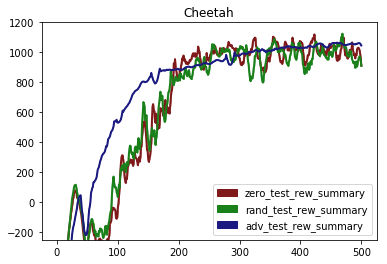

In [14]:
plot_tests = [const_test_rew_summary, rand_test_rew_summary, adv_test_rew_summary]
plot_names = ['zero_test_rew_summary', 'rand_test_rew_summary', 'adv_test_rew_summary']
plot_colors = [(0.5,0.1,0.1), (0.1,0.5,0.1), (0.1,0.1,0.5)]
all_patches = []
for i in range(len(plot_tests)):
    con_rew = np.array(plot_tests[i])
    mean_con = con_rew.mean(0)
    std_con = con_rew.std(0)
    if if_filtering==True:
        mean_window_size = 15
        mean_order = 3
        std_window_size = 45
        std_order = 2
        mean_con = scipy.signal.savgol_filter(mean_con, mean_window_size, mean_order)
        std_con = scipy.signal.savgol_filter(std_con, std_window_size, std_order)
    x = [i for i in range(len(mean_con))]
    plt.plot(x,mean_con,color=plot_colors[i], linewidth=2.0)
    plt.fill_between(x, mean_con-std_con, mean_con+std_con,color=plot_colors[i], alpha=0.5)
    all_patches.append(mpatches.Patch(color=plot_colors[i], label=plot_names[i]))

plt.legend(handles=all_patches)
axes = plt.gca()
axes.set_ylim([-250,1200])
plt.title("Cheetah")
plt.show()